# Análise de Séries Temporais da Evolução da Energia Elétrica Brasileira entre 2000 e 2020

## DESCRIÇÃO DO PROJETO

A capacidade energética de um país é vital para o crescimento econômico de país. Em um mundo com uma demanda energética cada vez maior, cada país precisará expandir sua matriz energética - em especial a elétrica - de forma contínua. Entretanto, medidas para conter o Aquecimento Global estão sendo cada vez mais incisivas, tentando minimizar a emissão de gases poluentes. Dessa forma, a expansão da matriz elétrica de cada país deve ser realizada utilizando, de preferência, fontes renováveis e pouco poluentes a fim de garantir um mundo melhor para as próximas gerações.

O Brasil é conhecido mundialmente pela sua grande diversidade e disponibiliadade de recursos naturais, o que permite que sua matriz elétrica seja dominada predominantemente por fontes renováveis. Entretando, a crescente demanda energética tem causado problemas na garantia do fornecimento de energia para a população, problemas esses que podem se agravar futuramente. Portanto, esse trabalho tem o intuito de avaliar o crescimento da energia elétrica brasileira entre 2000 e 2020 a partir dos dados de energia despachada no SIN (Sistema Interligado Nacional). 

Essa etapa do projeto tem como principal objetivo a Análise Exploratória dos Dados (EDA) de cada Fonte de Energia e de Agrupamentos criados para compreender melhor o comportamento conjunto de algumas Fontes de Energia.


## 1. IMPORTAÇÕES

Segue abaixo as bibliotecas importadas para a realização desse projeto.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from novaclasse import Graficos, Correlacao, Stats, Nulos

## 2. COLETA DOS DADOS

Os dados utilizados nesse projeto foram coletados através do Portal de Dados Abertos disponibilizado pela ANEEL - Agência Nacional de Energia Elétrica. Os dados compreendem o histórico do volume de energia elétrica produzida no Brasil despachada no Sistema Interligado Nacional (SIN) entre janeiro de 2000 até junho de 2020 (dados mais atualizados disponíveis visto que esse conjunto de dados foi descontinuado). O portal pode ser acessado através desse [link](https://www.aneel.gov.br/dados/geracao).

In [2]:
# Upload e leitura dos dados do projeto
dados = pd.read_csv('GeracaoFonte.csv')
dados.head()

ideGeracaoFonte                 nomFonteGeracao  mdaEnergiaDespachadaGWh  \
0                1  Hidreletricas exclusive Itaipu             21074.749841   
1                2                          Itaipu              6523.780292   
2                3       Oleo Diesel / Combustivel               112.026593   
3                4                     Gas Natural               512.536500   
4                5                          Carvao               772.954908   

   mesReferencia  anoReferencia dthProcessamento  
0              1           2000              NaN  
1              1           2000              NaN  
2              1           2000              NaN  
3              1           2000              NaN  
4              1           2000              NaN

Segue abaixo as descrições de cada variável disponibilizada pela ANEEL no seu Dicionário de Dados, que pode ser acessado pelo [link](https://www.aneel.gov.br/documents/656835/15191504/DD_IG_1_3.pdf/f4be6c6e-4336-0f51-c6d3-f75d184e6e92). Também foram especificados os tipos de cada uma das variáveis.


| Variável | Tipo | Descrição| 
|:------:|:------:|:------:|
|   IdeGeracaoFonte  | int64 | Identificador Geração Fonte|
|   NomFonteGeracao  | object | Nome da fonte de geração de energia elétrica|
|   MdaEnergiaDespachadaGWh  | float64 | Quantidade de Carga de energia despachada pelo sistema interligado e pelas geradoras isoladas|
|   MesReferencia  | int64 | Mês de referência da coleta da carga de energia despachada em GWh|
|   AnoReferencia  | int64 | Ano de referência da coleta da carga de energia despachada em GWh|
|   DthProcessamento  | object | Data e hora do processamento de carga automática.|

## 3. TRATAMENTO DOS DADOS

### 3.1. Tratamento Inicial dos Dados

O tratamento dos dados é realizado como primeira medida antes de se poder inferir informações a partir dos dados, de modo que é necessário que eles sejam adequados para análise e aplicação dos modelos de Séries Temporais. É importante muito cuidado nesta etapa visto que dados com tratamentos inadequados podem gerar análises e modelos incorretos, comprometendo quaisquer conclusões realizadas.

In [3]:
# Somatório dos valores nulos de cada variável
dados.isna().sum()

ideGeracaoFonte               0
nomFonteGeracao               0
mdaEnergiaDespachadaGWh      71
mesReferencia                 0
anoReferencia                 0
dthProcessamento           2364
dtype: int64

Eliminação da coluna "dthProcessamento" pela forte predominância de valores nulos e da coluna "ideGeracaoFonte" pois o DataFrame do Pandas já insere índices para cada valor.
Além disso, a posterior exclusão de linhas tornaria os valores fornecidos por "ideGeracaoFonte" incoerentes com o estado do DataFrame.

In [4]:
# Eliminação das colunas selecionadas
dados.drop(['dthProcessamento', 'ideGeracaoFonte'], axis=1, inplace=True)
dados

nomFonteGeracao  mdaEnergiaDespachadaGWh  mesReferencia  \
0     Hidreletricas exclusive Itaipu             21074.749841              1   
1                             Itaipu              6523.780292              1   
2          Oleo Diesel / Combustivel               112.026593              1   
3                        Gas Natural               512.536500              1   
4                             Carvao               772.954908              1   
...                              ...                      ...            ...   
2491                          Carvao               610.747200              6   
2492                       Biomassas              1030.651200              6   
2493                         Nuclear              1037.253600              6   
2494  Residuos Processos Industriais               765.554400              6   
2495   Energia produzida fora do SIN                 0.000000              6   

      anoReferencia  
0              2000  
1              2000  
2              2000  
3              2000  
4              2000  
...             ...  
2491           2020  
2492           2020  
2493           2020  
2494           2020  
2495           2020  

[2496 rows x 4 columns]

Como os dados tem comportamento variando com o tempo, é necessário que haja uma formatação que adeque a variável de data no formato aceito pelo Pandas (ano-mês-dia / 2000-01-01). Dessa forma, criou-se uma variável referente ao dia (day), onde o dia 1 foi arbitrariamente escolhido, visto que os dados foram disponibilizados mensalmente.

In [5]:
# Primeiramente, deve-se renomear as colunas com dados temporais para year e month
dados.rename(columns = {'mesReferencia': 'month', 'anoReferencia': 'year'}, inplace=True)

# Posteriormente, deve-se criar a coluna day
day = pd.Series(1 for x in range(len(dados)))
dados['day'] = day.values

# Os dados serão agregados e uma nova coluna date será acrescentada ao dataframe
dados['date'] = pd.to_datetime(dados[['year', 'month', 'day']])

# Por fim, o index é resetado para adequar-se à quantidade de variáveis presentes no dataframe
dados = dados.set_index('date', drop=True)
dados.head(5)

nomFonteGeracao  mdaEnergiaDespachadaGWh  month  \
date                                                                         
2000-01-01  Hidreletricas exclusive Itaipu             21074.749841      1   
2000-01-01                          Itaipu              6523.780292      1   
2000-01-01       Oleo Diesel / Combustivel               112.026593      1   
2000-01-01                     Gas Natural               512.536500      1   
2000-01-01                          Carvao               772.954908      1   

            year  day  
date                   
2000-01-01  2000    1  
2000-01-01  2000    1  
2000-01-01  2000    1  
2000-01-01  2000    1  
2000-01-01  2000    1

Para facilitar as análises que serão realizadas durante este trabalho, o DataFrame será disposto de forma que cada Fonte de Geração será disposta em uma coluna. 

Primeiramente, serão dropadas as colunas referentes ao dia, mês e ano, visto que elas já estão indicadas através da variável date.

In [6]:
# Eliminação das colunas selecionadas
dados.drop(['day', 'month', 'year'], axis=1, inplace=True)
dados

nomFonteGeracao  mdaEnergiaDespachadaGWh
date                                                               
2000-01-01  Hidreletricas exclusive Itaipu             21074.749841
2000-01-01                          Itaipu              6523.780292
2000-01-01       Oleo Diesel / Combustivel               112.026593
2000-01-01                     Gas Natural               512.536500
2000-01-01                          Carvao               772.954908
...                                    ...                      ...
2020-06-01                          Carvao               610.747200
2020-06-01                       Biomassas              1030.651200
2020-06-01                         Nuclear              1037.253600
2020-06-01  Residuos Processos Industriais               765.554400
2020-06-01   Energia produzida fora do SIN                 0.000000

[2496 rows x 2 columns]

Agora, os dados serão pivotados para que eles sejam rearranjados da forma desejada.

In [7]:
# Pivoteamento das linhas para rearranjo do DataFrame
dados = dados.pivot(columns='nomFonteGeracao', values='mdaEnergiaDespachadaGWh')
dados

nomFonteGeracao   Biomassas       Carvao  Energia produzida fora do SIN  \
date                                                                      
2000-01-01          0.00000   772.954908                            NaN   
2000-02-01          0.00000   726.482505                            NaN   
2000-03-01          0.00000   685.798458                      20670.975   
2000-04-01        358.88560     0.000000                          0.000   
2000-05-01          0.00000   725.874700                            NaN   
...                     ...          ...                            ...   
2020-02-01        309.88008  1000.854960                          0.000   
2020-03-01        451.83864   643.321920                          0.000   
2020-04-01        759.34080   202.917600                          0.000   
2020-05-01        973.07016   478.778880                          0.000   
2020-06-01       1030.65120   610.747200                          0.000   

nomFonteGeracao     Eolicas  Gas Natural  Hidreletricas exclusive Itaipu  \
date                                                                       
2000-01-01          0.00000   512.536500                    21074.749841   
2000-02-01          0.00000   580.842549                    20519.823366   
2000-03-01          0.00000   513.065176                    21184.922627   
2000-04-01          0.00000   675.601700                     7128.300200   
2000-05-01          0.00000   503.225500                    21986.323500   
...                     ...          ...                             ...   
2020-02-01       2710.30752  3349.402560                    32612.889600   
2020-03-01       2215.23768  2616.893520                    35229.709440   
2020-04-01       3039.06240  2068.552800                    28373.400000   
2020-05-01       3764.50608  1965.848880                    26839.651200   
2020-06-01       4733.37360  2387.793600                    25809.948000   

nomFonteGeracao       Itaipu      Nuclear  Oleo Diesel / Combustivel  \
date                                                                   
2000-01-01       6523.780292   418.609402                 112.026593   
2000-02-01       6362.831799   400.617872                  69.214905   
2000-03-01       7593.289824   400.187101                  78.197350   
2000-04-01         39.287100     0.000000                 337.403200   
2000-05-01       6814.969400     0.000000                 101.455500   
...                      ...          ...                        ...   
2020-02-01       5646.801120   948.641040                  46.534560   
2020-03-01       5294.795040  1282.120320                  84.220800   
2020-04-01       3886.149600  1358.755200                 124.992000   
2020-05-01       4636.898160  1481.690880                  80.240400   
2020-06-01       4308.249600  1037.253600                  40.305600   

nomFonteGeracao  Residuos Processos Industriais  Solar Fotovoltaica  
date                                                                 
2000-01-01                              0.00000                 NaN  
2000-02-01                              0.00000                 NaN  
2000-03-01                              0.00000                 NaN  
2000-04-01                              0.00000                 NaN  
2000-05-01                              0.00000                 NaN  
...                                         ...                 ...  
2020-02-01                            838.10232           357.36816  
2020-03-01                            832.03008           419.48208  
2020-04-01                            759.37680           438.44400  
2020-05-01                            774.74952           442.06992  
2020-06-01                            765.55440           432.62640  

[246 rows x 11 columns]

Após o pivoteamento, é interessante recuperar as informações de mês e ano de cada dado enquanto "date" é mantido como index. 

In [8]:
# Resetar o indexamento
dados.reset_index(inplace=True, drop=False)

# Criação das variáveis 'month' e 'year' a partir de 'date'
dados['month'] = pd.DatetimeIndex(dados['date']).month
dados['year'] = pd.DatetimeIndex(dados['date']).year

# Retornar 'date' como index
dados = dados.set_index('date', drop=False)

# Eliminação da coluna 'date' residual
dados.drop(['date'], axis=1, inplace=True)
dados.head(5)

nomFonteGeracao  Biomassas      Carvao  Energia produzida fora do SIN  \
date                                                                    
2000-01-01          0.0000  772.954908                            NaN   
2000-02-01          0.0000  726.482505                            NaN   
2000-03-01          0.0000  685.798458                      20670.975   
2000-04-01        358.8856    0.000000                          0.000   
2000-05-01          0.0000  725.874700                            NaN   

nomFonteGeracao  Eolicas  Gas Natural  Hidreletricas exclusive Itaipu  \
date                                                                    
2000-01-01           0.0   512.536500                    21074.749841   
2000-02-01           0.0   580.842549                    20519.823366   
2000-03-01           0.0   513.065176                    21184.922627   
2000-04-01           0.0   675.601700                     7128.300200   
2000-05-01           0.0   503.225500                    21986.323500   

nomFonteGeracao       Itaipu     Nuclear  Oleo Diesel / Combustivel  \
date                                                                  
2000-01-01       6523.780292  418.609402                 112.026593   
2000-02-01       6362.831799  400.617872                  69.214905   
2000-03-01       7593.289824  400.187101                  78.197350   
2000-04-01         39.287100    0.000000                 337.403200   
2000-05-01       6814.969400    0.000000                 101.455500   

nomFonteGeracao  Residuos Processos Industriais  Solar Fotovoltaica  month  \
date                                                                         
2000-01-01                                  0.0                 NaN      1   
2000-02-01                                  0.0                 NaN      2   
2000-03-01                                  0.0                 NaN      3   
2000-04-01                                  0.0                 NaN      4   
2000-05-01                                  0.0                 NaN      5   

nomFonteGeracao  year  
date                   
2000-01-01       2000  
2000-02-01       2000  
2000-03-01       2000  
2000-04-01       2000  
2000-05-01       2000

As Fontes de Geração presentes no DataFrame serão padronizadas para evitar problemas na hora de selecionar alguma variável, normalmente ocasionados pela presença de espaços e caracteres especiais. Além disso, foram feitas traduções e simplificações nos nomes de algumas variáveis.

In [9]:
# Mudanças nos nomes dos dados
dados = dados.rename(columns={
    'Energia produzida fora do SIN':'Fora_do_SIN',
    'Gas Natural': 'Gas_Natural',
    'Hidreletricas exclusive Itaipu': 'Hidreletricas_exceto_Itaipu',
    'Oleo Diesel / Combustivel': 'Oleo',
    'Residuos Processos Industriais': 'Residuos_Industriais',
    'Solar Fotovoltaica': 'Solar_Fotovoltaica'
})
dados

nomFonteGeracao   Biomassas       Carvao  Fora_do_SIN     Eolicas  \
date                                                                
2000-01-01          0.00000   772.954908          NaN     0.00000   
2000-02-01          0.00000   726.482505          NaN     0.00000   
2000-03-01          0.00000   685.798458    20670.975     0.00000   
2000-04-01        358.88560     0.000000        0.000     0.00000   
2000-05-01          0.00000   725.874700          NaN     0.00000   
...                     ...          ...          ...         ...   
2020-02-01        309.88008  1000.854960        0.000  2710.30752   
2020-03-01        451.83864   643.321920        0.000  2215.23768   
2020-04-01        759.34080   202.917600        0.000  3039.06240   
2020-05-01        973.07016   478.778880        0.000  3764.50608   
2020-06-01       1030.65120   610.747200        0.000  4733.37360   

nomFonteGeracao  Gas_Natural  Hidreletricas_exceto_Itaipu       Itaipu  \
date                                                                     
2000-01-01        512.536500                 21074.749841  6523.780292   
2000-02-01        580.842549                 20519.823366  6362.831799   
2000-03-01        513.065176                 21184.922627  7593.289824   
2000-04-01        675.601700                  7128.300200    39.287100   
2000-05-01        503.225500                 21986.323500  6814.969400   
...                      ...                          ...          ...   
2020-02-01       3349.402560                 32612.889600  5646.801120   
2020-03-01       2616.893520                 35229.709440  5294.795040   
2020-04-01       2068.552800                 28373.400000  3886.149600   
2020-05-01       1965.848880                 26839.651200  4636.898160   
2020-06-01       2387.793600                 25809.948000  4308.249600   

nomFonteGeracao      Nuclear        Oleo  Residuos_Industriais  \
date                                                             
2000-01-01        418.609402  112.026593               0.00000   
2000-02-01        400.617872   69.214905               0.00000   
2000-03-01        400.187101   78.197350               0.00000   
2000-04-01          0.000000  337.403200               0.00000   
2000-05-01          0.000000  101.455500               0.00000   
...                      ...         ...                   ...   
2020-02-01        948.641040   46.534560             838.10232   
2020-03-01       1282.120320   84.220800             832.03008   
2020-04-01       1358.755200  124.992000             759.37680   
2020-05-01       1481.690880   80.240400             774.74952   
2020-06-01       1037.253600   40.305600             765.55440   

nomFonteGeracao  Solar_Fotovoltaica  month  year  
date                                              
2000-01-01                      NaN      1  2000  
2000-02-01                      NaN      2  2000  
2000-03-01                      NaN      3  2000  
2000-04-01                      NaN      4  2000  
2000-05-01                      NaN      5  2000  
...                             ...    ...   ...  
2020-02-01                357.36816      2  2020  
2020-03-01                419.48208      3  2020  
2020-04-01                438.44400      4  2020  
2020-05-01                442.06992      5  2020  
2020-06-01                432.62640      6  2020  

[246 rows x 13 columns]

Para a análise da Matriz Elétrica Brasileira, a criação de algumas variáveis irá aprofundar a análise. Dessa forma, serão feitos alguns agrupamentos para que eles sejam adicionados ao DataFrame.

Primeiramente, será criada uma coluna com os valores totais de Energia Gerada em cada data.

In [10]:
# Criação da variável "total"
total = dados.sum(axis=1) - dados['month'] - dados['year']

# Adição da variável ao DataFrame
dados = dados.assign(Total=total)
dados

nomFonteGeracao   Biomassas       Carvao  Fora_do_SIN     Eolicas  \
date                                                                
2000-01-01          0.00000   772.954908          NaN     0.00000   
2000-02-01          0.00000   726.482505          NaN     0.00000   
2000-03-01          0.00000   685.798458    20670.975     0.00000   
2000-04-01        358.88560     0.000000        0.000     0.00000   
2000-05-01          0.00000   725.874700          NaN     0.00000   
...                     ...          ...          ...         ...   
2020-02-01        309.88008  1000.854960        0.000  2710.30752   
2020-03-01        451.83864   643.321920        0.000  2215.23768   
2020-04-01        759.34080   202.917600        0.000  3039.06240   
2020-05-01        973.07016   478.778880        0.000  3764.50608   
2020-06-01       1030.65120   610.747200        0.000  4733.37360   

nomFonteGeracao  Gas_Natural  Hidreletricas_exceto_Itaipu       Itaipu  \
date                                                                     
2000-01-01        512.536500                 21074.749841  6523.780292   
2000-02-01        580.842549                 20519.823366  6362.831799   
2000-03-01        513.065176                 21184.922627  7593.289824   
2000-04-01        675.601700                  7128.300200    39.287100   
2000-05-01        503.225500                 21986.323500  6814.969400   
...                      ...                          ...          ...   
2020-02-01       3349.402560                 32612.889600  5646.801120   
2020-03-01       2616.893520                 35229.709440  5294.795040   
2020-04-01       2068.552800                 28373.400000  3886.149600   
2020-05-01       1965.848880                 26839.651200  4636.898160   
2020-06-01       2387.793600                 25809.948000  4308.249600   

nomFonteGeracao      Nuclear        Oleo  Residuos_Industriais  \
date                                                             
2000-01-01        418.609402  112.026593               0.00000   
2000-02-01        400.617872   69.214905               0.00000   
2000-03-01        400.187101   78.197350               0.00000   
2000-04-01          0.000000  337.403200               0.00000   
2000-05-01          0.000000  101.455500               0.00000   
...                      ...         ...                   ...   
2020-02-01        948.641040   46.534560             838.10232   
2020-03-01       1282.120320   84.220800             832.03008   
2020-04-01       1358.755200  124.992000             759.37680   
2020-05-01       1481.690880   80.240400             774.74952   
2020-06-01       1037.253600   40.305600             765.55440   

nomFonteGeracao  Solar_Fotovoltaica  month  year         Total  
date                                                            
2000-01-01                      NaN      1  2000  29414.657538  
2000-02-01                      NaN      2  2000  28659.812997  
2000-03-01                      NaN      3  2000  51126.435535  
2000-04-01                      NaN      4  2000   8539.477800  
2000-05-01                      NaN      5  2000  30131.848600  
...                             ...    ...   ...           ...  
2020-02-01                357.36816      2  2020  47820.781920  
2020-03-01                419.48208      3  2020  49069.649520  
2020-04-01                438.44400      4  2020  41010.991200  
2020-05-01                442.06992      5  2020  41437.504080  
2020-06-01                432.62640      6  2020  41156.503200  

[246 rows x 14 columns]

Separação dos dados entre Fontes Renováveis e Não Renováveis, excluindo "Fora_do_SIN" e "Residuos_Industriais" dessas classificações.

In [11]:
# Seleção das Fontes Renováveis
fontes_renovaveis = ['Hidreletricas_exceto_Itaipu', 'Itaipu', 'Eolicas', 'Biomassas', 'Solar_Fotovoltaica']
selecao = dados[fontes_renovaveis]

# Criação do agrupamento de Fontes Renováveis 
renovaveis = selecao.sum(axis=1)

# Inserção do agrupamento no DataFrame
dados = dados.assign(Renovavel=renovaveis)

dados

nomFonteGeracao   Biomassas       Carvao  Fora_do_SIN     Eolicas  \
date                                                                
2000-01-01          0.00000   772.954908          NaN     0.00000   
2000-02-01          0.00000   726.482505          NaN     0.00000   
2000-03-01          0.00000   685.798458    20670.975     0.00000   
2000-04-01        358.88560     0.000000        0.000     0.00000   
2000-05-01          0.00000   725.874700          NaN     0.00000   
...                     ...          ...          ...         ...   
2020-02-01        309.88008  1000.854960        0.000  2710.30752   
2020-03-01        451.83864   643.321920        0.000  2215.23768   
2020-04-01        759.34080   202.917600        0.000  3039.06240   
2020-05-01        973.07016   478.778880        0.000  3764.50608   
2020-06-01       1030.65120   610.747200        0.000  4733.37360   

nomFonteGeracao  Gas_Natural  Hidreletricas_exceto_Itaipu       Itaipu  \
date                                                                     
2000-01-01        512.536500                 21074.749841  6523.780292   
2000-02-01        580.842549                 20519.823366  6362.831799   
2000-03-01        513.065176                 21184.922627  7593.289824   
2000-04-01        675.601700                  7128.300200    39.287100   
2000-05-01        503.225500                 21986.323500  6814.969400   
...                      ...                          ...          ...   
2020-02-01       3349.402560                 32612.889600  5646.801120   
2020-03-01       2616.893520                 35229.709440  5294.795040   
2020-04-01       2068.552800                 28373.400000  3886.149600   
2020-05-01       1965.848880                 26839.651200  4636.898160   
2020-06-01       2387.793600                 25809.948000  4308.249600   

nomFonteGeracao      Nuclear        Oleo  Residuos_Industriais  \
date                                                             
2000-01-01        418.609402  112.026593               0.00000   
2000-02-01        400.617872   69.214905               0.00000   
2000-03-01        400.187101   78.197350               0.00000   
2000-04-01          0.000000  337.403200               0.00000   
2000-05-01          0.000000  101.455500               0.00000   
...                      ...         ...                   ...   
2020-02-01        948.641040   46.534560             838.10232   
2020-03-01       1282.120320   84.220800             832.03008   
2020-04-01       1358.755200  124.992000             759.37680   
2020-05-01       1481.690880   80.240400             774.74952   
2020-06-01       1037.253600   40.305600             765.55440   

nomFonteGeracao  Solar_Fotovoltaica  month  year         Total     Renovavel  
date                                                                          
2000-01-01                      NaN      1  2000  29414.657538  27598.530133  
2000-02-01                      NaN      2  2000  28659.812997  26882.655166  
2000-03-01                      NaN      3  2000  51126.435535  28778.212451  
2000-04-01                      NaN      4  2000   8539.477800   7526.472900  
2000-05-01                      NaN      5  2000  30131.848600  28801.292900  
...                             ...    ...   ...           ...           ...  
2020-02-01                357.36816      2  2020  47820.781920  41637.246480  
2020-03-01                419.48208      3  2020  49069.649520  43611.062880  
2020-04-01                438.44400      4  2020  41010.991200  36496.396800  
2020-05-01                442.06992      5  2020  41437.504080  36656.195520  
2020-06-01                432.62640      6  2020  41156.503200  36314.848800  

[246 rows x 15 columns]

In [12]:
# Seleção das Fontes Não Renováveis
fontes_nao_renovaveis = ['Oleo', 'Gas_Natural', 'Carvao', 'Nuclear']
selecao = dados[fontes_nao_renovaveis]

# Criação do agrupamento de Fontes Renováveis 
nao_renovaveis = selecao.sum(axis=1)

# Inserção do agrupamento no DataFrame
dados = dados.assign(Nao_Renovavel=nao_renovaveis)

dados

nomFonteGeracao   Biomassas       Carvao  Fora_do_SIN     Eolicas  \
date                                                                
2000-01-01          0.00000   772.954908          NaN     0.00000   
2000-02-01          0.00000   726.482505          NaN     0.00000   
2000-03-01          0.00000   685.798458    20670.975     0.00000   
2000-04-01        358.88560     0.000000        0.000     0.00000   
2000-05-01          0.00000   725.874700          NaN     0.00000   
...                     ...          ...          ...         ...   
2020-02-01        309.88008  1000.854960        0.000  2710.30752   
2020-03-01        451.83864   643.321920        0.000  2215.23768   
2020-04-01        759.34080   202.917600        0.000  3039.06240   
2020-05-01        973.07016   478.778880        0.000  3764.50608   
2020-06-01       1030.65120   610.747200        0.000  4733.37360   

nomFonteGeracao  Gas_Natural  Hidreletricas_exceto_Itaipu       Itaipu  \
date                                                                     
2000-01-01        512.536500                 21074.749841  6523.780292   
2000-02-01        580.842549                 20519.823366  6362.831799   
2000-03-01        513.065176                 21184.922627  7593.289824   
2000-04-01        675.601700                  7128.300200    39.287100   
2000-05-01        503.225500                 21986.323500  6814.969400   
...                      ...                          ...          ...   
2020-02-01       3349.402560                 32612.889600  5646.801120   
2020-03-01       2616.893520                 35229.709440  5294.795040   
2020-04-01       2068.552800                 28373.400000  3886.149600   
2020-05-01       1965.848880                 26839.651200  4636.898160   
2020-06-01       2387.793600                 25809.948000  4308.249600   

nomFonteGeracao      Nuclear        Oleo  Residuos_Industriais  \
date                                                             
2000-01-01        418.609402  112.026593               0.00000   
2000-02-01        400.617872   69.214905               0.00000   
2000-03-01        400.187101   78.197350               0.00000   
2000-04-01          0.000000  337.403200               0.00000   
2000-05-01          0.000000  101.455500               0.00000   
...                      ...         ...                   ...   
2020-02-01        948.641040   46.534560             838.10232   
2020-03-01       1282.120320   84.220800             832.03008   
2020-04-01       1358.755200  124.992000             759.37680   
2020-05-01       1481.690880   80.240400             774.74952   
2020-06-01       1037.253600   40.305600             765.55440   

nomFonteGeracao  Solar_Fotovoltaica  month  year         Total     Renovavel  \
date                                                                           
2000-01-01                      NaN      1  2000  29414.657538  27598.530133   
2000-02-01                      NaN      2  2000  28659.812997  26882.655166   
2000-03-01                      NaN      3  2000  51126.435535  28778.212451   
2000-04-01                      NaN      4  2000   8539.477800   7526.472900   
2000-05-01                      NaN      5  2000  30131.848600  28801.292900   
...                             ...    ...   ...           ...           ...   
2020-02-01                357.36816      2  2020  47820.781920  41637.246480   
2020-03-01                419.48208      3  2020  49069.649520  43611.062880   
2020-04-01                438.44400      4  2020  41010.991200  36496.396800   
2020-05-01                442.06992      5  2020  41437.504080  36656.195520   
2020-06-01                432.62640      6  2020  41156.503200  36314.848800   

nomFonteGeracao  Nao_Renovavel  
date                            
2000-01-01         1816.127404  
2000-02-01         1777.157832  
2000-03-01         1677.248084  
2000-04-01         1013.004900  
2000-05-01         1330.555700  
...     

O Brasil possui as Hidrelétricas como sua principal fonte de energia elétrica historicamente. Dessa forma, se faz relevante analisar essa fonte especialmente - comparando-a com as outras fontes em nossa matriz - e ver como foi sua evolução nesse século.

In [13]:
# Criação da variável que agrupa as Usinas Hidrelétricas 
hidreletricas = dados.Hidreletricas_exceto_Itaipu + dados.Itaipu

# Criação da variável referente ao somatório das outras Fontes de Energia
outras = total - hidreletricas
outras

date
2000-01-01     1816.127404
2000-02-01     1777.157832
2000-03-01    22348.223084
2000-04-01     1371.890500
2000-05-01     1330.555700
                  ...     
2020-02-01     9561.091200
2020-03-01     8545.145040
2020-04-01     8751.441600
2020-05-01     9960.954720
2020-06-01    11038.305600
Length: 246, dtype: float64

Além dessas variáveis, é interessante analisar a predominância das Hidrelétricas dentre as Fontes Renováveis.

In [14]:
# Criação da variável que soma as Fontes Renováveis excetuando as Usinas Hidrelétricas
outras_renovaveis = renovaveis - hidreletricas
outras_renovaveis

date
2000-01-01       0.00000
2000-02-01       0.00000
2000-03-01       0.00000
2000-04-01     358.88560
2000-05-01       0.00000
                 ...    
2020-02-01    3377.55576
2020-03-01    3086.55840
2020-04-01    4236.84720
2020-05-01    5179.64616
2020-06-01    6196.65120
Length: 246, dtype: float64

In [15]:
# Inserção das variáveis no DataFrame
dados = dados.assign(Hidreletricas=hidreletricas, Total_sem_Hidro=outras, Renovaveis_sem_Hidro=outras_renovaveis)
dados

nomFonteGeracao   Biomassas       Carvao  Fora_do_SIN     Eolicas  \
date                                                                
2000-01-01          0.00000   772.954908          NaN     0.00000   
2000-02-01          0.00000   726.482505          NaN     0.00000   
2000-03-01          0.00000   685.798458    20670.975     0.00000   
2000-04-01        358.88560     0.000000        0.000     0.00000   
2000-05-01          0.00000   725.874700          NaN     0.00000   
...                     ...          ...          ...         ...   
2020-02-01        309.88008  1000.854960        0.000  2710.30752   
2020-03-01        451.83864   643.321920        0.000  2215.23768   
2020-04-01        759.34080   202.917600        0.000  3039.06240   
2020-05-01        973.07016   478.778880        0.000  3764.50608   
2020-06-01       1030.65120   610.747200        0.000  4733.37360   

nomFonteGeracao  Gas_Natural  Hidreletricas_exceto_Itaipu       Itaipu  \
date                                                                     
2000-01-01        512.536500                 21074.749841  6523.780292   
2000-02-01        580.842549                 20519.823366  6362.831799   
2000-03-01        513.065176                 21184.922627  7593.289824   
2000-04-01        675.601700                  7128.300200    39.287100   
2000-05-01        503.225500                 21986.323500  6814.969400   
...                      ...                          ...          ...   
2020-02-01       3349.402560                 32612.889600  5646.801120   
2020-03-01       2616.893520                 35229.709440  5294.795040   
2020-04-01       2068.552800                 28373.400000  3886.149600   
2020-05-01       1965.848880                 26839.651200  4636.898160   
2020-06-01       2387.793600                 25809.948000  4308.249600   

nomFonteGeracao      Nuclear        Oleo  Residuos_Industriais  \
date                                                             
2000-01-01        418.609402  112.026593               0.00000   
2000-02-01        400.617872   69.214905               0.00000   
2000-03-01        400.187101   78.197350               0.00000   
2000-04-01          0.000000  337.403200               0.00000   
2000-05-01          0.000000  101.455500               0.00000   
...                      ...         ...                   ...   
2020-02-01        948.641040   46.534560             838.10232   
2020-03-01       1282.120320   84.220800             832.03008   
2020-04-01       1358.755200  124.992000             759.37680   
2020-05-01       1481.690880   80.240400             774.74952   
2020-06-01       1037.253600   40.305600             765.55440   

nomFonteGeracao  Solar_Fotovoltaica  month  year         Total     Renovavel  \
date                                                                           
2000-01-01                      NaN      1  2000  29414.657538  27598.530133   
2000-02-01                      NaN      2  2000  28659.812997  26882.655166   
2000-03-01                      NaN      3  2000  51126.435535  28778.212451   
2000-04-01                      NaN      4  2000   8539.477800   7526.472900   
2000-05-01                      NaN      5  2000  30131.848600  28801.292900   
...                             ...    ...   ...           ...           ...   
2020-02-01                357.36816      2  2020  47820.781920  41637.246480   
2020-03-01                419.48208      3  2020  49069.649520  43611.062880   
2020-04-01                438.44400      4  2020  41010.991200  36496.396800   
2020-05-01                442.06992      5  2020  41437.504080  36656.195520   
2020-06-01                432.62640      6  2020  41156.503200  36314.848800   

nomFonteGeracao  Nao_Renovavel  Hidreletricas  Total_sem_Hidro  \
date                                                             
2000-01-01         1816.127404   27598.530133      1816.127404   
2000-02-01         1777.157832   26882.65

Com a inserção das novas colunas, o DataFrame precisa ter suas colunas reorganizadas para que seja mais fácil a identificação de grupos semelhantes.

In [16]:
# Ordem estabelecida
ordem = ['Carvao', 'Gas_Natural', 'Nuclear', 'Oleo', 'Hidreletricas_exceto_Itaipu', 
        'Itaipu', 'Biomassas', 'Eolicas', 'Solar_Fotovoltaica', 'Fora_do_SIN', 
        'Residuos_Industriais', 'Renovavel', 'Nao_Renovavel', 'Hidreletricas', 
         'Renovaveis_sem_Hidro', 'Total_sem_Hidro', 'Total', 'month', 'year']

In [17]:
# Dados organizados
dados = dados[ordem]
dados

nomFonteGeracao       Carvao  Gas_Natural      Nuclear        Oleo  \
date                                                                 
2000-01-01        772.954908   512.536500   418.609402  112.026593   
2000-02-01        726.482505   580.842549   400.617872   69.214905   
2000-03-01        685.798458   513.065176   400.187101   78.197350   
2000-04-01          0.000000   675.601700     0.000000  337.403200   
2000-05-01        725.874700   503.225500     0.000000  101.455500   
...                      ...          ...          ...         ...   
2020-02-01       1000.854960  3349.402560   948.641040   46.534560   
2020-03-01        643.321920  2616.893520  1282.120320   84.220800   
2020-04-01        202.917600  2068.552800  1358.755200  124.992000   
2020-05-01        478.778880  1965.848880  1481.690880   80.240400   
2020-06-01        610.747200  2387.793600  1037.253600   40.305600   

nomFonteGeracao  Hidreletricas_exceto_Itaipu       Itaipu   Biomassas  \
date                                                                    
2000-01-01                      21074.749841  6523.780292     0.00000   
2000-02-01                      20519.823366  6362.831799     0.00000   
2000-03-01                      21184.922627  7593.289824     0.00000   
2000-04-01                       7128.300200    39.287100   358.88560   
2000-05-01                      21986.323500  6814.969400     0.00000   
...                                      ...          ...         ...   
2020-02-01                      32612.889600  5646.801120   309.88008   
2020-03-01                      35229.709440  5294.795040   451.83864   
2020-04-01                      28373.400000  3886.149600   759.34080   
2020-05-01                      26839.651200  4636.898160   973.07016   
2020-06-01                      25809.948000  4308.249600  1030.65120   

nomFonteGeracao     Eolicas  Solar_Fotovoltaica  Fora_do_SIN  \
date                                                           
2000-01-01          0.00000                 NaN          NaN   
2000-02-01          0.00000                 NaN          NaN   
2000-03-01          0.00000                 NaN    20670.975   
2000-04-01          0.00000                 NaN        0.000   
2000-05-01          0.00000                 NaN          NaN   
...                     ...                 ...          ...   
2020-02-01       2710.30752           357.36816        0.000   
2020-03-01       2215.23768           419.48208        0.000   
2020-04-01       3039.06240           438.44400        0.000   
2020-05-01       3764.50608           442.06992        0.000   
2020-06-01       4733.37360           432.62640        0.000   

nomFonteGeracao  Residuos_Industriais     Renovavel  Nao_Renovavel  \
date                                                                 
2000-01-01                    0.00000  27598.530133    1816.127404   
2000-02-01                    0.00000  26882.655166    1777.157832   
2000-03-01                    0.00000  28778.212451    1677.248084   
2000-04-01                    0.00000   7526.472900    1013.004900   
2000-05-01                    0.00000  28801.292900    1330.555700   
...                               ...           ...            ...   
2020-02-01                  838.10232  41637.246480    5345.433120   
2020-03-01                  832.03008  43611.062880    4626.556560   
2020-04-01                  759.37680  36496.396800    3755.217600   
2020-05-01                  774.74952  36656.195520    4006.559040   
2020-06-01                  765.55440  36314.848800    4076.100000   

nomFonteGeracao  Hidreletricas  Renovaveis_sem_Hidro  Total_sem_Hidro  \
date                                                                    
2000-01-01        27598.530133               0.00000      1816.127404   
2000-02-01        26882.655166               0.00000      1777.157832   
2000-03-01        28778.212451               0.00000     22348.223084   
2000-04-01         7167.587300

In [18]:
# Informações sobre os dados do DataFrame
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2000-01-01 to 2020-06-01
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Carvao                       246 non-null    float64
 1   Gas_Natural                  246 non-null    float64
 2   Nuclear                      246 non-null    float64
 3   Oleo                         246 non-null    float64
 4   Hidreletricas_exceto_Itaipu  246 non-null    float64
 5   Itaipu                       246 non-null    float64
 6   Biomassas                    246 non-null    float64
 7   Eolicas                      246 non-null    float64
 8   Solar_Fotovoltaica           36 non-null     float64
 9   Fora_do_SIN                  175 non-null    float64
 10  Residuos_Industriais         246 non-null    float64
 11  Renovavel                    246 non-null    float64
 12  Nao_Renovavel                246 non-null    float64
 13  H

As informações acima mostram as principais informações do DataFrame, que possui 246 entradas dispostas em 19 colunas, além do fato de todas as variáveis - exceto o index (date), 'month' e 'year' (int) - serem do tipo float (número de valor flutuante). 

Entretanto, é notada a presença de valores nulos nas colunas 8 e 9, visto que sua contagem de valores não-nulos não é igual ao número de entradas. Dessa forma, o tratamento desses valores será feito a partir da substituição desses por 0.

In [19]:
# Retirando os valores nulos presentes no DataFrame
dados = dados.fillna(0)
dados

nomFonteGeracao       Carvao  Gas_Natural      Nuclear        Oleo  \
date                                                                 
2000-01-01        772.954908   512.536500   418.609402  112.026593   
2000-02-01        726.482505   580.842549   400.617872   69.214905   
2000-03-01        685.798458   513.065176   400.187101   78.197350   
2000-04-01          0.000000   675.601700     0.000000  337.403200   
2000-05-01        725.874700   503.225500     0.000000  101.455500   
...                      ...          ...          ...         ...   
2020-02-01       1000.854960  3349.402560   948.641040   46.534560   
2020-03-01        643.321920  2616.893520  1282.120320   84.220800   
2020-04-01        202.917600  2068.552800  1358.755200  124.992000   
2020-05-01        478.778880  1965.848880  1481.690880   80.240400   
2020-06-01        610.747200  2387.793600  1037.253600   40.305600   

nomFonteGeracao  Hidreletricas_exceto_Itaipu       Itaipu   Biomassas  \
date                                                                    
2000-01-01                      21074.749841  6523.780292     0.00000   
2000-02-01                      20519.823366  6362.831799     0.00000   
2000-03-01                      21184.922627  7593.289824     0.00000   
2000-04-01                       7128.300200    39.287100   358.88560   
2000-05-01                      21986.323500  6814.969400     0.00000   
...                                      ...          ...         ...   
2020-02-01                      32612.889600  5646.801120   309.88008   
2020-03-01                      35229.709440  5294.795040   451.83864   
2020-04-01                      28373.400000  3886.149600   759.34080   
2020-05-01                      26839.651200  4636.898160   973.07016   
2020-06-01                      25809.948000  4308.249600  1030.65120   

nomFonteGeracao     Eolicas  Solar_Fotovoltaica  Fora_do_SIN  \
date                                                           
2000-01-01          0.00000             0.00000        0.000   
2000-02-01          0.00000             0.00000        0.000   
2000-03-01          0.00000             0.00000    20670.975   
2000-04-01          0.00000             0.00000        0.000   
2000-05-01          0.00000             0.00000        0.000   
...                     ...                 ...          ...   
2020-02-01       2710.30752           357.36816        0.000   
2020-03-01       2215.23768           419.48208        0.000   
2020-04-01       3039.06240           438.44400        0.000   
2020-05-01       3764.50608           442.06992        0.000   
2020-06-01       4733.37360           432.62640        0.000   

nomFonteGeracao  Residuos_Industriais     Renovavel  Nao_Renovavel  \
date                                                                 
2000-01-01                    0.00000  27598.530133    1816.127404   
2000-02-01                    0.00000  26882.655166    1777.157832   
2000-03-01                    0.00000  28778.212451    1677.248084   
2000-04-01                    0.00000   7526.472900    1013.004900   
2000-05-01                    0.00000  28801.292900    1330.555700   
...                               ...           ...            ...   
2020-02-01                  838.10232  41637.246480    5345.433120   
2020-03-01                  832.03008  43611.062880    4626.556560   
2020-04-01                  759.37680  36496.396800    3755.217600   
2020-05-01                  774.74952  36656.195520    4006.559040   
2020-06-01                  765.55440  36314.848800    4076.100000   

nomFonteGeracao  Hidreletricas  Renovaveis_sem_Hidro  Total_sem_Hidro  \
date                                                                    
2000-01-01        27598.530133               0.00000      1816.127404   
2000-02-01        26882.655166               0.00000      1777.157832   
2000-03-01        28778.212451               0.00000     22348.223084   
2000-04-01         7167.587300

### 3.2. Limpeza dos Dados

Para que os dados possam ser analisados, é necessário que quaisquer dados incorretos sejam tratados a priori. Para ilustrar o problema nesse dataset será plotado o gráfico de linhas para acompanhar a evolucão da Matriz Elétrica Brasileira sem distinção por tipo de Fonte.

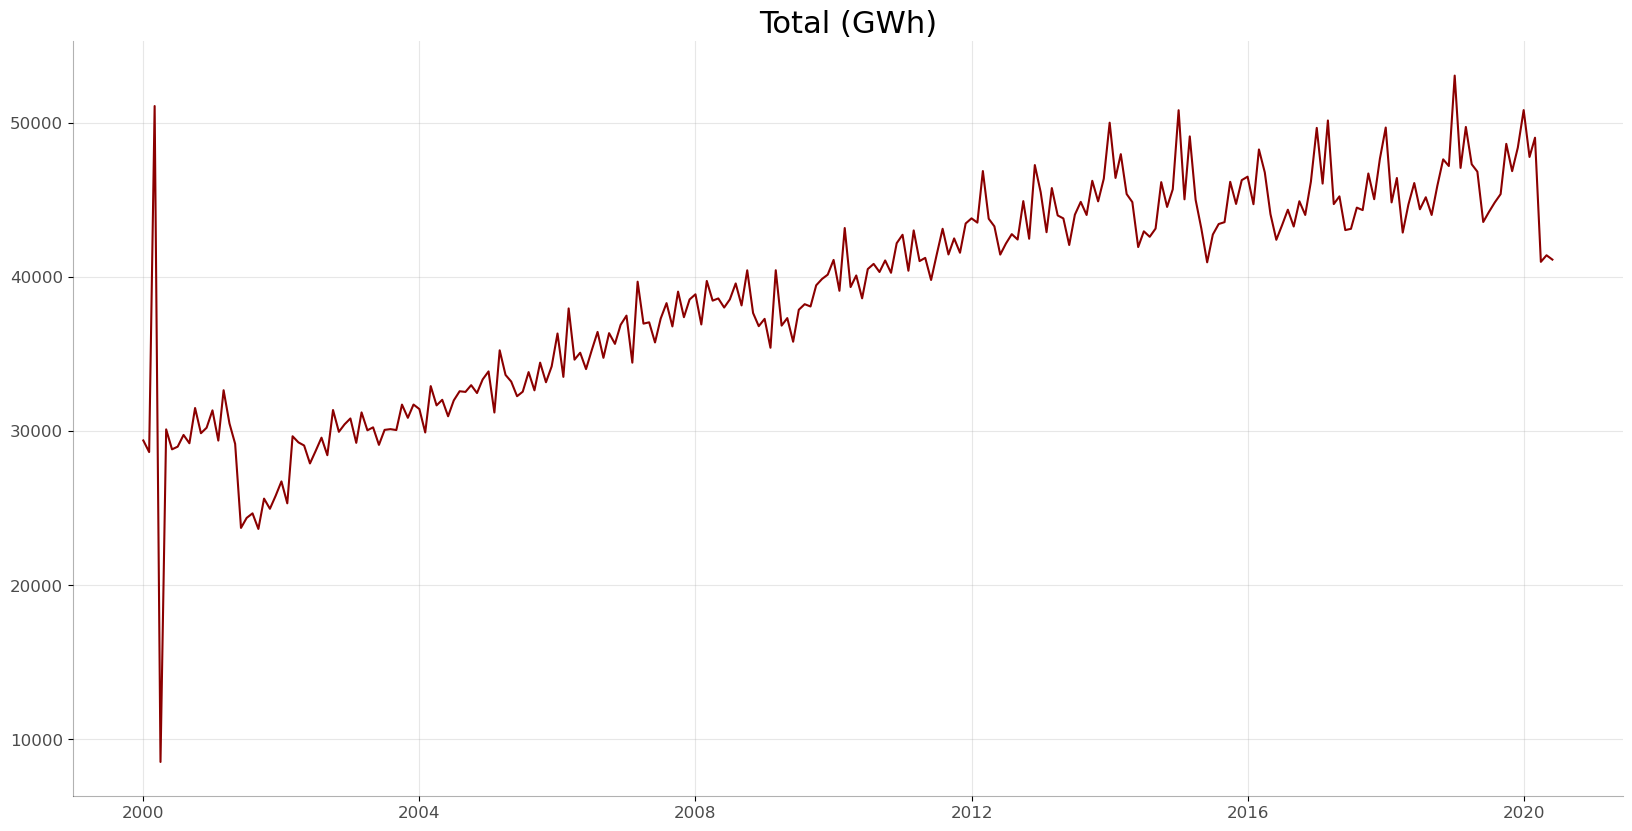

In [20]:
# Criação do objeto referente à Classe "Gráficos" da Energia Total (soma e soma_perc ainda foram definidos)
total_graficos = Graficos('Total', dados, soma=None, soma_perc=None)

# Gráfico de linhas para os dados Totais de Energia
total_graficos.lineplot()

Analisando o gráfico de linhas, é notável um crescimento temporal e a presença de sazonalidade pela presença de pequenas oscilações periódicas. Entretanto, a oscilação em seus primeiros dados é muito discrepante em comparação com os outros dados. Agora, será analisado o boxplot desse conjunto de dados.

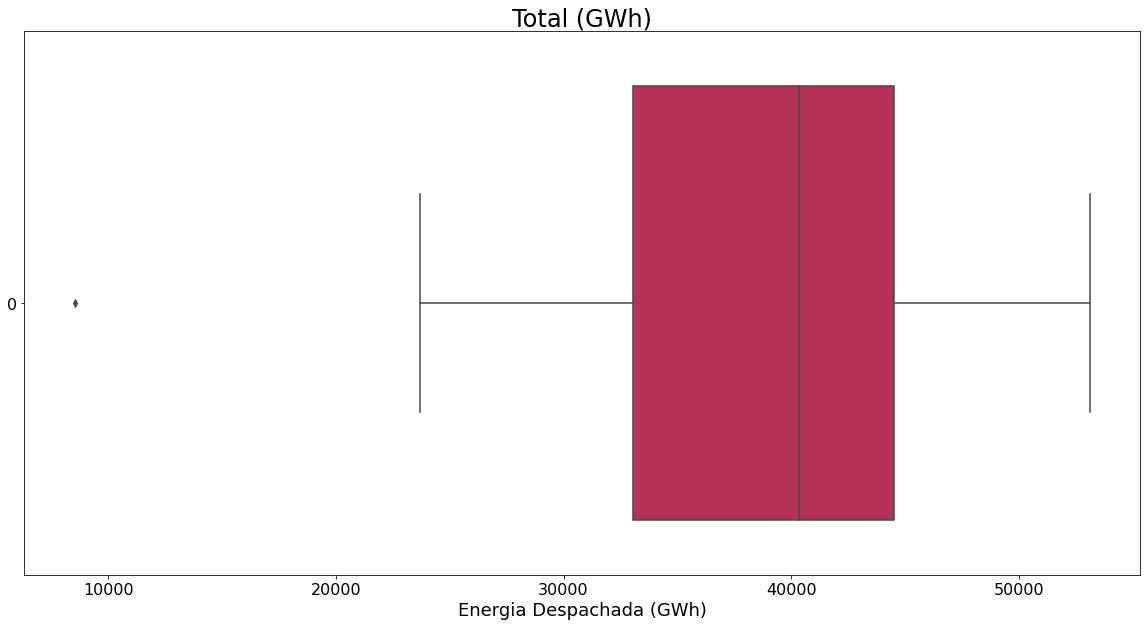

In [21]:
# Boxplot para os dados Totais de Energia
total_graficos.boxplot()

Através do boxplot é perceptível a presença de um outlier no boxplot. Portanto, é interessante fazer uma análise para identificar o período exato em que ocorre esse valor inesperado e plotar esses dados. Como a grande discrepância ocorre no começo do conjunto de dados, serão analisados os 10 primeiros dados.

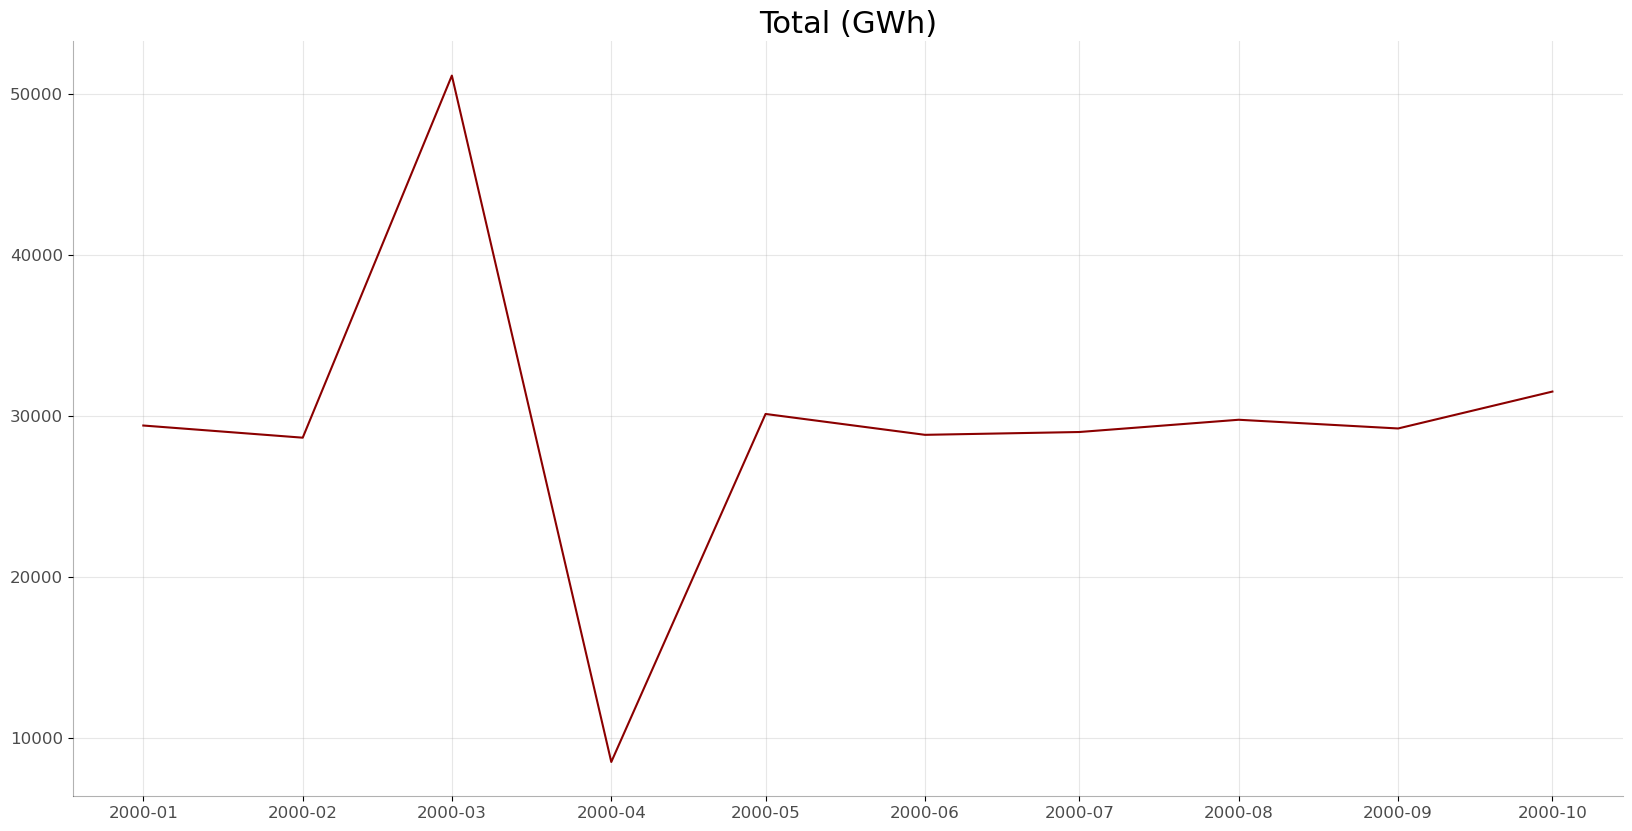

In [22]:
# Criação do objeto referente à Classe "Gráficos" da Energia Total (soma e soma_perc ainda foram definidos)
total_graficos = Graficos('Total', dados[:10], soma=None, soma_perc=None)

# Gráfico de linhas para os 10 primeiros dados
total_graficos.lineplot()

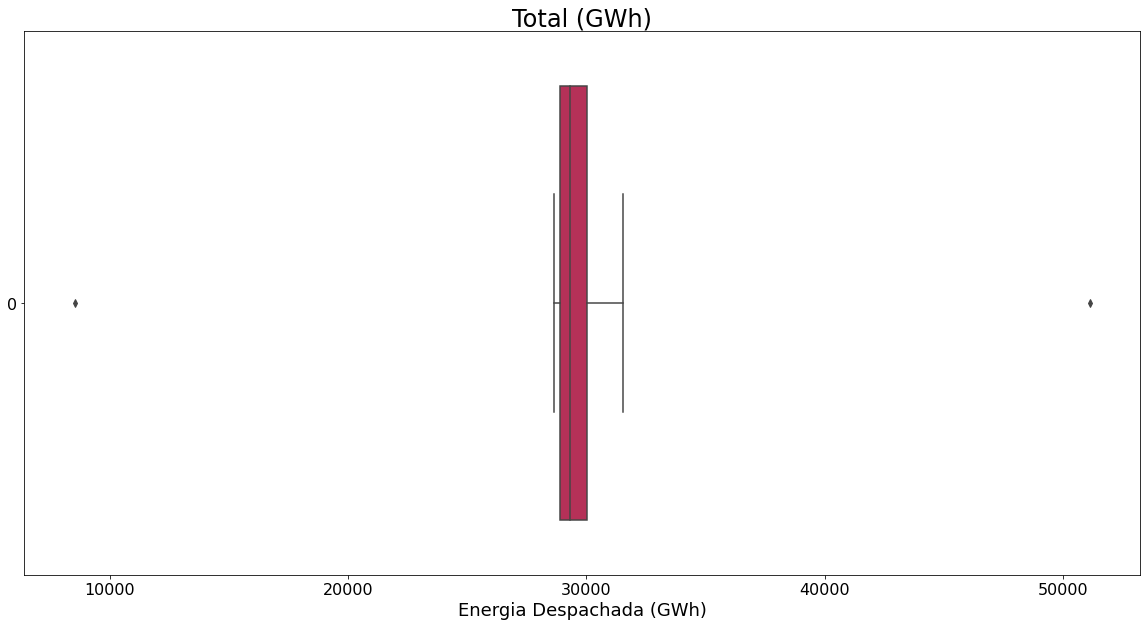

In [23]:
# Boxplot para os 10 primeiros dados
total_graficos.boxplot()

In [24]:
# Criação do objeto referente à Classe "Gráficos" da Energia Total (soma e soma_perc ainda foram definidos)
total_stats = Stats('Total', dados[:10])
# Obtenção dos valores outliers
total_stats.get_outliers()

(                Total
 date                 
 2000-04-01  8539.4778,
                    Total
 date                    
 2000-03-01  51126.435535)

Os gráficos acima mostram com maior detalhamento a grande variação nos dados de Energia Despachada Total nesses meses com um retorno à tendência de fev/2000 a partir de mai/2000, além da presença de dois dados muito discrepantes (mar/2000 e abr/2000). Segue abaixo uma amostra mais detalhada dos dados, avaliando os dados de Energia Despachada por Fonte de Energia.

In [25]:
# Visualização em DataFrame dos primeiros 10 dados 
dados.head(10)

nomFonteGeracao      Carvao  Gas_Natural     Nuclear        Oleo  \
date                                                               
2000-01-01       772.954908   512.536500  418.609402  112.026593   
2000-02-01       726.482505   580.842549  400.617872   69.214905   
2000-03-01       685.798458   513.065176  400.187101   78.197350   
2000-04-01         0.000000   675.601700    0.000000  337.403200   
2000-05-01       725.874700   503.225500    0.000000  101.455500   
2000-06-01       725.001500   574.331600    0.011100  105.998400   
2000-07-01       607.471400   540.092500   67.880700  130.207000   
2000-08-01       627.496300   547.118200  672.390800  127.627800   
2000-09-01       397.343100   500.284800  781.171600   80.348230   
2000-10-01       337.300572   551.155034  537.460912   70.415993   

nomFonteGeracao  Hidreletricas_exceto_Itaipu       Itaipu  Biomassas  Eolicas  \
date                                                                            
2000-01-01                      21074.749841  6523.780292     0.0000      0.0   
2000-02-01                      20519.823366  6362.831799     0.0000      0.0   
2000-03-01                      21184.922627  7593.289824     0.0000      0.0   
2000-04-01                       7128.300200    39.287100   358.8856      0.0   
2000-05-01                      21986.323500  6814.969400     0.0000      0.0   
2000-06-01                      20503.398688  6928.030200     0.0000      0.0   
2000-07-01                      20243.011430  7423.097700     0.0000      0.0   
2000-08-01                      20366.155900  7431.322900     0.0000      0.0   
2000-09-01                      19379.092090  8093.236840     0.0000      0.0   
2000-10-01                      22529.277220  7495.719297     0.0000      0.0   

nomFonteGeracao  Solar_Fotovoltaica  Fora_do_SIN  Residuos_Industriais  \
date                                                                     
2000-01-01                      0.0        0.000                   0.0   
2000-02-01                      0.0        0.000                   0.0   
2000-03-01                      0.0    20670.975                   0.0   
2000-04-01                      0.0        0.000                   0.0   
2000-05-01                      0.0        0.000                   0.0   
2000-06-01                      0.0        0.000                   0.0   
2000-07-01                      0.0        0.000                   0.0   
2000-08-01                      0.0        0.000                   0.0   
2000-09-01                      0.0        0.000                   0.0   
2000-10-01                      0.0        0.000                   0.0   

nomFonteGeracao     Renovavel  Nao_Renovavel  Hidreletricas  \
date                                                          
2000-01-01       27598.530133    1816.127404   27598.530133   
2000-02-01       26882.655166    1777.157832   26882.655166   
2000-03-01       28778.212451    1677.248084   28778.212451   
2000-04-01        7526.472900    1013.004900    7167.587300   
2000-05-01       28801.292900    1330.555700   28801.292900   
2000-06-01       27431.428888    1405.342600   27431.428888   
2000-07-01       27666.109130    1345.651600   27666.109130   
2000-08-01       27797.478800    1974.633100   27797.478800   
2000-09-01       27472.328930    1759.147730   27472.328930   
2000-10-01       30024.996517    1496.332511   30024.996517   

nomFonteGeracao  Renovaveis_sem_Hidro  Total_sem_Hidro         Total  month  \
date                                                                          
2000-01-01                     0.0000      1816.127404  29414.657538      1   
2000-02-01                     0.0000      1777.157832  28659.812997      2   
2000-03-01                     0.0000     22348.223084  51126.435535      3   
2000-04-01                   358.8856      1371.890500   8539.477800      4   
2000-05-01                     0.0000      1330.555700  30131.848600      5   
2000-06-01 

Percebe-se a inserção de valor de Energia na variável "Fora_do_SIN" em abril/2000 de forma inadequada, gerando um valor anormalmente alto para o mês de março e valores muito baixos para algumas variáveis no mês de abril, com o mês de maio possuindo valores mais coerentes para algumas variáveis. 

In [26]:
# Visualização em DataFrame dos dados da variável 'Fora_do_SIN' com valores maiores que zero
pd.DataFrame(dados.query('Fora_do_SIN > 0').Fora_do_SIN)

Fora_do_SIN
date                    
2000-03-01  20670.975000
2006-01-01    827.525252
2006-02-01    762.634875
2006-03-01    893.805701
2006-04-01    813.811430
...                  ...
2019-02-01    220.000000
2019-03-01    258.000000
2019-04-01    250.000000
2019-05-01    250.000000
2019-06-01    250.000000

[162 rows x 1 columns]

O erro deduzido acima fica evidente ao notar que os valores de "Fora_do_SIN" só voltam a ser computados em janeiro de 2006.

In [27]:
# Seleção dos dados entre março e agosto de 2000
dados[2:8]

nomFonteGeracao      Carvao  Gas_Natural     Nuclear       Oleo  \
date                                                              
2000-03-01       685.798458   513.065176  400.187101   78.19735   
2000-04-01         0.000000   675.601700    0.000000  337.40320   
2000-05-01       725.874700   503.225500    0.000000  101.45550   
2000-06-01       725.001500   574.331600    0.011100  105.99840   
2000-07-01       607.471400   540.092500   67.880700  130.20700   
2000-08-01       627.496300   547.118200  672.390800  127.62780   

nomFonteGeracao  Hidreletricas_exceto_Itaipu       Itaipu  Biomassas  Eolicas  \
date                                                                            
2000-03-01                      21184.922627  7593.289824     0.0000      0.0   
2000-04-01                       7128.300200    39.287100   358.8856      0.0   
2000-05-01                      21986.323500  6814.969400     0.0000      0.0   
2000-06-01                      20503.398688  6928.030200     0.0000      0.0   
2000-07-01                      20243.011430  7423.097700     0.0000      0.0   
2000-08-01                      20366.155900  7431.322900     0.0000      0.0   

nomFonteGeracao  Solar_Fotovoltaica  Fora_do_SIN  Residuos_Industriais  \
date                                                                     
2000-03-01                      0.0    20670.975                   0.0   
2000-04-01                      0.0        0.000                   0.0   
2000-05-01                      0.0        0.000                   0.0   
2000-06-01                      0.0        0.000                   0.0   
2000-07-01                      0.0        0.000                   0.0   
2000-08-01                      0.0        0.000                   0.0   

nomFonteGeracao     Renovavel  Nao_Renovavel  Hidreletricas  \
date                                                          
2000-03-01       28778.212451    1677.248084   28778.212451   
2000-04-01        7526.472900    1013.004900    7167.587300   
2000-05-01       28801.292900    1330.555700   28801.292900   
2000-06-01       27431.428888    1405.342600   27431.428888   
2000-07-01       27666.109130    1345.651600   27666.109130   
2000-08-01       27797.478800    1974.633100   27797.478800   

nomFonteGeracao  Renovaveis_sem_Hidro  Total_sem_Hidro         Total  month  \
date                                                                          
2000-03-01                     0.0000     22348.223084  51126.435535      3   
2000-04-01                   358.8856      1371.890500   8539.477800      4   
2000-05-01                     0.0000      1330.555700  30131.848600      5   
2000-06-01                     0.0000      1405.342600  28836.771488      6   
2000-07-01                     0.0000      1345.651600  29011.760730      7   
2000-08-01                     0.0000      1974.633100  29772.111900      8   

nomFonteGeracao  year  
date                   
2000-03-01       2000  
2000-04-01       2000  
2000-05-01       2000  
2000-06-01       2000  
2000-07-01       2000  
2000-08-01       2000

Além disso, uma análise um pouco mais aprofundada sobre os dados desse período mostra que a Fonte Nuclear não tem valores computados em abril e maio, só possuindo valores semelhantes aos anteriores no mês de agosto de 2000. Sendo essa a última variável a ter uma grande discrepância nos dados não explicada, é conveniente considerar os dados a partir do mês de agosto de 2000, criando-se uma nova variável para computar os dados.

In [28]:
# Criação da nova variável "dados_limpos"
dados_limpos = dados[7:]
dados_limpos

nomFonteGeracao       Carvao  Gas_Natural      Nuclear        Oleo  \
date                                                                 
2000-08-01        627.496300   547.118200   672.390800  127.627800   
2000-09-01        397.343100   500.284800   781.171600   80.348230   
2000-10-01        337.300572   551.155034   537.460912   70.415993   
2000-11-01        489.986000   548.470000  1121.170800  100.395000   
2000-12-01        640.149800   673.443400  1221.245700   94.221500   
...                      ...          ...          ...         ...   
2020-02-01       1000.854960  3349.402560   948.641040   46.534560   
2020-03-01        643.321920  2616.893520  1282.120320   84.220800   
2020-04-01        202.917600  2068.552800  1358.755200  124.992000   
2020-05-01        478.778880  1965.848880  1481.690880   80.240400   
2020-06-01        610.747200  2387.793600  1037.253600   40.305600   

nomFonteGeracao  Hidreletricas_exceto_Itaipu       Itaipu   Biomassas  \
date                                                                    
2000-08-01                       20366.15590  7431.322900     0.00000   
2000-09-01                       19379.09209  8093.236840     0.00000   
2000-10-01                       22529.27722  7495.719297     0.00000   
2000-11-01                       20175.47379  7448.224300     0.00000   
2000-12-01                       19822.51809  7787.367770     0.00000   
...                                      ...          ...         ...   
2020-02-01                       32612.88960  5646.801120   309.88008   
2020-03-01                       35229.70944  5294.795040   451.83864   
2020-04-01                       28373.40000  3886.149600   759.34080   
2020-05-01                       26839.65120  4636.898160   973.07016   
2020-06-01                       25809.94800  4308.249600  1030.65120   

nomFonteGeracao     Eolicas  Solar_Fotovoltaica  Fora_do_SIN  \
date                                                           
2000-08-01          0.00000             0.00000          0.0   
2000-09-01          0.00000             0.00000          0.0   
2000-10-01          0.00000             0.00000          0.0   
2000-11-01          0.00000             0.00000          0.0   
2000-12-01          0.00000             0.00000          0.0   
...                     ...                 ...          ...   
2020-02-01       2710.30752           357.36816          0.0   
2020-03-01       2215.23768           419.48208          0.0   
2020-04-01       3039.06240           438.44400          0.0   
2020-05-01       3764.50608           442.06992          0.0   
2020-06-01       4733.37360           432.62640          0.0   

nomFonteGeracao  Residuos_Industriais     Renovavel  Nao_Renovavel  \
date                                                                 
2000-08-01                    0.00000  27797.478800    1974.633100   
2000-09-01                    0.00000  27472.328930    1759.147730   
2000-10-01                    0.00000  30024.996517    1496.332511   
2000-11-01                    0.00000  27623.698090    2260.021800   
2000-12-01                    0.00000  27609.885860    2629.060400   
...                               ...           ...            ...   
2020-02-01                  838.10232  41637.246480    5345.433120   
2020-03-01                  832.03008  43611.062880    4626.556560   
2020-04-01                  759.37680  36496.396800    3755.217600   
2020-05-01                  774.74952  36656.195520    4006.559040   
2020-06-01                  765.55440  36314.848800    4076.100000   

nomFonteGeracao  Hidreletricas  Renovaveis_sem_Hidro  Total_sem_Hidro  \
date                                                                    
2000-08-01        27797.478800               0.00000      1974.633100   
2000-09-01        27472.328930               0.00000      1759.147730   
2000-10-01        30024.996517               0.00000      1496.332511   
2000-11-01        27623.698090

Isso demonstra a dificuldade de se lidar com dados reais. Muitas vezes eles podem ser computados de forma indevida, que é evidente quando a discrepância é muito fácil de ser notada. Entretanto, muitos erros podem ser mais sutis e passar desapercebidos. Ademais, mudanças em políticas governamentais, a inserção de uma nova fonte na matriz energética ou alguma dificuldade no fornecimento de insumos pode gerar desvios nos padrões observados anteriormente. Retomando a frase inicial, lidar com dados reais é complicado e precisa-se muita capacidade analítica, conhecimento do assunto e minunciosidade. 

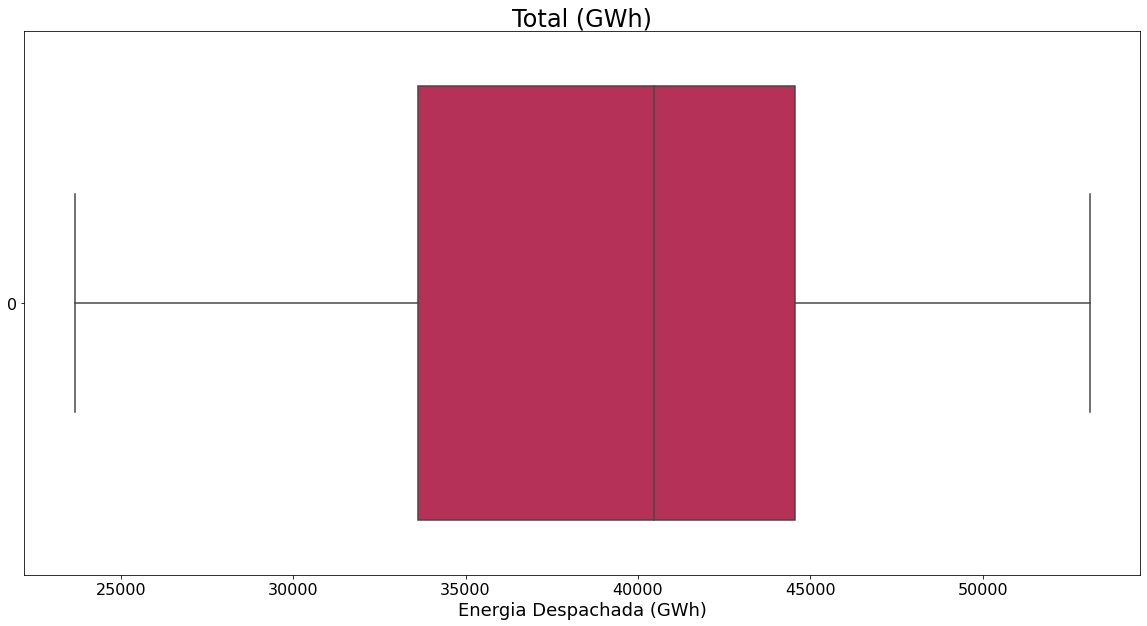

In [29]:
# Atualização do objeto referente à Classe "Gráficos" da Energia Total (soma e soma_perc ainda foram definidos)
total_graficos = Graficos('Total', dados_limpos, soma=None, soma_perc=None)

# Plot do boxplot dos dados totais após limpeza
total_graficos.boxplot()

Agora os dados de Energia Total aparentam possuir um comportamento mais adequado, o que incentiva o aprofundamento da análise e a inferência de tendências dos fenômenos observados. Dessa forma, esses serão os dados utilizados para as análises do restante do trabalho.

### 3.3. Criação de DataFrames Auxiliares

Uma análise importante pode ser realizada através do agrupamento das variáveis através do ano. Dessa forma, poderá se comparar a soma dos dados consolidados para cada ano individualmente. Logo, um dois DataFrames Auxiliares serão criados para evaluar a soma dos valores de cada variável entre 2001 e 2019 (visto que esses são os valores totais disponíveis) e para evaluar a variação percentual anual de energia.

In [30]:
# Criação do DataFrame com os valores somados para os respectivos anos
soma = dados_limpos.drop(columns='month')
soma = soma.groupby('year').sum()[1:20]
soma = soma.reset_index()
day = pd.Series(31 for x in range(len(soma)))
soma['day'] = day.values
month = pd.Series(12 for x in range(len(soma)))
soma['month'] = month.values

soma['date'] = pd.to_datetime(soma[['year', 'month', 'day']])

soma = soma.set_index('date', drop=True)
soma = soma.drop(columns = ['day', 'month', 'year'])

# Criação do DataFrame com as variações percentuais para os respectivos anos
soma_perc = soma.pct_change()*100

# Preencher os valores nulos com zero
soma_perc=soma_perc.fillna(0)

# Renomeação das colunas no DataFrame com os dados percentuais
for i in range(len(soma.columns)):
    soma_perc = soma_perc.rename(columns = {soma_perc.columns[i]: f'{soma_perc.columns[i]}_perc'})

In [31]:
# Informações referentes ao DataFrame Auxiliar "soma"
soma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2001-12-31 to 2019-12-31
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Carvao                       19 non-null     float64
 1   Gas_Natural                  19 non-null     float64
 2   Nuclear                      19 non-null     float64
 3   Oleo                         19 non-null     float64
 4   Hidreletricas_exceto_Itaipu  19 non-null     float64
 5   Itaipu                       19 non-null     float64
 6   Biomassas                    19 non-null     float64
 7   Eolicas                      19 non-null     float64
 8   Solar_Fotovoltaica           19 non-null     float64
 9   Fora_do_SIN                  19 non-null     float64
 10  Residuos_Industriais         19 non-null     float64
 11  Renovavel                    19 non-null     float64
 12  Nao_Renovavel                19 non-null     float64
 13  Hi

In [32]:
# Informações referentes ao DataFrame Auxiliar "soma_perc"
soma_perc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2001-12-31 to 2019-12-31
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Carvao_perc                       19 non-null     float64
 1   Gas_Natural_perc                  19 non-null     float64
 2   Nuclear_perc                      19 non-null     float64
 3   Oleo_perc                         19 non-null     float64
 4   Hidreletricas_exceto_Itaipu_perc  19 non-null     float64
 5   Itaipu_perc                       19 non-null     float64
 6   Biomassas_perc                    19 non-null     float64
 7   Eolicas_perc                      19 non-null     float64
 8   Solar_Fotovoltaica_perc           19 non-null     float64
 9   Fora_do_SIN_perc                  19 non-null     float64
 10  Residuos_Industriais_perc         19 non-null     float64
 11  Renovavel_perc                    19 non-null     flo

In [33]:
# Informações referentes ao DataFrame Auxiliar
soma_perc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2001-12-31 to 2019-12-31
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Carvao_perc                       19 non-null     float64
 1   Gas_Natural_perc                  19 non-null     float64
 2   Nuclear_perc                      19 non-null     float64
 3   Oleo_perc                         19 non-null     float64
 4   Hidreletricas_exceto_Itaipu_perc  19 non-null     float64
 5   Itaipu_perc                       19 non-null     float64
 6   Biomassas_perc                    19 non-null     float64
 7   Eolicas_perc                      19 non-null     float64
 8   Solar_Fotovoltaica_perc           19 non-null     float64
 9   Fora_do_SIN_perc                  19 non-null     float64
 10  Residuos_Industriais_perc         19 non-null     float64
 11  Renovavel_perc                    19 non-null     flo

Verificamos que os dois DataFrames Auxiliares possuem 19 entradas dispostas em 17 colunas, onde o index é do tipo "DateTime" enquanto as outras variáveis são do tipo "float64" (ponto flutuante).

## 4. ANÁLISE EXPLORATÓRIA 

### 4.1. Visão Geral dos Dados

Após a realização de todas as alterações no dataset, essa é a sua configuração atual:

| Variável | Tipo | Descrição| 
|:------:|:------:|:------:|
|   date  | datetime64[ns] (index) | Data referente ao processamento de carga|
|   Carvao  | float64 | Energia despachada pela Fonte Carvão em GWh|
|   Gas_Natural  | float64 | Energia despachada pela Fonte Gás Natural em GWh|
|   Nuclear  | float64 | Energia despachada pela Fonte Nuclear em GWh|
|   Oleo  | float64 | Energia despachada por Derivados de Petróleo (Óleo Diesel/Combustível) em GWh|
|   Hidreletricas_exceto_Itaipu  | float64 | Energia despachada pela Fonte Hidrelétrica (exceto Itaipu) em GWh|
|   Itaipu  | float64 | Energia despachada pela Fonte Itaipu em GWh|
|   Biomassas  | float64 | Energia despachada pela Fonte Biomassas em GWh|
|   Eolicas  | float64 | Energia despachada pela Fonte Eólicas em GWh|
|   Solar_Fotovoltaica  | float64 | Energia despachada pela Fonte Solar Fotovoltaica em GWh|
|   Fora_do_SIN  | float64 | Energia despachada Fora do SIN em GWh|
|   Residuos_Industriais  | float64 | Energia despachada pela Fonte Resíduos Industriais em GWh|
|   Renovavel  | float64 | Energia despachada pelo agrupamento de Fontes Renováveis em GWh|
|   Nao_Renovavel  | float64 | Energia despachada pelo agrupamento de Fontes Não Renováveis em GWh|
|   Hidreletricas  | float64 | Energia despachada pelo agrupamento de Fontes Hidrelétricas em GWh|
|   Renovaveis_sem_Hidro  | float64 | Energia despachada pelo agrupamento de Fontes Renováveis (exceto as Hidrelétricas) em GWh|
|   Total_sem_Hidro  | float64 | Energia Total despachada (exceto a Fonte Hidrelétrica) em GWh|
|   Total  | float64 |Energia Total despachada em GWh|
|   month  | int64   | Mês referente ao processamento de carga|
|   year  | int64   | Ano referente ao processamento de carga|

In [34]:
# Informações sobre os dados do DataFrame
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239 entries, 2000-08-01 to 2020-06-01
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Carvao                       239 non-null    float64
 1   Gas_Natural                  239 non-null    float64
 2   Nuclear                      239 non-null    float64
 3   Oleo                         239 non-null    float64
 4   Hidreletricas_exceto_Itaipu  239 non-null    float64
 5   Itaipu                       239 non-null    float64
 6   Biomassas                    239 non-null    float64
 7   Eolicas                      239 non-null    float64
 8   Solar_Fotovoltaica           239 non-null    float64
 9   Fora_do_SIN                  239 non-null    float64
 10  Residuos_Industriais         239 non-null    float64
 11  Renovavel                    239 non-null    float64
 12  Nao_Renovavel                239 non-null    float64
 13  H

Podemos verificar que o DataFrame possui agora 239 entradas dispostas em 19 colunas, sem a presença de valores nulos. Além disso, confirmamos que o conjuntos de dados é referente ao período de agosto/2000 até junho/2020.

### 4.2. Exploração das Variáveis Individuais

Nessa etapa cada Fonte de Energia será analisada individualmente, avaliando se há a presença de outliers e demonstrando como os dados evoluíram mensalmente e anualmente.

#### 4.2.1. Carvão

Criação dos objetos da Fonte Carvão referentes às classes "Nulos", "Stats" e "Graficos".

In [35]:
# Criação do objeto referente à Classe "Nulos" de "Carvao"
carvao_nulos = Nulos('Carvao', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Carvao"
carvao_stats = Stats('Carvao', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Carvao"
carvao_graficos = Graficos('Carvao', dados_limpos, soma, soma_perc)

Primeiramente, deve-se verificar se há valores iguais à 0 dessa variável, que pode indicar um erro na inserção dos dados ou que essa fonte não estava presente na matriz naquele momento. Valores nulos podem causar uma distorção no conjunto de dados, fazendo com que os indicadores estatísticos possuam valores menores que os reais.

In [36]:
# Valores iguais à zero da Fonte Carvão
carvao_nulos.nulos()

Series([], Name: Carvao, dtype: float64)

Não há valores nulos da Fonte Carvão, que esteve presente na matriz elétrica brasileira desde o começo do período avaliado pelo dataset.

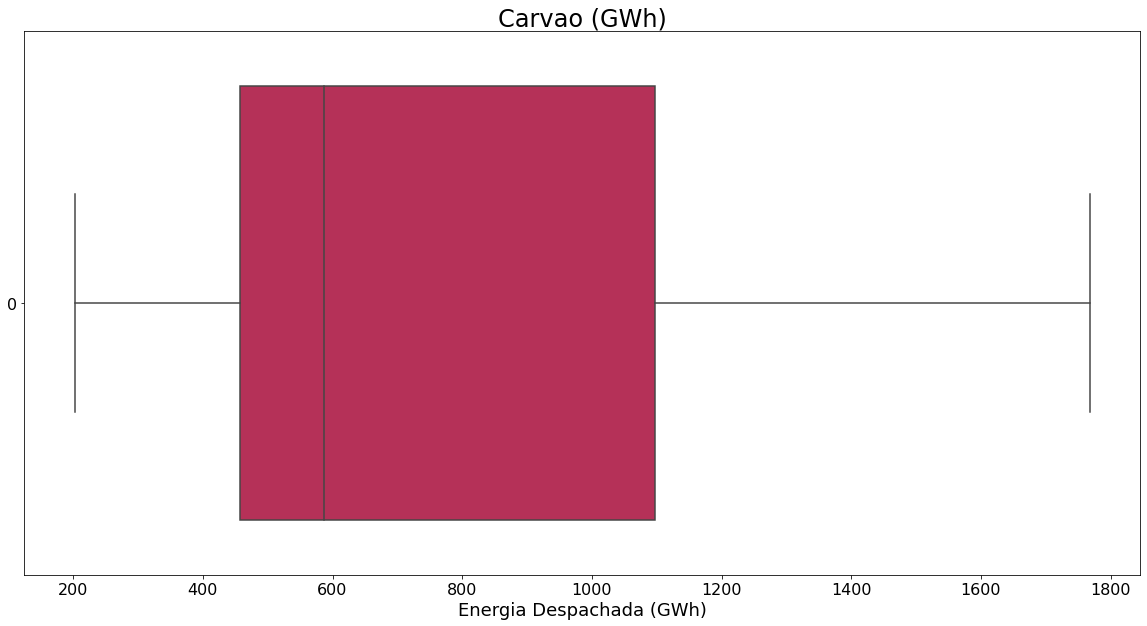

In [37]:
# Boxplot para a Fonte Carvão
carvao_graficos.boxplot()

In [38]:
# Descrição estatística dos dados da Fonte Carvão
carvao_stats.descricao()

Carvao
count   239.000000
mean    766.362197
std     407.083178
min     202.917600
25%     457.089710
50%     586.966700
75%    1097.784513
max    1767.729120

O boxplot demonstra que não há dados discrepantes nessa variável. Também percebe-se que a maior parte dos valores são menores que 600 GWh, com mediana de 586,97 GWh.

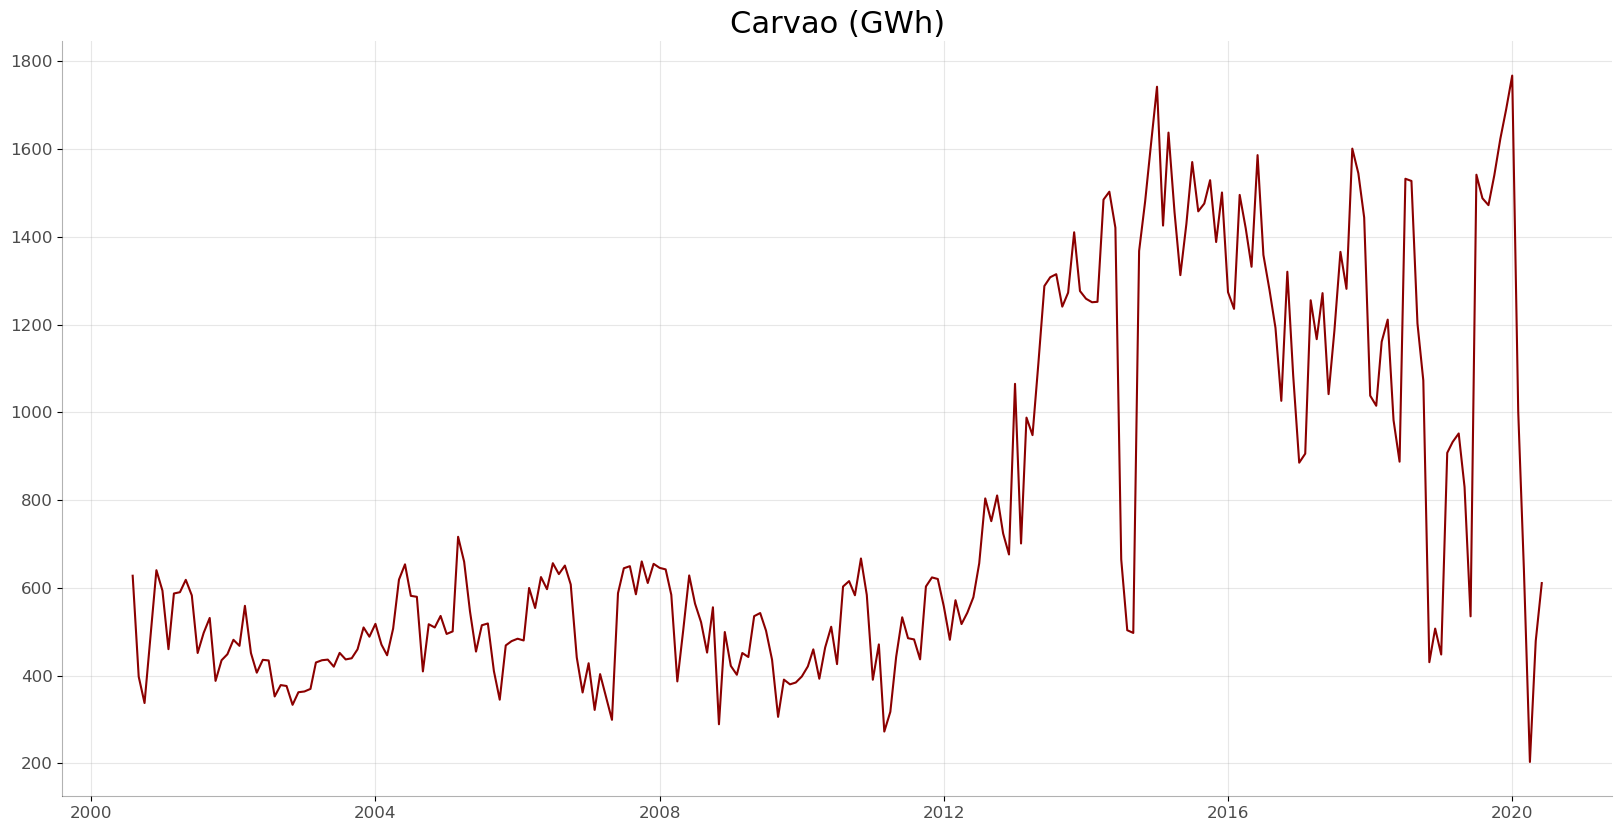

In [39]:
# Lineplot para a Fonte Carvão
carvao_graficos.lineplot()

Nota-se que o valor mensal de Carvão permaneceu oscilou por volta de 300 a 600 GWh de 2000 até 2012, quando passou a ter uma produção cada vez maior. Entretanto, percebeu-se uma forte queda nessa produção no começo de 2020 em um período que coincide com o começo da pandemia de COVID-19 no Brasil.

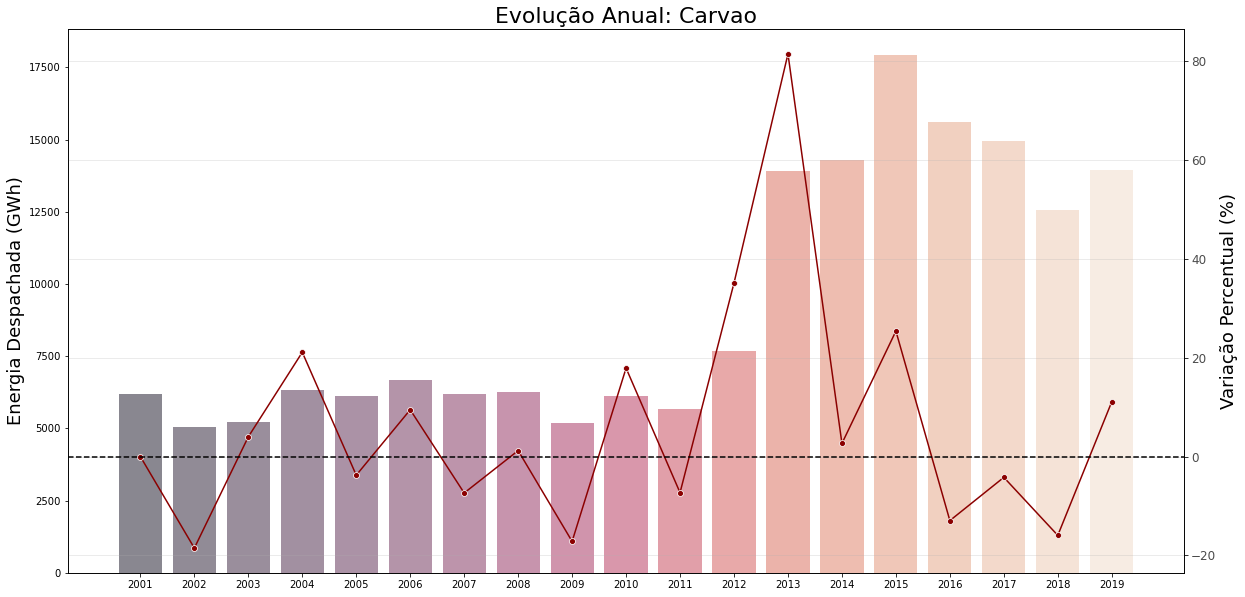

In [40]:
# Gráfico de barras de Produção Energética Anual de Carvão em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
carvao_graficos.mixedplot()

Avaliando a soma anual de produção de Carvão percebe-se que a partir de 2012 ele passou a ter um crescimento acelerado, de quase 40% e que chegou a superar os 80% em 2013, mantendo-se crescente até 2015. Desde então, a produção de Carvão vem caindo anualmente, com 2019 como exceção, embora o começo de 2020 não tenha se mostrado animador para esse setor como o gráfico anterior indicou.

Esse aumento em 2013 ocorreu pelo acionamento de usinas termelétricas nesse período devido à uma redução na capacidade de produção via Hidrelétricas. Dessa forma, o aumento na utilização de usinas à Carvão foi necessário para que o suprimento energético fosse garantido.

Mais detalhes podem ser obtidos através do [Anuário de Energia Elétrica de 2014](https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-160/topico-168/Anu%C3%A1rio%20Estat%C3%ADstico%20de%20Energia%20El%C3%A9trica%202014.pdf), que analisa os dados referentes à 2013.

#### 4.2.2. Gás Natural

Criação dos objetos da Fonte Gás Natural referentes às classes "Nulos", "Stats" e "Graficos".

In [41]:
# Criação do objeto referente à Classe "Nulos" de "Gás Natural"
gas_nulos = Nulos('Gas_Natural', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Gás Natural"
gas_stats = Stats('Gas_Natural', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Gás Natural"
gas_graficos = Graficos('Gas_Natural', dados_limpos, soma, soma_perc)

In [42]:
# Valores iguais à zero da Fonte Gás Natural
gas_nulos.nulos()

Series([], Name: Gas_Natural, dtype: float64)

Não há valores nulos da Fonte Gás Natural, que esteve presente na matriz elétrica brasileira desde o começo do período avaliado pelo dataset.

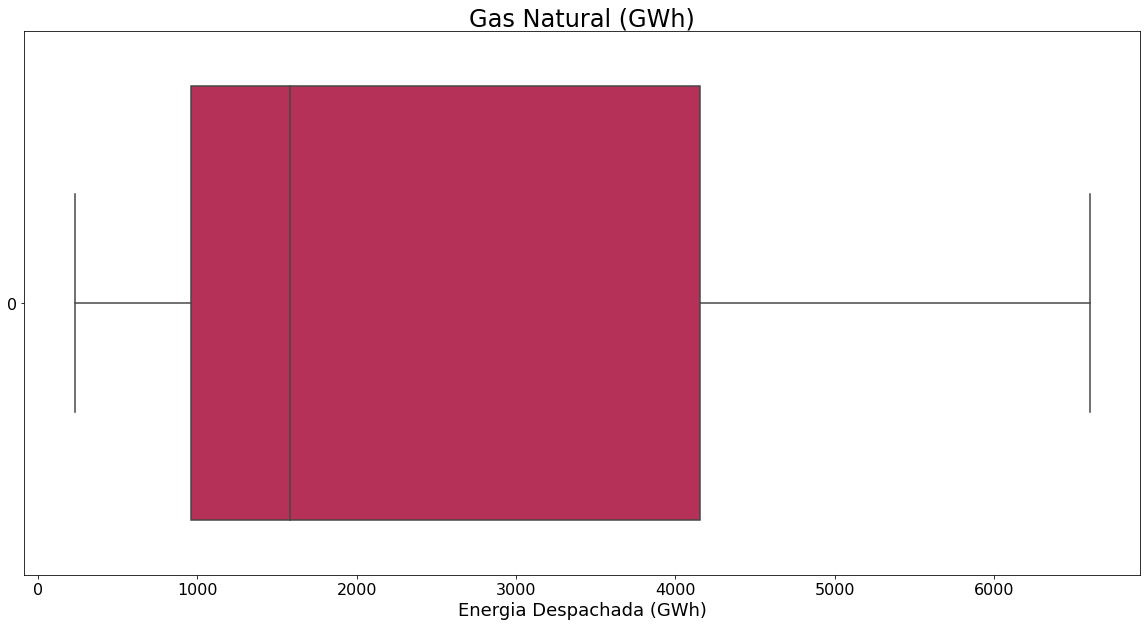

In [43]:
# Boxplot para a Fonte Gás Natural
gas_graficos.boxplot()

In [44]:
# Descrição estatística dos dados da Fonte Gás Natural
gas_stats.descricao()

Gas_Natural
count   239.000000
mean   2505.526768
std    1899.212493
min     231.761470
25%     959.252006
50%    1579.094060
75%    4155.031974
max    6601.548717

Seguindo uma tendência semelhante à demonstrada em Carvão, há uma presença de dados muito maior até o valor de mediana que foi de 1579,09 GWh.

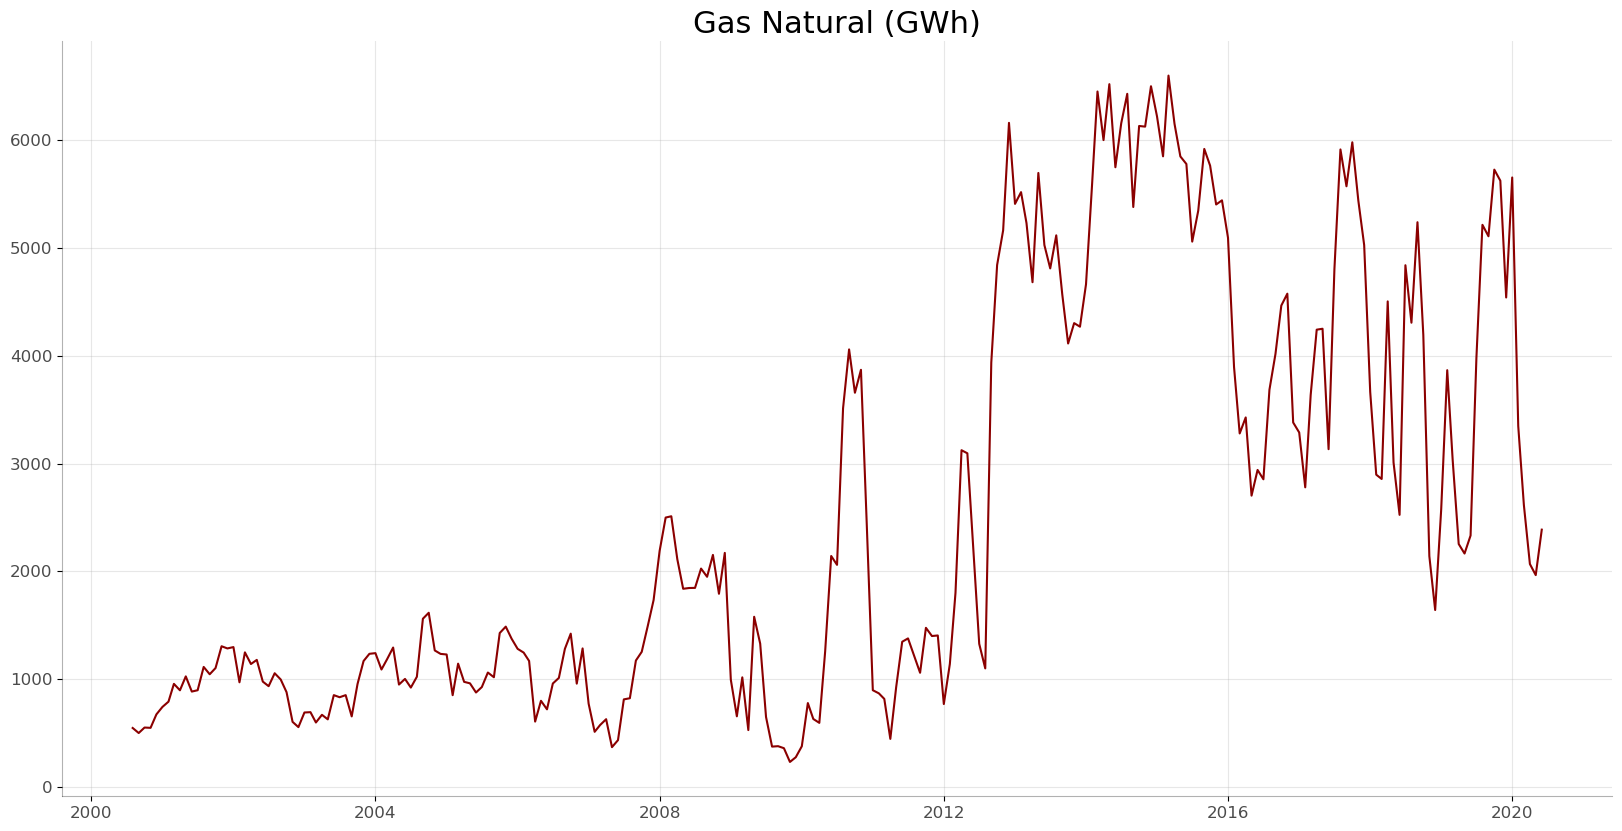

In [45]:
# Lineplot para a Fonte Gás Natural
gas_graficos.lineplot()

A tendência observada para o Gás Natural é semelhante comparada com a de Carvão, embora Gás Natural tenha uma participação maior na Matriz Elétrica Brasileira. Entre 2008 e 2012 houveram dois grandes picos de produção por essa fonte antes do forte crescimento observado posteriormente. 

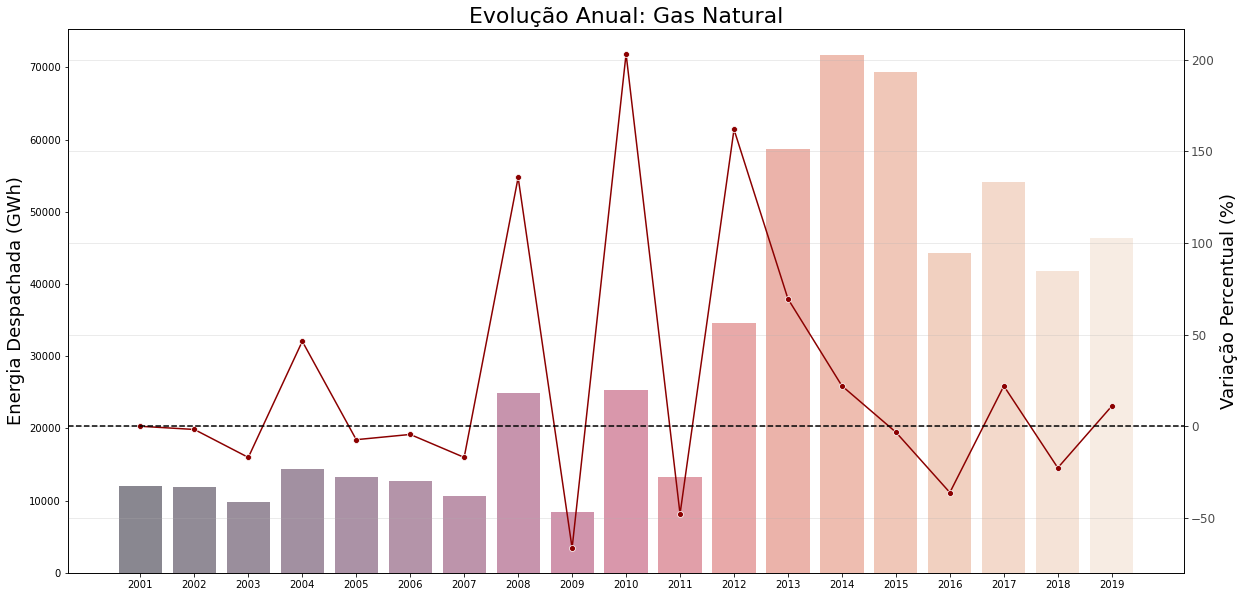

In [46]:
# Gráfico de barras de Produção Energética Anual de Gás Natural em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
gas_graficos.mixedplot()

A fonte Gás Natural manteve um patamar relativamente baixo até 2008, quando passou por oscilações anuais de crescimento até 2012. A partir deste ano, ela manteve-se crescendo até 2014, obteve um platô em 2015 seguido por uma queda de patamar de 2016 em diante, mesmo que bem superior ao observado no começo da série temporal.

Como comentado anteriormente para "Carvão", o Gás Natural também teve um grande uso em Usinas Termelétricas para que minimizasse o efeito da queda na produção de Energia Hidrelétrica.

#### 4.2.3. Nuclear

Criação dos objetos da Fonte Nuclear referentes às classes "Nulos", "Stats" e "Graficos".

In [47]:
# Criação do objeto referente à Classe "Nulos" de "Nuclear"
nuclear_nulos = Nulos('Nuclear', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Nuclear"
nuclear_stats = Stats('Nuclear', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Nuclear"
nuclear_graficos = Graficos('Nuclear', dados_limpos, soma, soma_perc)

In [48]:
# Valores iguais à zero da Fonte Nuclear
nuclear_nulos.nulos()

Series([], Name: Nuclear, dtype: float64)

Não há valores nulos da Fonte Nuclear, que esteve presente na matriz elétrica brasileira desde o começo do período avaliado pelo dataset.

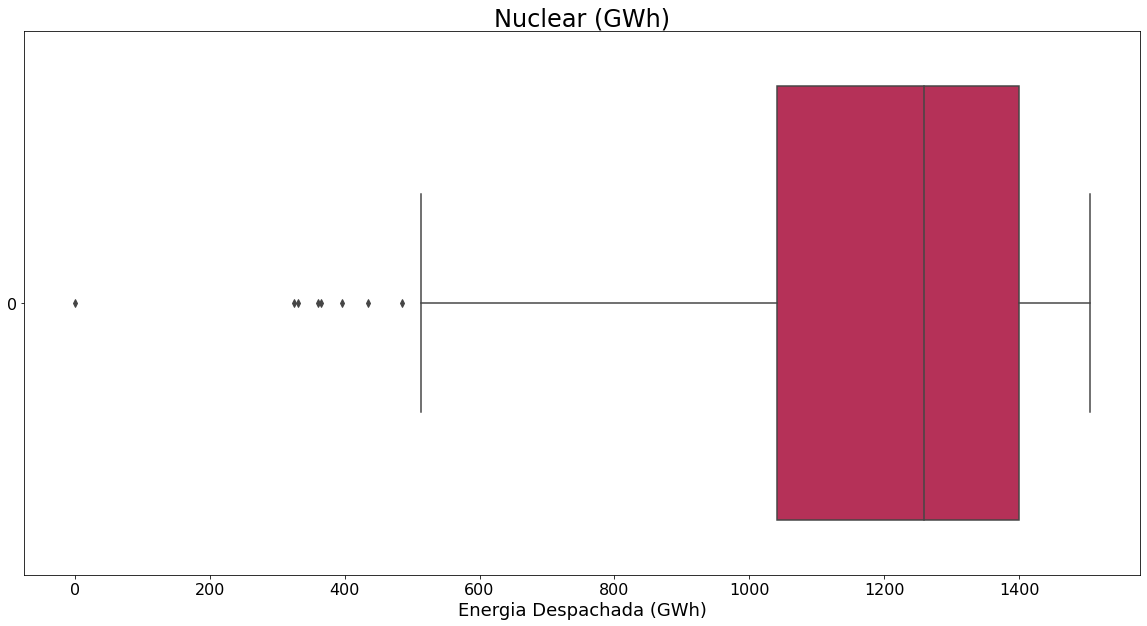

In [49]:
# Boxplot para a Fonte Nuclear
nuclear_graficos.boxplot()

In [50]:
# Descrição estatística dos dados da Fonte Nuclear
nuclear_stats.descricao()

Nuclear
count   239.000000
mean   1178.535241
std     283.941883
min       0.452360
25%    1041.212365
50%    1258.782337
75%    1399.000000
max    1504.327708

In [51]:
# Obtenção dos valores outliers da Fonte Nuclear
nuclear_stats.get_outliers()

Nuclear
date                  
2004-12-01  396.553800
2005-01-01  364.644110
2005-02-01  360.369668
2005-03-01    0.452360
2005-12-01  331.174480
2006-01-01  325.638280
2009-08-01  484.639070
2010-11-01  434.436250

Nota-se que o valor médio (1178,54 GWh) é próximo ao do valor máximo. O boxplot indica a presença de outliers, que são próximos em relação ao limite inferior delimitado pelo boxplot e são mais presentes no ano de 2005, incluindo um valor muito próximo de zero, que provavelmente indica um erro de inserção desse dado (março/2005).

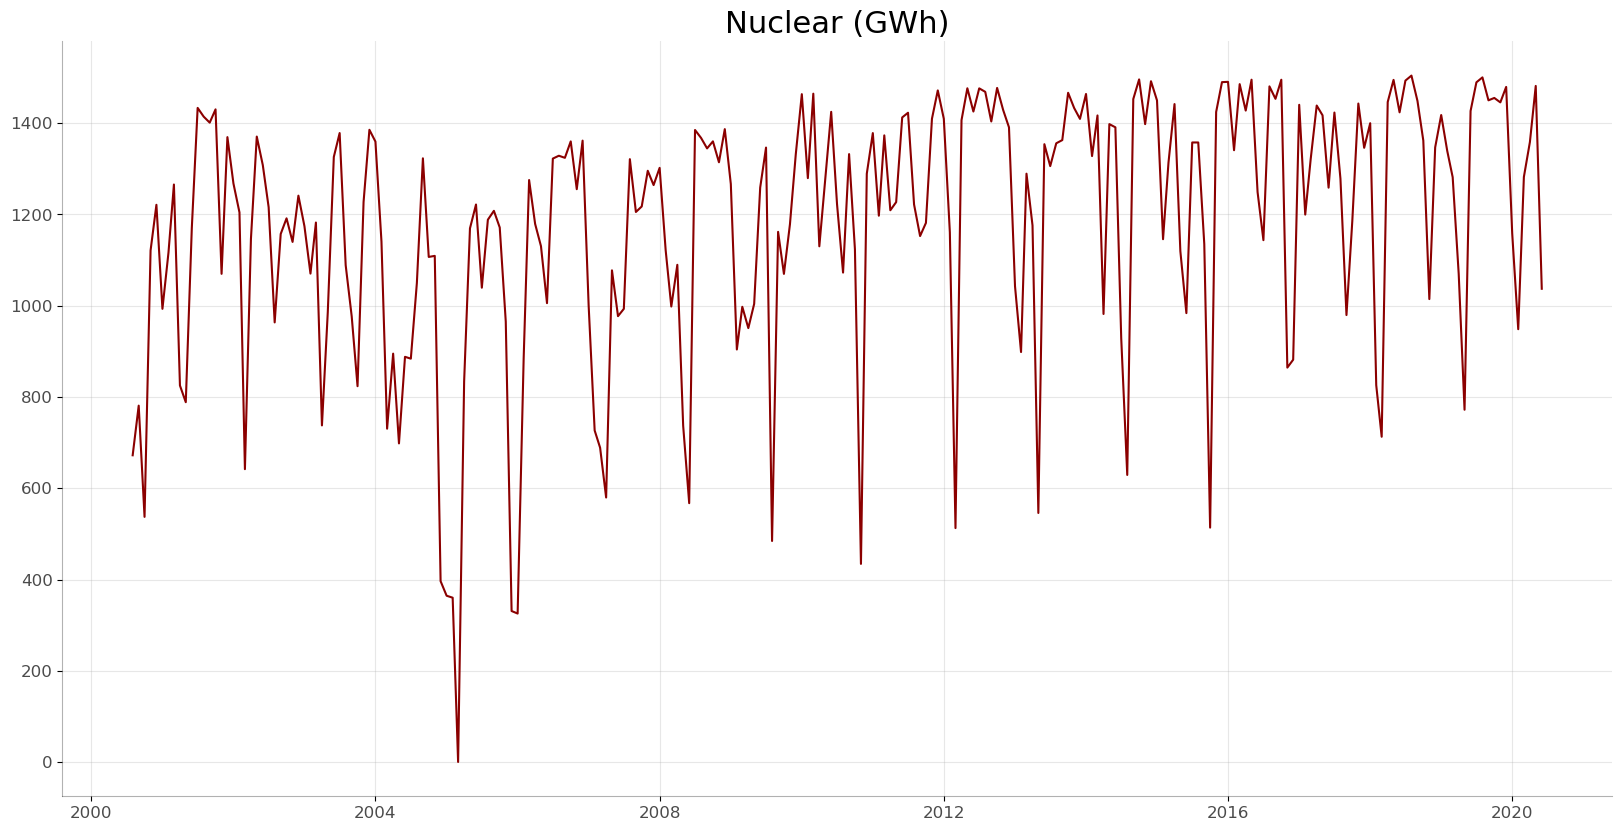

In [52]:
# Lineplot para a Fonte Nuclear
nuclear_graficos.lineplot()

O gráfico de linhas mostra as oscilações periódicas anuais da Energia Nuclear sem observar um grande crescimento ou descréscimo na sua produção de energia ao longo da Série Histórica.

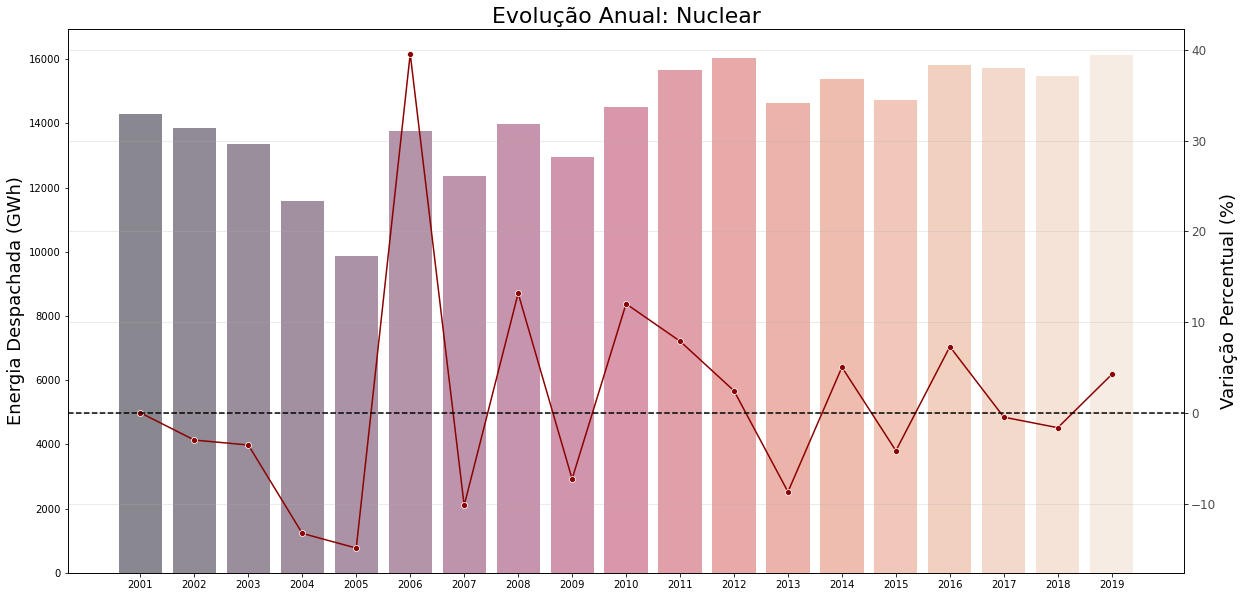

In [53]:
# Gráfico de barras de Produção Energética Anual Nuclear em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
nuclear_graficos.mixedplot()

O histórico de produção nuclear mostra uma queda entre 2001 e 2005 - sendo mais acentuada nesse último - seguida de uma subida no ano subsequente e a manutenção de um patamar semelhante nos anos seguintes, não havendo fortes alterações na sua produção anual.

#### 4.2.4. Óleo

Criação dos objetos da Fonte Óleo Diesel / Óleo Combustível referentes às classes "Nulos", "Stats" e "Graficos".

In [54]:
# Criação do objeto referente à Classe "Nulos" de "Oleo"
oleo_nulos = Nulos('Oleo', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Oleo"
oleo_stats = Stats('Oleo', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Oleo"
oleo_graficos = Graficos('Oleo', dados_limpos, soma, soma_perc)

In [55]:
# Valores iguais à zero da Fonte Óleo Diesel / Óleo Combustível
oleo_nulos.nulos()

date
2006-11-01    0.0
2007-01-01    0.0
Name: Oleo, dtype: float64

Há a presença de duas entradas nulas para Óleo, quase sequenciais. 

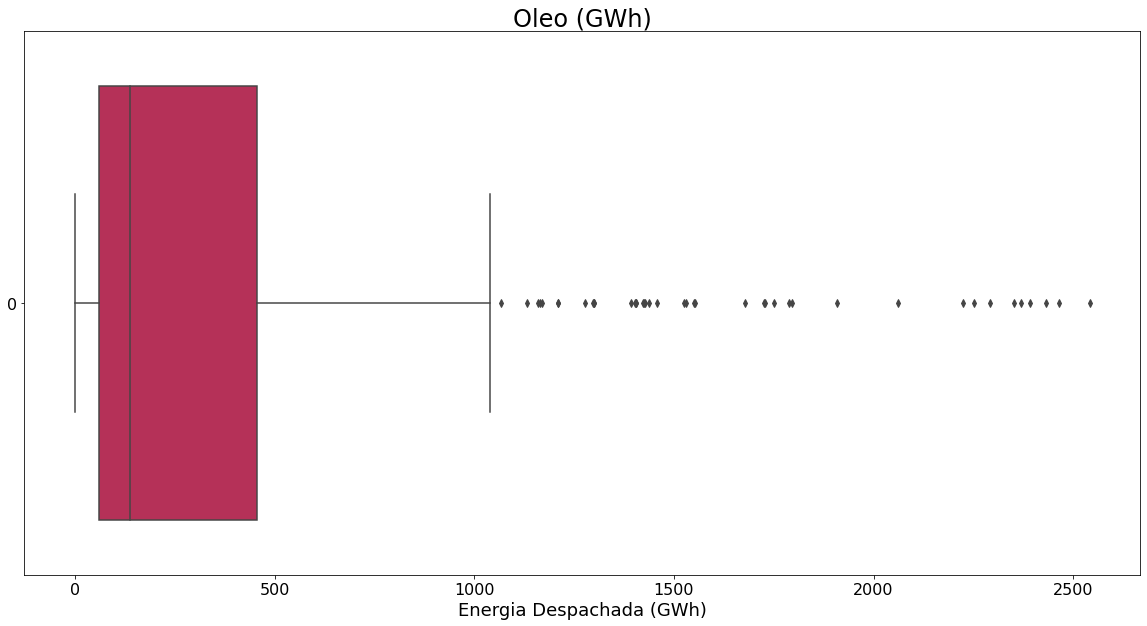

In [56]:
# Boxplot para a Fonte Óleo Diesel / Óleo Combustível
oleo_graficos.boxplot()

In [57]:
# Descrição estatística dos dados da Fonte Óleo Diesel / Óleo Combustível
oleo_stats.descricao()

Oleo
count   237.000000
mean    434.457785
std     614.599474
min       0.010320
25%      60.842540
50%     137.997120
75%     454.471374
max    2541.000000

In [58]:
# Obtenção dos valores outliers da Fonte Óleo Diesel / Óleo Combustível
oleo_stats.get_outliers()

Oleo
date                   
2012-11-01  1795.000000
2012-12-01  2541.000000
2013-01-01  2062.000000
2013-02-01  1402.000000
2013-03-01  1296.000000
2013-04-01  1159.000000
2013-05-01  1423.000000
2013-06-01  1209.000000
2013-10-01  1163.377920
2013-11-01  1298.815200
2014-01-01  1405.000000
2014-02-01  1530.000000
2014-03-01  1428.000000
2014-04-01  1728.000000
2014-05-01  1679.000000
2014-06-01  1392.000000
2014-07-01  1725.231840
2014-08-01  2392.540320
2014-09-01  2368.375200
2014-10-01  2432.000000
2014-11-01  2352.000000
2014-12-01  2224.000000
2015-01-01  2290.660872
2015-02-01  2251.088485
2015-03-01  2463.578453
2015-04-01  1787.984835
2015-05-01  1553.372013
2015-06-01  1908.762083
2015-07-01  1403.895177
2015-08-01  1300.627437
2015-09-01  1276.252176
2015-10-01  1456.579121
2015-11-01  1424.915241
2015-12-01  1208.995205
2016-01-01  1170.168579
2017-08-01  1524.132255
2017-09-01  1549.669409
2017-10-01  1751.471977
2017-11-01  1132.350180
2018-08-01  1437.669610
2018-09-01  1068.028676

O boxplot demonstra a presença de muitos valores outliers, todos acima do valor máximo. Além disso, nota-se que o valor médio (434,46 GWh) é muito próximo ao do terceiro quartil (454,47 GWh) e muito distante do valor máximo do conjunto de dados (2541 GWh). Os valores outliers se concentram a partir do final de 2012, o que indica um forte aumento da sua participação na Matriz Elétrica a partir desse período.

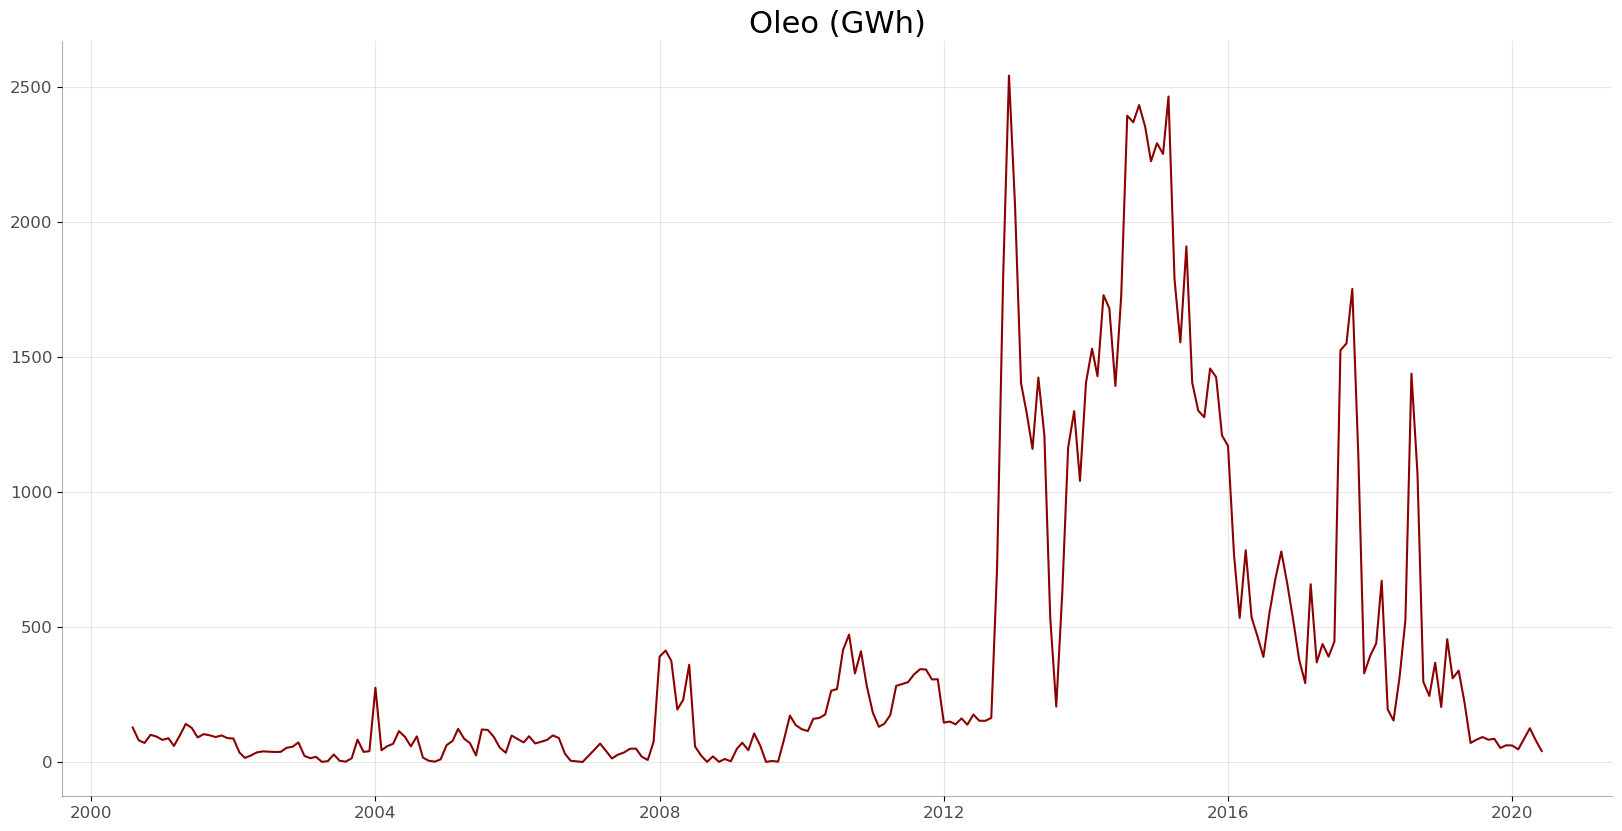

In [59]:
# Lineplot para a Fonte Óleo Diesel / Óleo Combustível
oleo_graficos.lineplot()

É evidente o forte aumento que essa fonte obteve a partir do final de 2012, com valores diversas vezes maiores que o observado anteriormente. Entretando, no final da década nota-se uma queda na produção elétrica por derivados de petróleo.

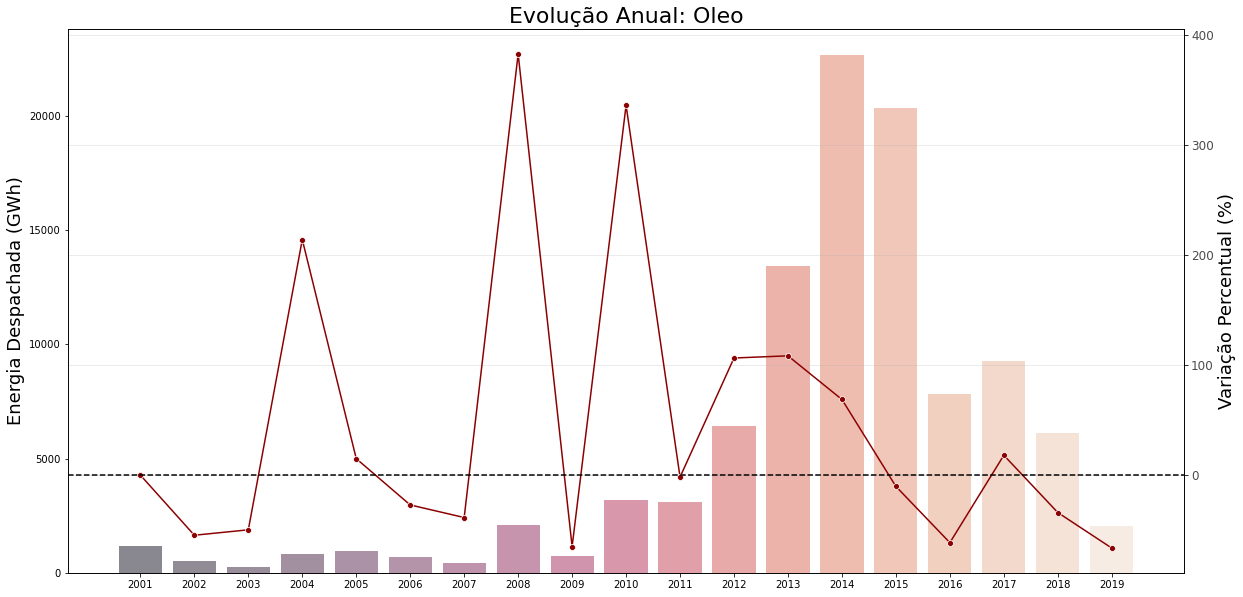

In [60]:
# Gráfico de barras de Produção Energética Anual de Óleo Diesel / Óleo Combustível em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
oleo_graficos.mixedplot()

Até 2009 percebe-se uma participação bem baixa de Óleo Diesel / Óleo Combustível, com destaque para o grande aumento percentual de 2007 para 2008. A partir de 2011 há um aumento próximo ou superior ao de 100% anualmente, com o valor total de 2015 se aproximando de 25000 GWh. Entrentanto, de 2016 em diante nota-se uma forte queda na sua participação, com o valor de 2019 sendo inferior ao observado em 2010 e 2011.

Como explicado anteriormente, a queda da produção de Hidrelétricas gerou a necessidade do acionamento de Termelétricas, incluindo aquelas de Óleo Diesel / Óleo Combustível (derivados de petróleo), o que explica o forte aumento entre 2012 e 2015.

Em 2016 houve um aumento na produção de Energia Hidrelétrica em conjunto com uma retração econômica, o que diminuiu a demanda por energia elétrica. Dessa forma, não foi necessário o acionamento em massa de Usinas Termelétricas - que aumentam a emissão de gases estufa e aumentam o custo da energia. Isso ocasionou a forte queda observada em 2016 para a energia proveniente de Óleo Diesel. Mais detalhes podem ser obtidos através do [Anuário de Energia Elétrica de 2017](https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-160/topico-168/Anuario2017vf.pdf), que analisa os dados referentes à 2016.

Em 2019, a única fonte que teve queda na produção elétrica no SIN foi a proveniente de derivados de petróleo ([Anuário de Energia Elétrica de 2020](https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-160/topico-168/Anu%C3%A1rio%20Estat%C3%ADstico%20de%20Energia%20El%C3%A9trica%202020.pdf)).

#### 4.2.5. Hidrelétricas (exceto Itaipu)

Criação dos objetos da Fonte Hidrelétrica (exceto Itaipu) referentes às classes "Nulos", "Stats" e "Graficos".

In [61]:
# Criação do objeto referente à Classe "Nulos" de "Hidrelétrica (exceto Itaipu)"
hidro_sem_ita_nulos = Nulos('Hidreletricas_exceto_Itaipu', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Hidrelétrica (exceto Itaipu)"
hidro_sem_ita_stats = Stats('Hidreletricas_exceto_Itaipu', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Hidrelétrica (exceto Itaipu)"
hidro_sem_ita_graficos = Graficos('Hidreletricas_exceto_Itaipu', dados_limpos, soma, soma_perc)

In [62]:
# Valores iguais à zero da Fonte Hidrelétrica (exceto Itaipu)
hidro_sem_ita_nulos.nulos()

Series([], Name: Hidreletricas_exceto_Itaipu, dtype: float64)

Não há valores nulos da Fonte Carvão, que esteve presente na matriz elétrica brasileira desde o começo do período avaliado pelo dataset.

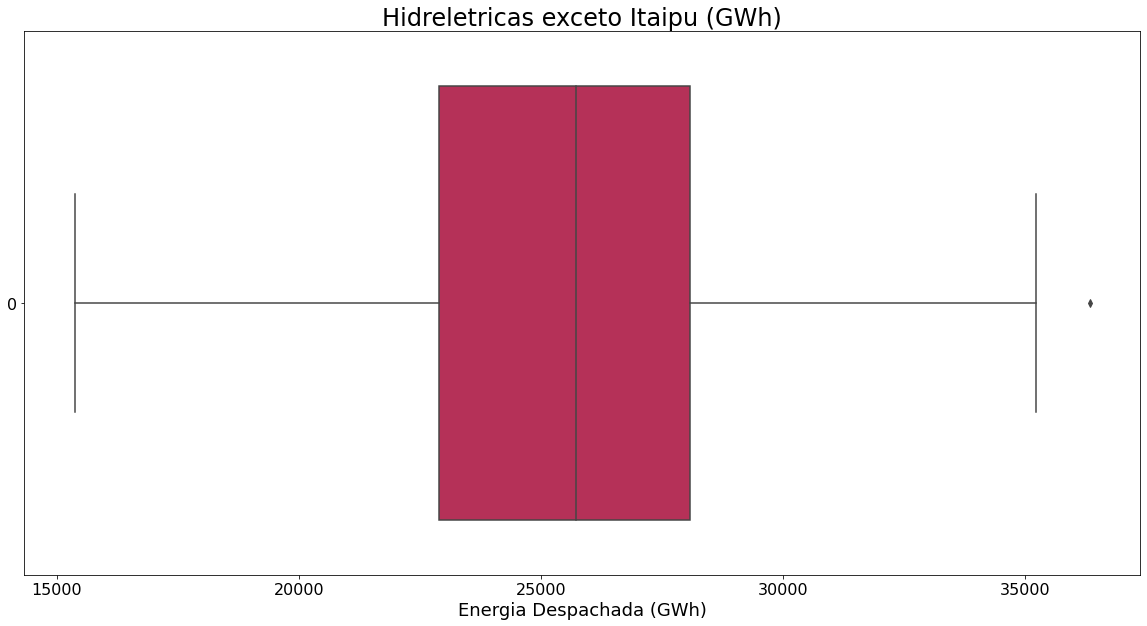

In [63]:
# Boxplot para a Fonte Hidrelétrica (exceto Itaipu)
hidro_sem_ita_graficos.boxplot()

In [64]:
# Descrição estatística dos dados da Fonte Hidrelétrica (exceto Itaipu)
hidro_sem_ita_stats.descricao()

Hidreletricas_exceto_Itaipu
count                   239.000000
mean                  25577.396478
std                    3912.126657
min                   15380.932720
25%                   22895.180114
50%                   25729.470320
75%                   28085.997445
max                   36333.000000

In [65]:
# Obtenção dos valores outliers da Fonte Hidrelétrica (exceto Itaipu)
hidro_sem_ita_stats.get_outliers()

Hidreletricas_exceto_Itaipu
date                                   
2019-01-01                      36333.0

O boxplot indica a presença de um outlier acima do valor máximo, referente ao valor máximo de produção do conjunto de dados (36333 GWh).

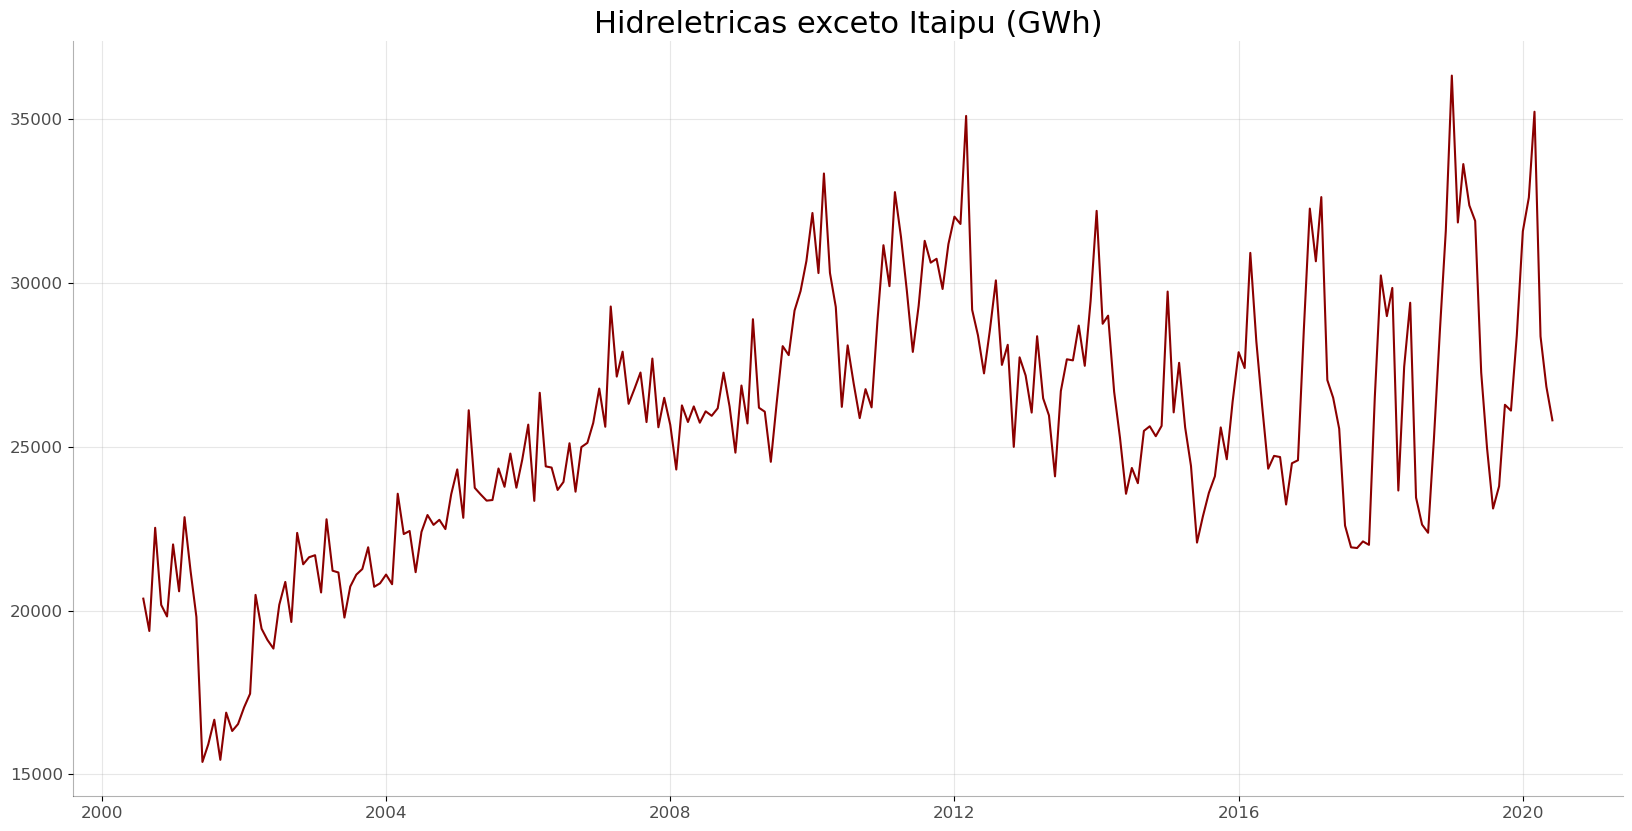

In [66]:
# Lineplot para a Fonte Hidrelétrica (exceto Itaipu)
hidro_sem_ita_graficos.lineplot()

É notável uma forte queda na produção de Hidrelétricas pouco depois do começo da Série Histórica, procedida de um aumento constante na produção dessa fonte até 2012, quando passou a ter uma queda na produção dessa fonte. Logo depois, começou a haver uma retomada do crescimento de produção dessa fonte mas com oscilações cada vez maiores.

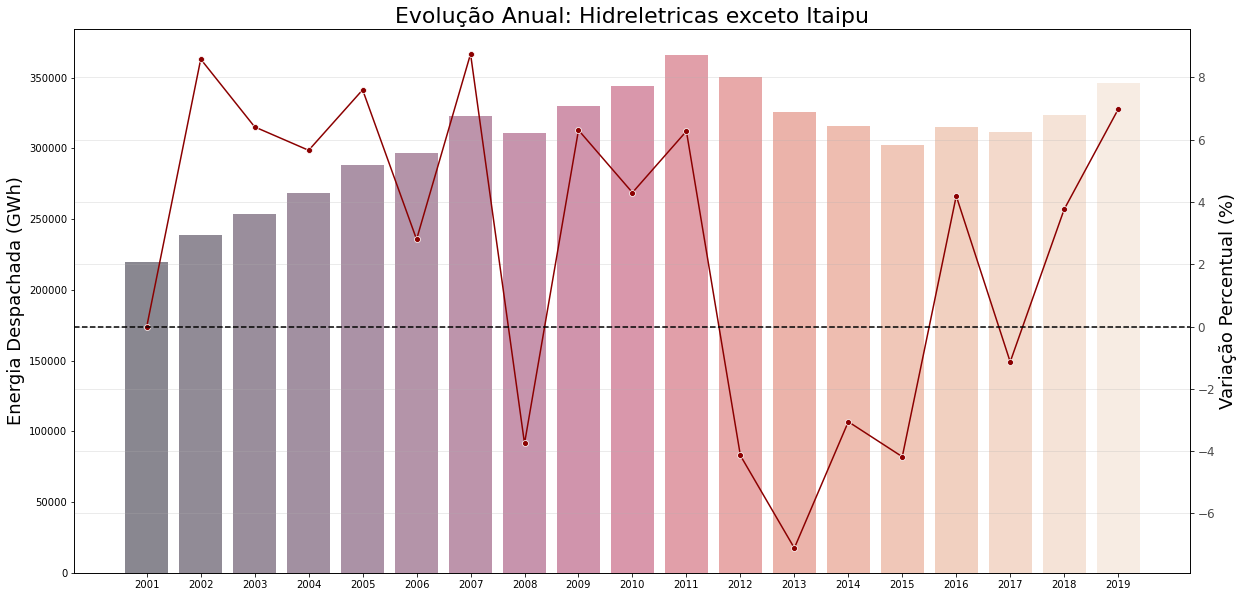

In [67]:
# Gráfico de barras de Produção Energética Anual de Hidrelétricas (exceto Itaipu) em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
hidro_sem_ita_graficos.mixedplot()

Após a queda que ocorreu em 2001, o suprimento energético por Hidrelétricas manteve-se crescendo ano a ano - com exceção de 2008 - até o ápice em 2011. Desde então o suprimento hidrelétrico caiu até 2015 quando passou a subir anualmente até um patamar semelhante ao de 2012.

Um ponto relevante de discussão para a história da Matriz Elétrica Brasileira consiste em compreender o período de queda na produção Hidrelétrica observada entre 2001 e 2002.

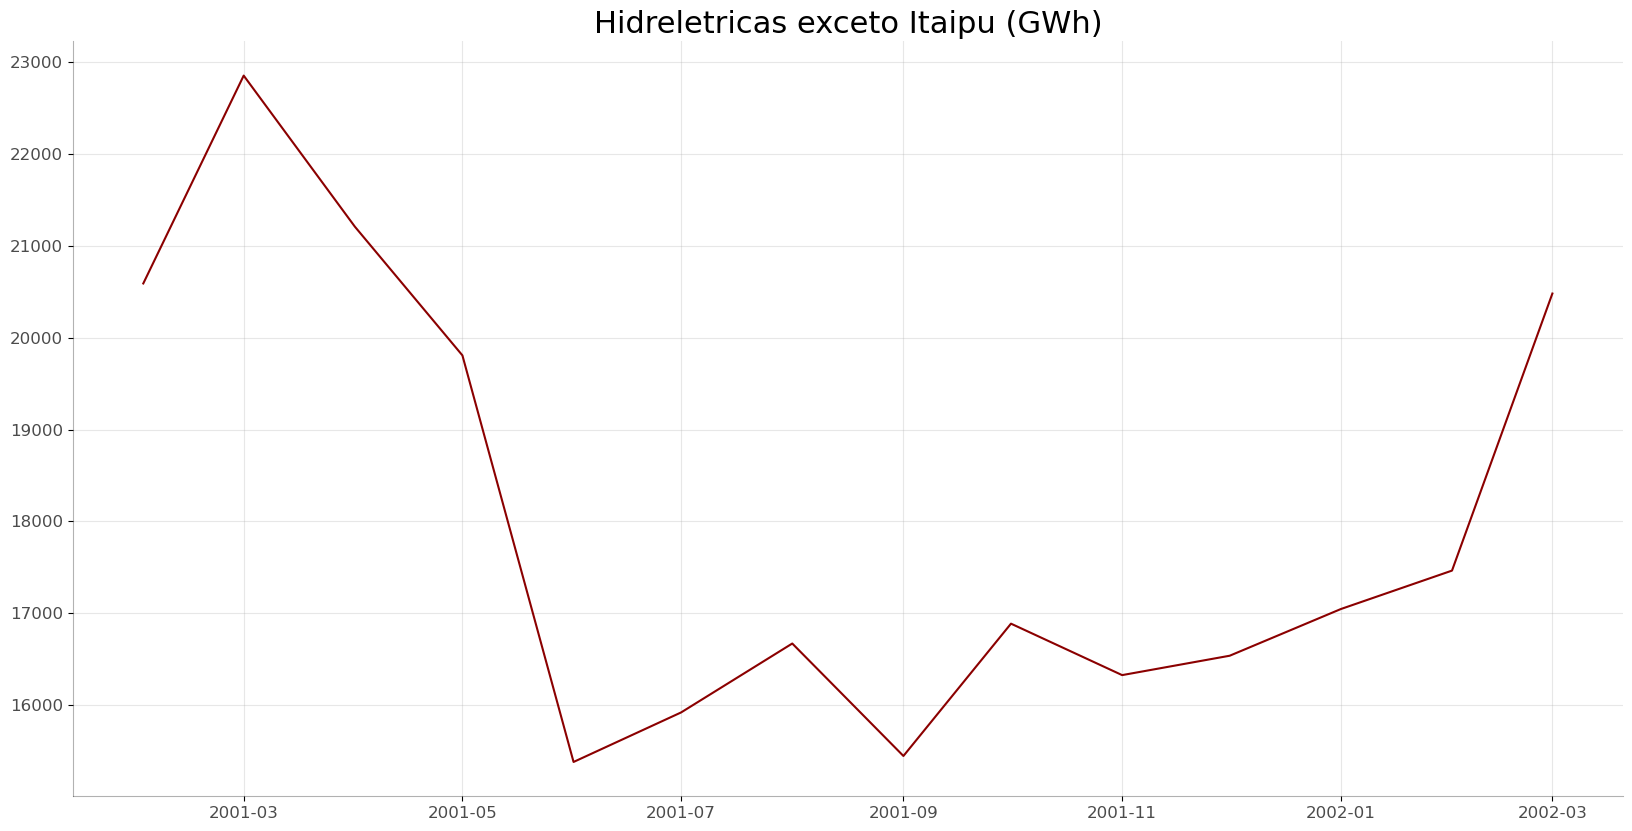

In [68]:
# Criação do objeto referente à Classe "Graficos" de "Hidrelétrica (exceto Itaipu)"
hidro_sem_ita_graficos = Graficos('Hidreletricas_exceto_Itaipu', dados_limpos.loc['02-2001':'03-2002'], soma, soma_perc)

# Lineplot para a Fonte Hidrelétrica (exceto Itaipu) entre fevereiro de 2001 e março de 2002
hidro_sem_ita_graficos.lineplot()

Buscando compreender o que aconteceu em 2001 e 2002, percebe-se que houve um problema de fornecimento de energia hidrelétrica nesse período, ocasionando a "crise do Apagão". Para evitar um colapso do sistema energético, foi adotado um racionamento de energia para as Regiões Sudeste, Nordeste e Centro-Oeste, premiando pessoas que reduziam seus consumos e penalizando quem não o fizesse. O racionamento vigorou entre junho de 2001 e fevereiro de 2002, o que coincide com os dados mostrados no gráfico acima. 

Mais detalhes na matéria que pode ser acessada pelo [link](https://www.nexojornal.com.br/expresso/2021/05/31/Como-a-crise-atual-do-setor-el%C3%A9trico-se-compara-a-2001).

O principal motivo para a crise foi a forma como a Matriz Elétrica Brasileira falhou na sua expansão e na sua diversificação. Houve um aumento de 49% no consumo de energia elétrica durante a década de 1990 e expansão da capacidade instalada em apenas 35%, que, em conjunto com regime pluviométrico abaixo da média, esvaziou os reservatórios hídricos ano após ano. Consequentemente, isso propiciou um forte racionamento de energia, evidenciando os problemas de uma matriz energética pouco diversificada e com expansão em ritmo incompatível com o aumento do consumo. 

Para mais detalhes sobre o problema vivido na época, recomendo a leitura desse artigo escrito por Mauricio Tolmasquim que pode ser acessado por esse [link](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1414-753X2000000100012&lng=pt&tlng=pt).

Sobre a queda de produção ocorrida na primeira metade da década de 2010, ela ocorreu pelo baixo nível nos reservatórios das hidrelétricas. Para minimizar o efeito, foram acionadas Usinas Termelétricas como discutido em outros tópicos. 

#### 4.2.6. Itaipu

Criação dos objetos da Usina de Itaipu referentes às classes "Nulos", "Stats" e "Graficos".

In [69]:
# Criação do objeto referente à Classe "Nulos" de "Itaipu"
itaipu_nulos = Nulos('Itaipu', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Itaipu"
itaipu_stats = Stats('Itaipu', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Itaipu"
itaipu_graficos = Graficos('Itaipu', dados_limpos, soma, soma_perc)

In [70]:
# Valores iguais à zero da Usina de Itaipu
itaipu_nulos.nulos()

Series([], Name: Itaipu, dtype: float64)

Não há valores nulos referentes à Usina de Itaipu, que esteve presente na matriz elétrica brasileira desde o começo do período avaliado pelo dataset.

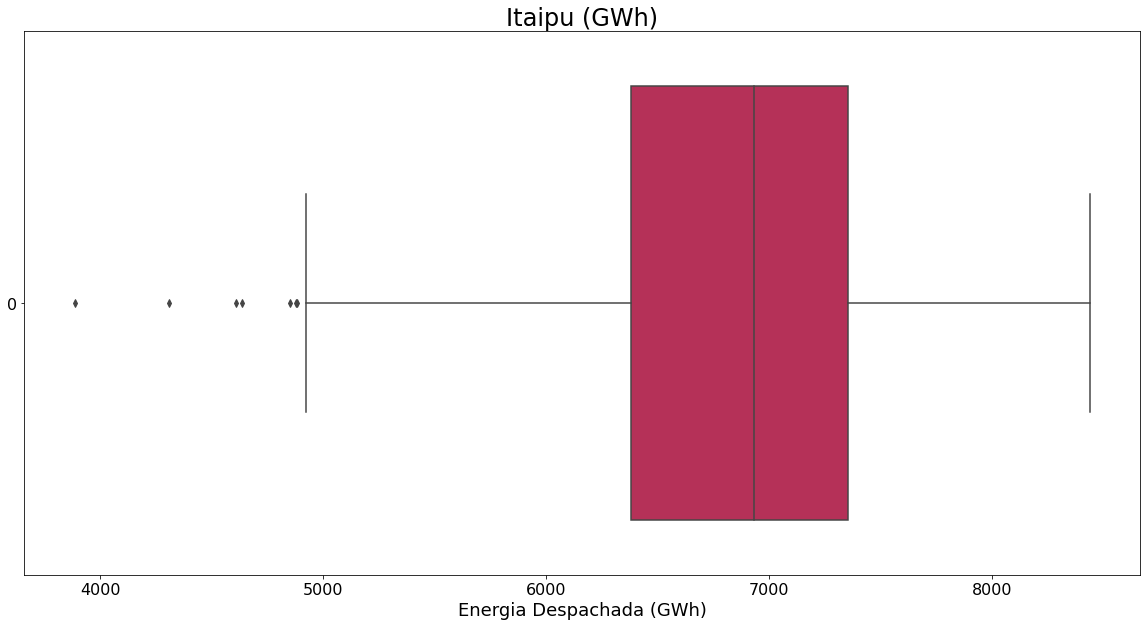

In [71]:
# Boxplot para a Usina de Itaipu
itaipu_graficos.boxplot()

In [72]:
# Descrição estatística dos dados da Usina de Itaipu
itaipu_stats.descricao()

Itaipu
count   239.000000
mean   6783.368649
std     797.185441
min    3886.149600
25%    6379.981448
50%    6930.813283
75%    7355.470780
max    8438.224800

In [73]:
# Obtenção dos valores outliers da Usina de Itaipu
itaipu_stats.get_outliers()

Itaipu
date                   
2001-08-01  4881.657200
2019-05-01  4851.214369
2019-06-01  4608.119896
2019-08-01  4875.402240
2020-04-01  3886.149600
2020-05-01  4636.898160
2020-06-01  4308.249600

O boxplot demonstra a presença de outliers para valores de abaixo do valor mínimo. Inclusive, nota-se que a distância entre o valor mínimo do conjunto de dados (3886,15 GWh) e o referente ao quartil inferior (6379,89 GWh) é maior que entre o quartil inferior e o valor máximo (8438,22 GWh). Isso pode indicar a presença de valores anormalmente muito baixos de produção, que serão demonstrados pelos outliers. Entre os valores outliers, com exceção do primeiro valor - referente à agosto/2001, no auge da "crise do Apagão" - todos os valores ocorreram a partir de maio/2019, o que pode indicar uma mínima histórica de produção da Usina de Itaipu.

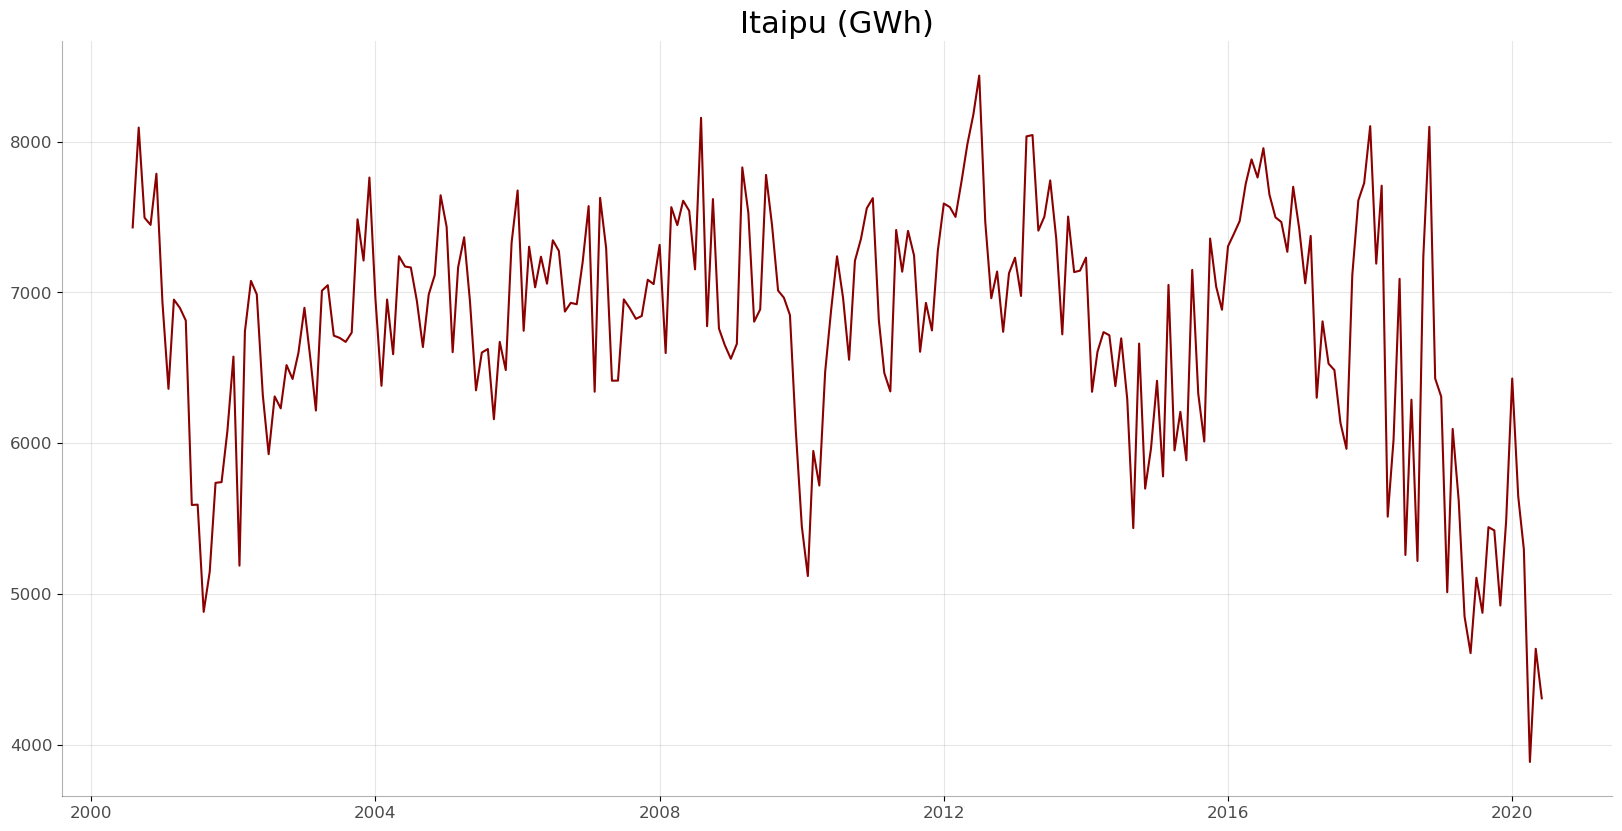

In [74]:
# Lineplot para a Usina de Itaipu
itaipu_graficos.lineplot()

O gráfico de linha mostra que a queda ocorrida em 2001 - que afetou outras usinas Hidrelétricas - também atingiu Itaipu. Além disso, há a presença de um ponto de mínimo destacado entre 2008 e 2012, além da queda de produção referente à crise hídrica do meio da década de 2010. Entretanto, comparando com outras Hidrelétricas se destaca a forte queda de produção por essa usina nos últimos meses.

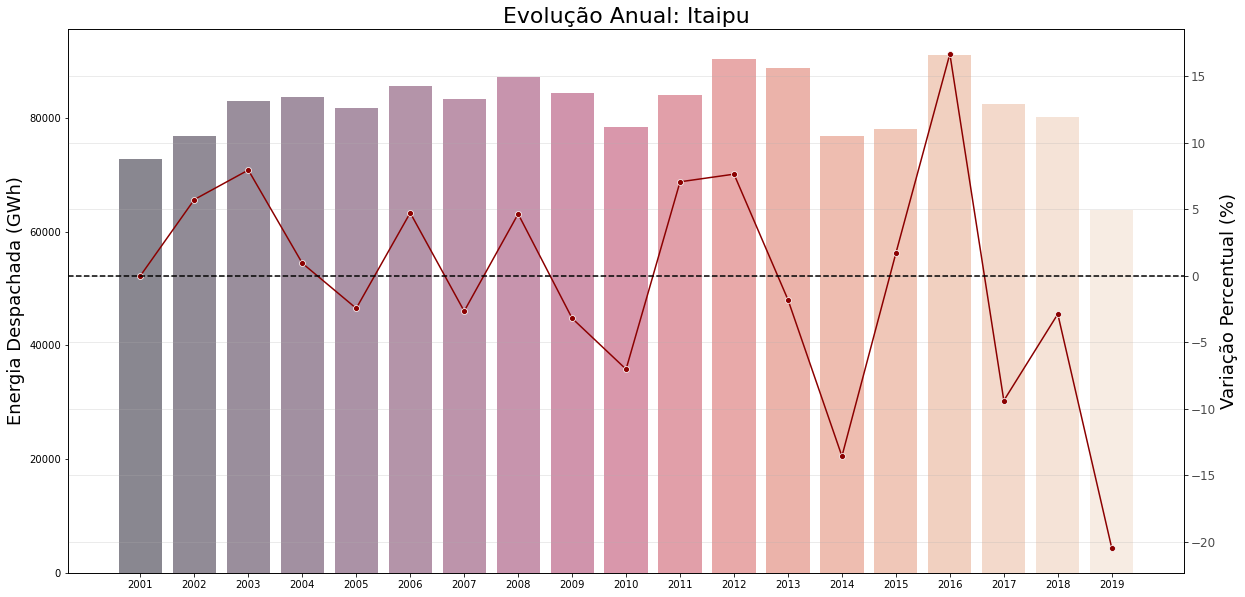

In [75]:
# Gráfico de barras de Produção Energética Anual Nuclear em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
itaipu_graficos.mixedplot()

Nota-se que a produção de Itaipu manteve-se sem grandes variações entre 2001 e 2013. Entretanto, a produção de Itaipu sofreu com os efeitos da crise hídrica em 2014 e 2015 com queda superior à 10%, sendo compensada pelo maior valor de produção histórica de Itaipu em 2016.

Entretanto, em 2019 Itaipu sofreu a sua maior queda de produção histórica, chegando a cair mais do que 20% em comparação com os dados de 2018. Isso ocorreu pela seca que atingiu a bacia do Rio Paraná - mais importante rio para a Usina de Itaipu - sendo o seu pior ano desde o início da operação da Usina, em 1984.
Mais detalhes podem ser obtidos através do [link](https://www.itaipu.gov.br/sites/default/files/af_df/RELATORIO_ANUAL_ITAIPU_2019.pdf).

#### 4.2.7. Biomassas

Criação dos objetos da Fonte Biomassas referentes às classes "Nulos", "Stats" e "Graficos".

In [76]:
# Criação do objeto referente à Classe "Nulos" de "Biomassas"
biomassas_nulos = Nulos('Biomassas', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Biomassas"
biomassas_stats = Stats('Biomassas', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Biomassas"
biomassas_graficos = Graficos('Biomassas', dados_limpos, soma, soma_perc)

In [77]:
# Valores iguais à zero da Fonte Biomassas
biomassas_nulos.nulos()

date
2000-08-01    0.0
2000-09-01    0.0
2000-10-01    0.0
2000-11-01    0.0
2000-12-01    0.0
             ... 
2010-02-01    0.0
2010-03-01    0.0
2010-04-01    0.0
2011-01-01    0.0
2011-02-01    0.0
Name: Biomassas, Length: 92, dtype: float64

Há 92 valores nulos de Biomassas, o que indica uma inserção tardia dessa fonte no SIN. Dessa forma, serão analisados apenas os valores não nulos dessa fonte.

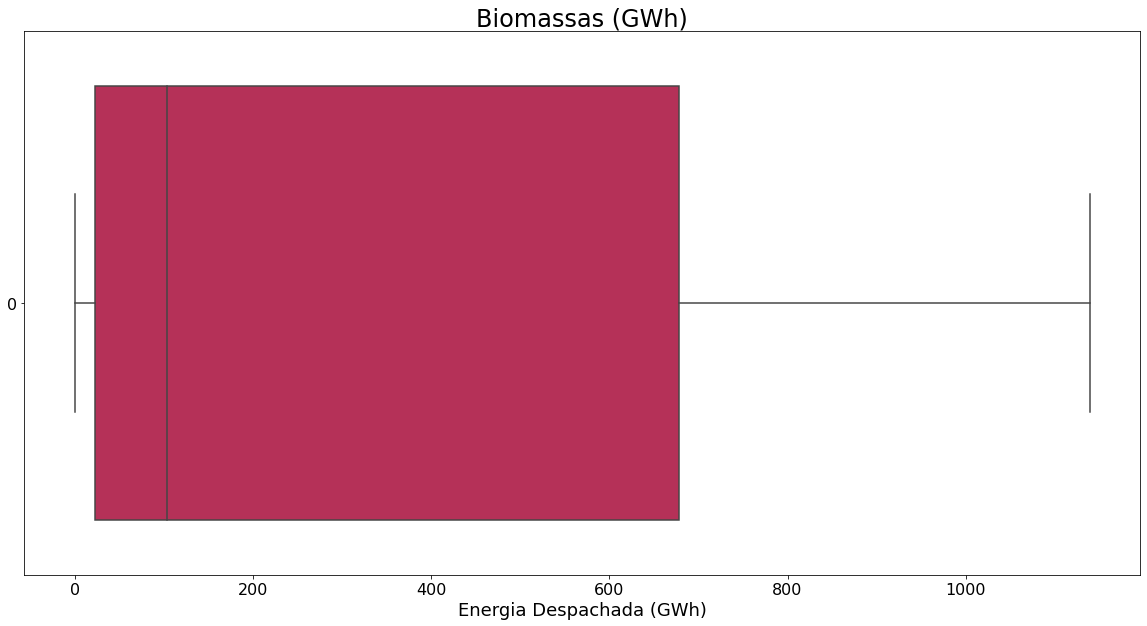

In [78]:
# Boxplot para a Fonte Biomassas
biomassas_graficos.boxplot()

In [79]:
# Descrição estatística dos dados da Fonte Biomassas
biomassas_stats.descricao()

Biomassas
count   147.000000
mean    328.227312
std     375.671451
min       0.000420
25%      22.010410
50%     103.171432
75%     678.562930
max    1139.163984

O boxplot de Biomassas não mostra a presença de outliers, somando-se 147 valores não nulos. Nota-se o alto valor de desvio padrão - muito acima do valor da mediana - e a baixa predominância de dados à partir da mediana.

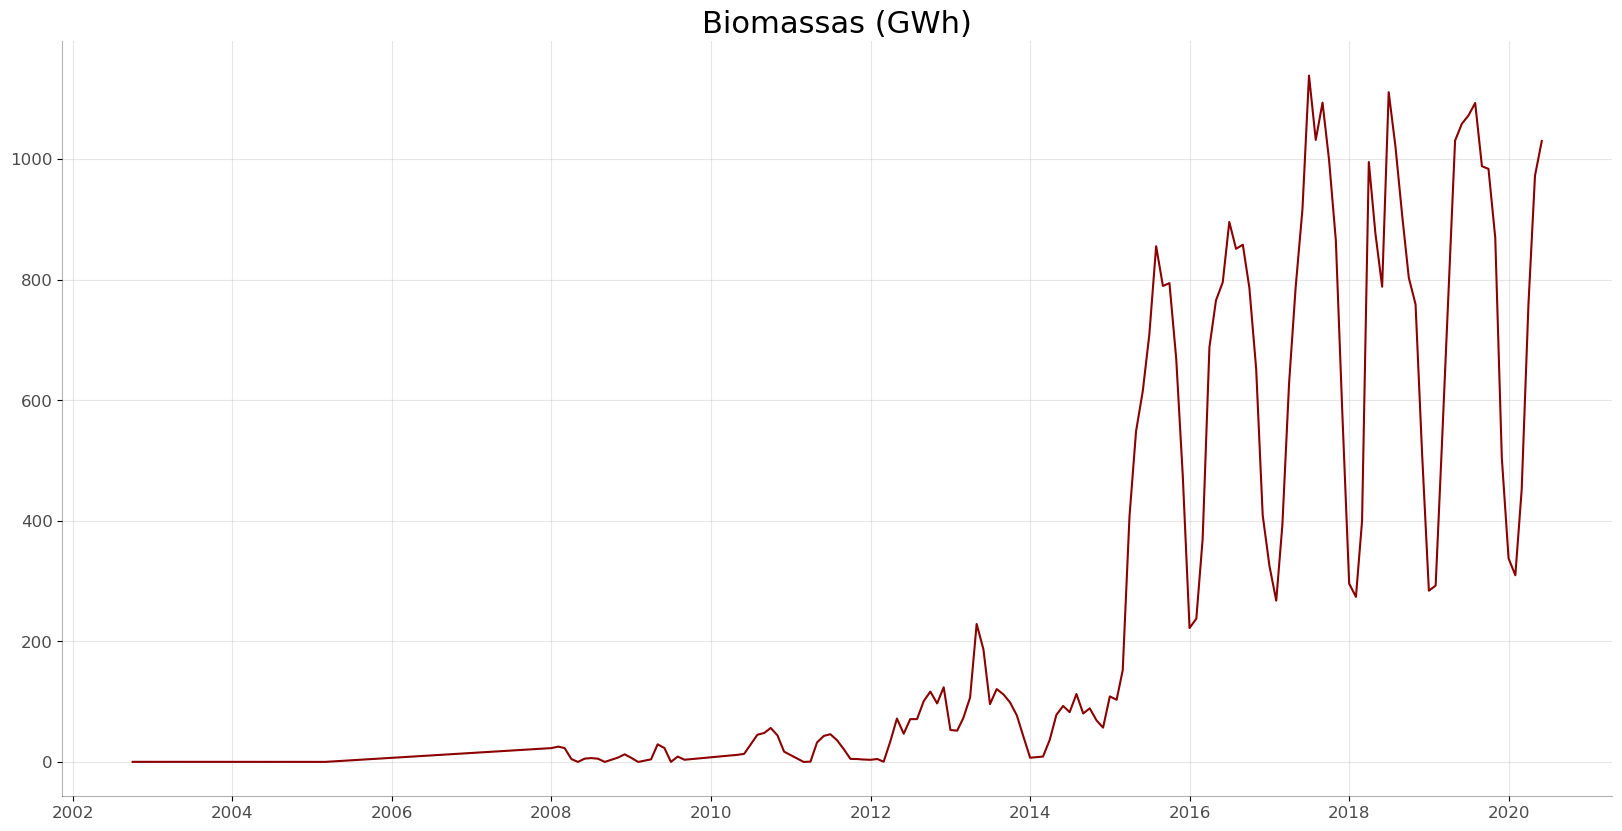

In [80]:
# Lineplot para a Fonte Biomassas
biomassas_graficos.lineplot()

O gráfico de linhas mostra que Biomassas possuía uma participação pouco significativa até 2012, quando passou a ter valores maiores de produção, destacando-se o período pouco depois de 2014, quando a produção energética de Biomassas teve um salto de patamar muito grande. Nota-se também a presença de oscilações sazonais muito grandes para essa fonte.

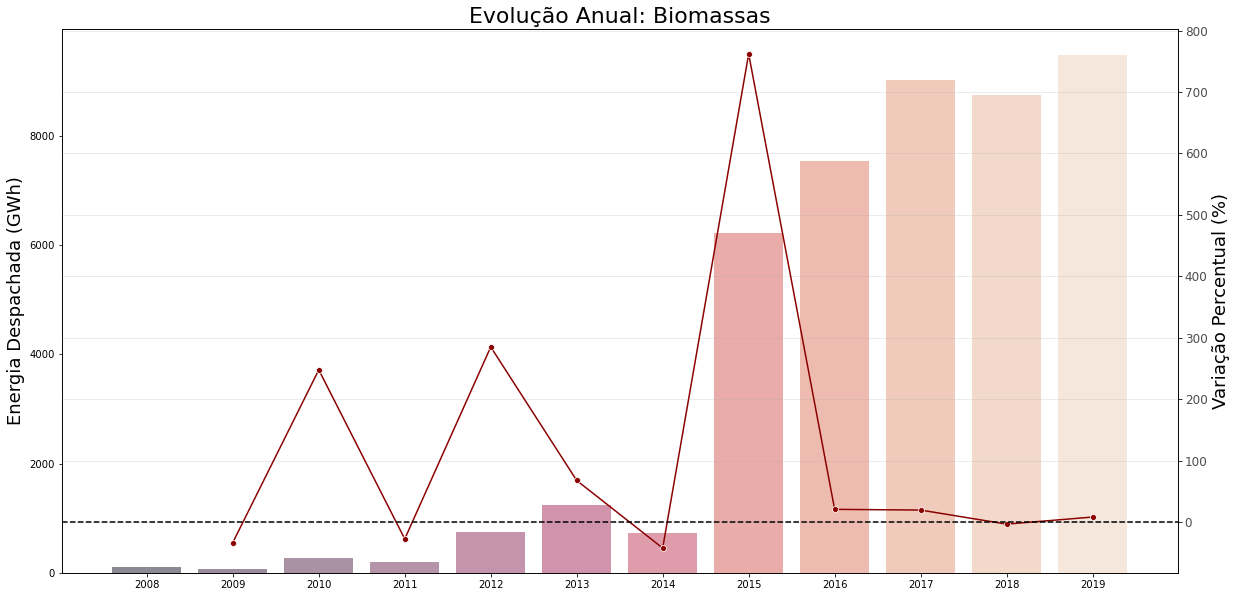

In [81]:
# Gráfico de barras de Produção Energética Anual de Biomassas em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
biomassas_graficos.mixedplot()

Nota-se o gigantesco aumento dessa fonte no SIN na última década, com destaque para o crescimento de 2014 para 2015 que chegou a quase 800%. Desde então o crescimento tem sido menos acentuado, porém contínuo, com 2018 sendo a única exceção, onde houve uma ligeira queda.

#### 4.2.8. Eólicas

Criação dos objetos da Fonte Eólicas referentes às classes "Nulos", "Stats" e "Graficos".

In [82]:
# Criação do objeto referente à Classe "Nulos" de "Eolicas"
eolicas_nulos = Nulos('Eolicas', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Eolicas"
eolicas_stats = Stats('Eolicas', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Eolicas"
eolicas_graficos = Graficos('Eolicas', dados_limpos, soma, soma_perc)

In [83]:
# Valores iguais à zero da Fonte Eólica
eolicas_nulos.nulos()

date
2000-08-01    0.0
2000-09-01    0.0
2000-10-01    0.0
2000-11-01    0.0
2000-12-01    0.0
             ... 
2005-12-01    0.0
2006-01-01    0.0
2006-02-01    0.0
2006-03-01    0.0
2006-04-01    0.0
Name: Eolicas, Length: 69, dtype: float64

Há a presença de 69 valores nulos de Energia Eólica, o que indica a ausência dessa fonte na Matriz Elétrica. Dessa forma, serão utilizados somente os valores superiores à zero para as futuras análises.

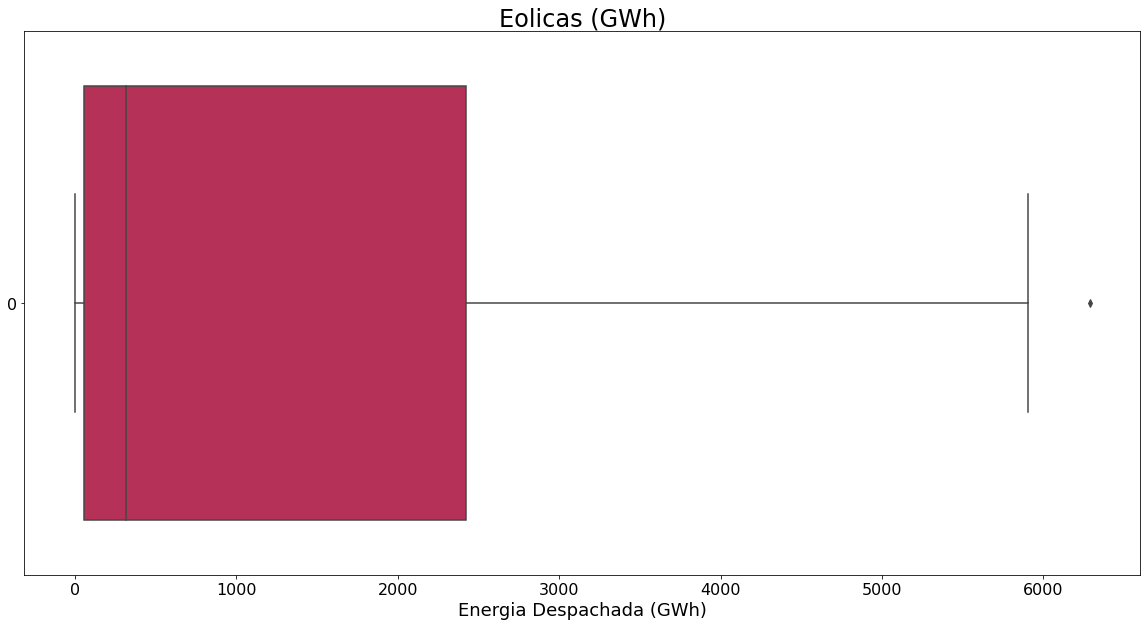

In [84]:
# Boxplot para a Fonte Eólica
eolicas_graficos.boxplot()

In [85]:
# Descrição estatística dos dados da Fonte Eólica
eolicas_stats.descricao()

Eolicas
count   170.000000
mean   1326.756472
std    1673.282514
min       0.255139
25%      56.829084
50%     318.719295
75%    2421.498326
max    6287.179440

In [86]:
# Obtenção dos valores outliers da Fonte Eólica 
eolicas_stats.get_outliers()

Eolicas
date                  
2019-08-01  6287.17944

O boxplot indica a presença de um outlier acima do valor máximo. Há a presença de 170 dados nessa seleção, com baixa predominância de dados superiores à mediana, o que indica baixa presença desses. O único outlier se encontra em agosto de 2019, logo, por ser um valor recente e não muito distante do valor máximo indicado pelo boxplot, pode ser um indício de uma expansão recente dessa fonte na Matriz Elétrica.

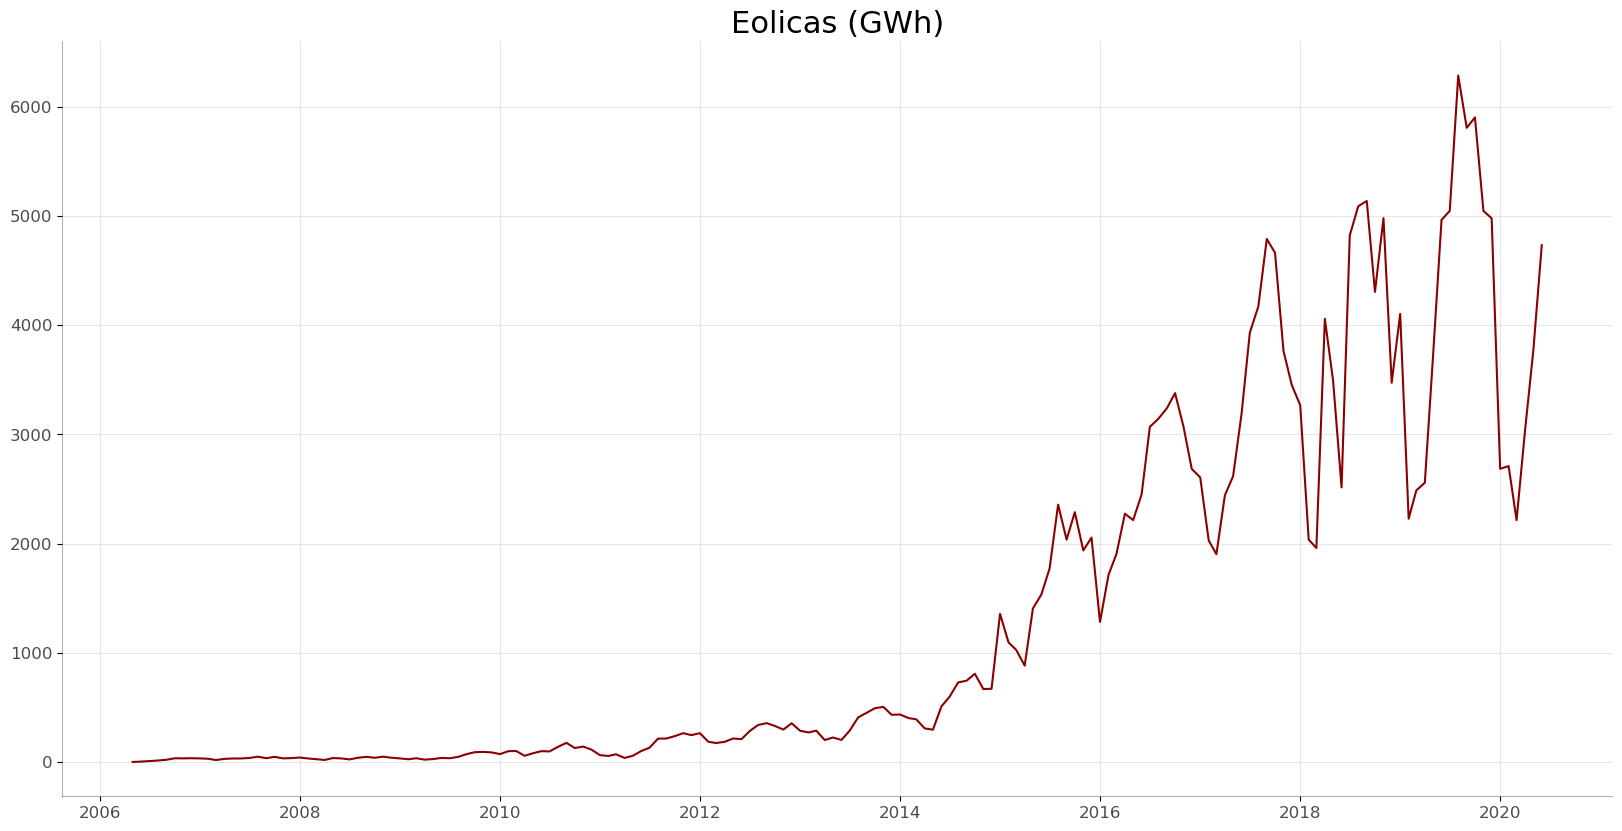

In [87]:
# Lineplot para a Fonte Eólica
eolicas_graficos.lineplot()

O gráfico de linhas mostra o crescimento exponencial da Fonte Eólica na Matriz Brasileira, acentuando-se a partir 2014. É notável a presença de fortes oscilações sazonais para a produção dessa fonte.

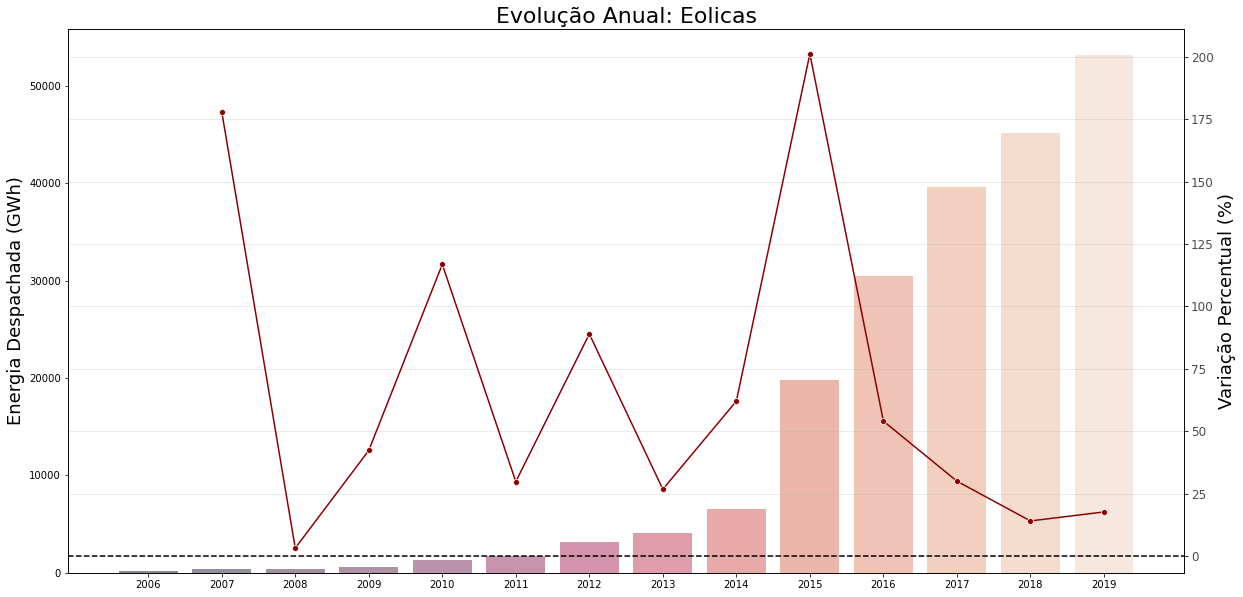

In [88]:
# Gráfico de barras de Produção Energética Anual Eólica em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
eolicas_graficos.mixedplot()

A partir do gráfico acima percebe-se a contínua expansão dessa fonte na Matriz Elétrica, visto que não houve nenhum valor com crescimento percentual menor ou igual à zero. Os maiores picos de crescimento aconteceram em 2010, 2012 e 2015 - sendo esse o mais acentuado - com valor de aproximadamente de 200% comparando com o ano anterior. Posteriormente houve uma desaceleração desse crescimento, embora obtendo valores próximos aos 20% de expansão anual.

#### 4.2.9. Solar Fotovoltaica

Criação dos objetos da Fonte Solar Fotovoltaica referentes às classes "Nulos", "Stats" e "Graficos".

In [89]:
# Criação do objeto referente à Classe "Nulos" de "Solar Fotovoltaica"
solar_nulos = Nulos('Solar_Fotovoltaica', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Solar Fotovoltaica"
solar_stats = Stats('Solar_Fotovoltaica', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Solar Fotovoltaica"
solar_graficos = Graficos('Solar_Fotovoltaica', dados_limpos, soma, soma_perc)

In [90]:
# Valores iguais à zero da Fonte Solar Fotovoltaica
solar_nulos.nulos()

date
2000-08-01    0.0
2000-09-01    0.0
2000-10-01    0.0
2000-11-01    0.0
2000-12-01    0.0
             ... 
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
2017-05-01    0.0
2017-06-01    0.0
Name: Solar_Fotovoltaica, Length: 203, dtype: float64

Há a presença de 203 valores nulos dessa fonte, o que indica sua inserção tardia ao SIN. Portanto, serão utilizados somente seus valores não-nulos para análise.

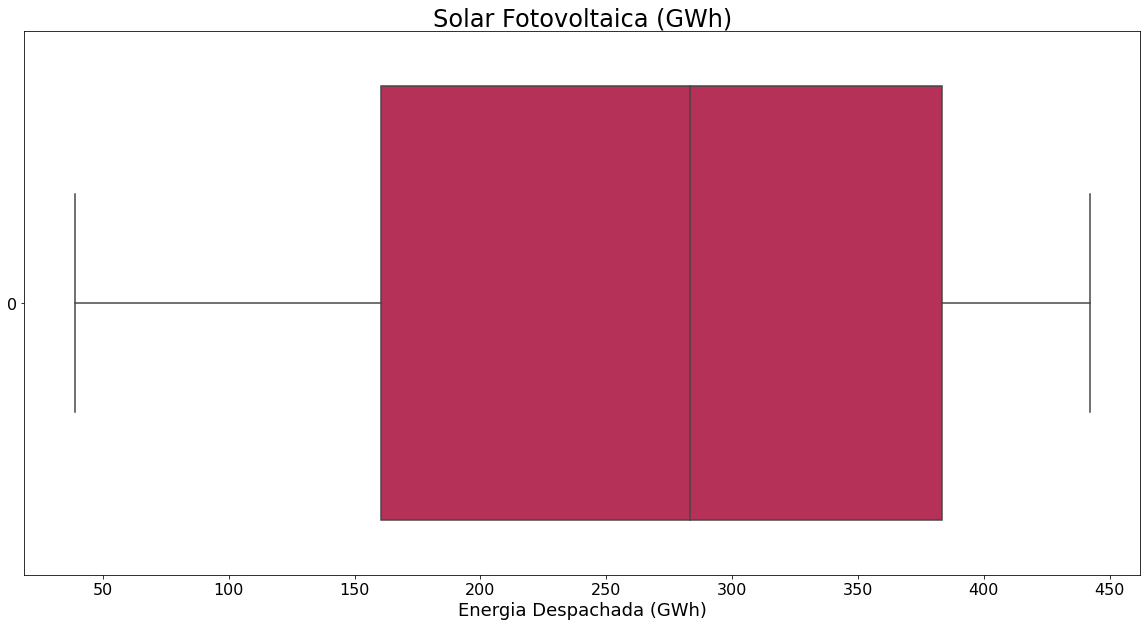

In [91]:
# Boxplot para a Fonte Solar Fotovoltaica
solar_graficos.boxplot()

In [92]:
# Descrição estatística dos dados da Fonte Solar Fotovoltaica
solar_stats.descricao()

Solar_Fotovoltaica
count           36.000000
mean           273.623984
std            123.777777
min             38.936346
25%            160.620956
50%            283.449266
75%            383.346000
max            442.069920

Não há a presença de outliers para a Energia Fotovoltaica. Há a presença de 36 valores com distribuição relativamente uniforme, embora haja a predominância de valores inferiores à mediana no conjunto de dados.

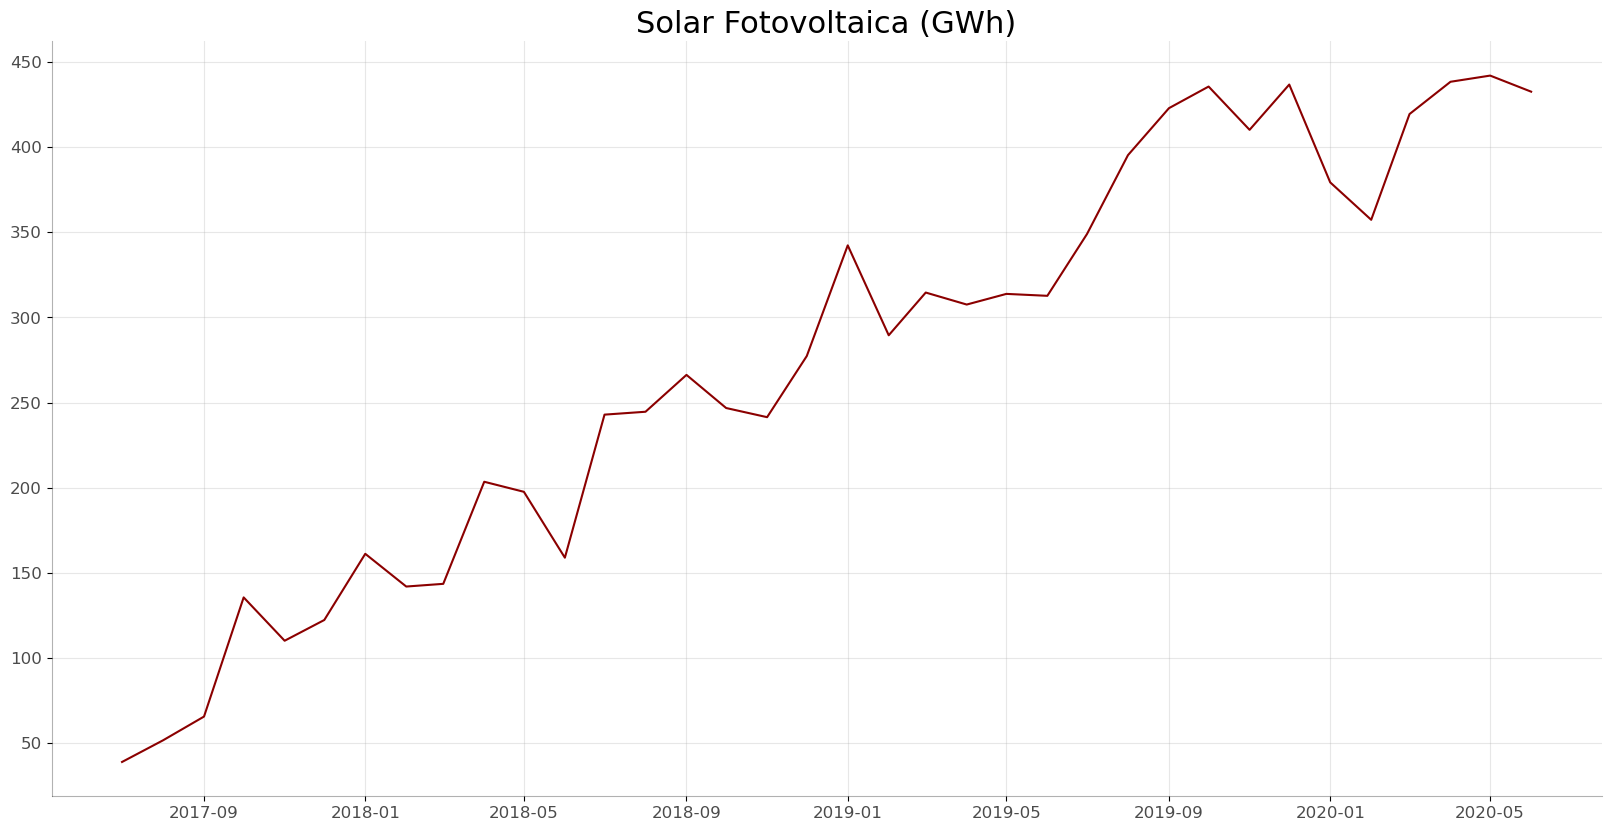

In [93]:
# Lineplot para a Fonte Solar Fotovoltaica
solar_graficos.lineplot()

É perceptível um crescimento aproximadamente linear dessa fonte nos últimos anos, com destaque para a baixa intensidade de oscilações dessa fonte em comparação com as outras, o que pode indicar uma maior estabilidade de produção anual.

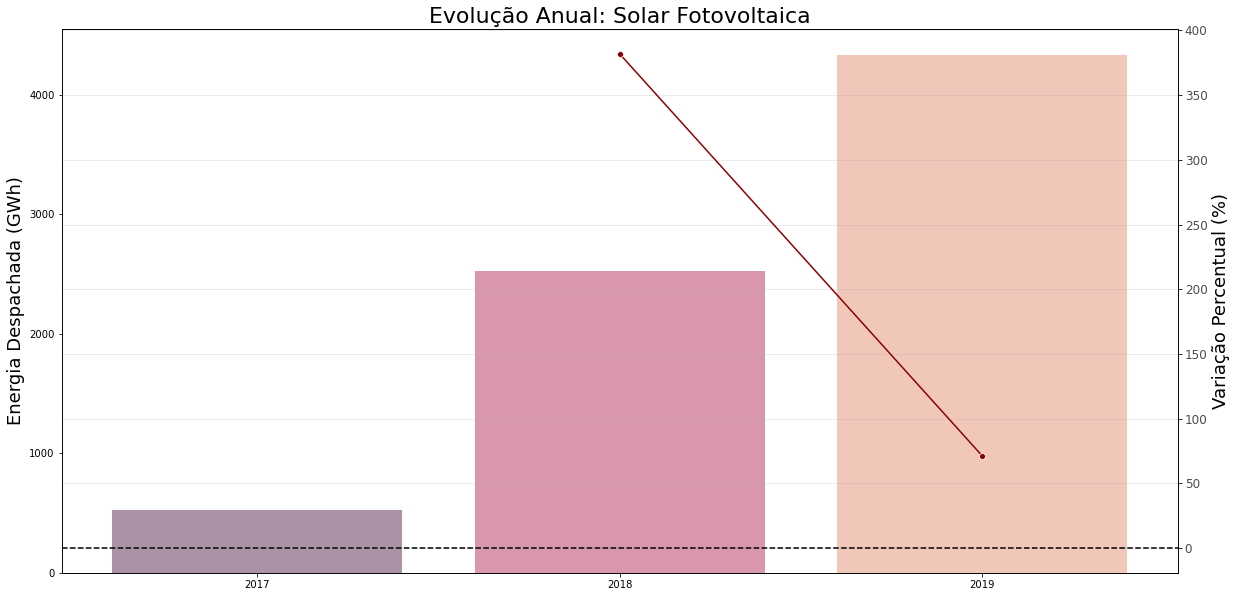

In [94]:
# Gráfico de barras de Produção Energética Anual Solar Fotovoltaica em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
solar_graficos.mixedplot()

In [95]:
# Objeto da classe "Nulos" de Solar Fotovoltaica em 2017
solar_nulos = Nulos('Solar_Fotovoltaica', dados_limpos.loc['2017'])

# Valores nulos da Fonte Solar Fotovoltaica em 2017
solar_nulos.nulos()

date
2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
2017-05-01    0.0
2017-06-01    0.0
Name: Solar_Fotovoltaica, dtype: float64

Como a presença dessa fonte é recente, só há dados consolidados de 3 anos. Inclusive, deve-se ter atenção ao avaliar o crescimento entre 2017 e 2018, visto que em 2017 só há a presença de dados a partir de julho, causando uma distorção no crescimento anual entre esses dois anos. Portanto, pode-se afirmar que o crescimento dessa fonte é notável entre 2018 e 2019, com aumento de aproximadamente 75% entre esses anos. 

#### 4.2.10. Fora do SIN 

Criação dos objetos de Fora do SIN referentes às classes "Nulos", "Stats" e "Graficos".

In [96]:
# Criação do objeto referente à Classe "Nulos" de "Fora do SIN"
fora_sin_nulos = Nulos('Fora_do_SIN', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Fora do SIN"
fora_sin_stats = Stats('Fora_do_SIN', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Fora do SIN"
fora_sin_graficos = Graficos('Fora_do_SIN', dados_limpos, soma, soma_perc)

In [97]:
# Valores iguais à zero de Fora do SIN
fora_sin_nulos.nulos()

date
2000-08-01    0.0
2000-09-01    0.0
2000-10-01    0.0
2000-11-01    0.0
2000-12-01    0.0
             ... 
2020-02-01    0.0
2020-03-01    0.0
2020-04-01    0.0
2020-05-01    0.0
2020-06-01    0.0
Name: Fora_do_SIN, Length: 78, dtype: float64

Há a presença de 78 valores nulos dessa variável. Entretanto, como há valores nulos no começo e no fim do dataset, isso pode indicar uma baixa confiabilidade desses dados, já que não houve um encerramento da produção de energia Fora do SIN.

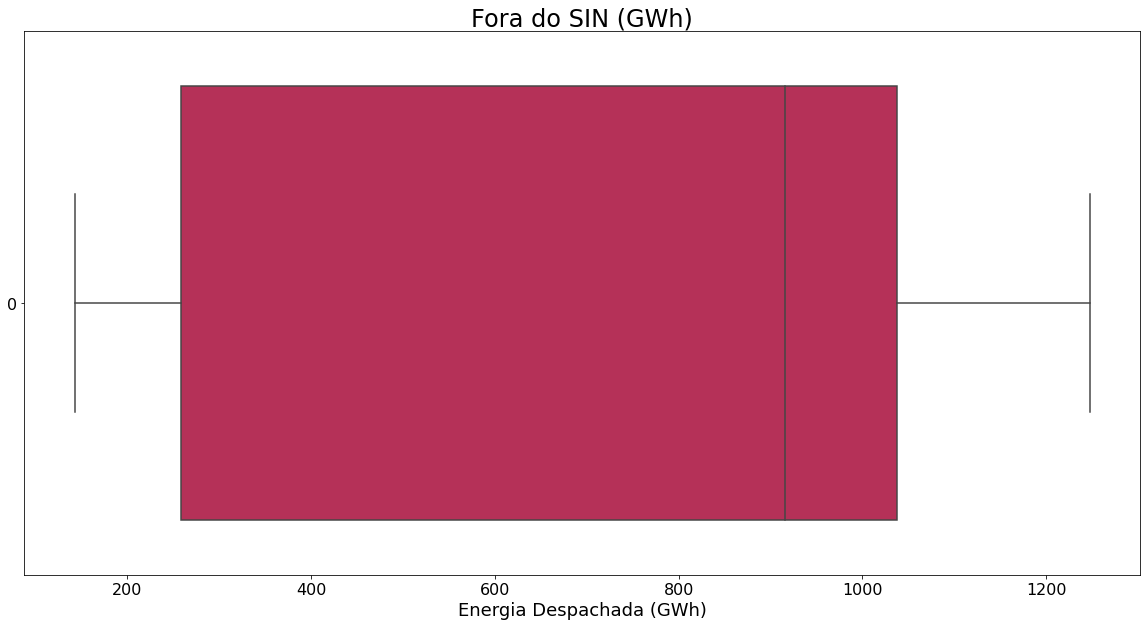

In [98]:
# Boxplot para Fora do SIN
fora_sin_graficos.boxplot()

In [99]:
# Descrição estatística dos dados de Fora do SIN
fora_sin_stats.descricao()

Fora_do_SIN
count   161.000000
mean    753.362994
std     362.116483
min     143.338399
25%     258.495461
50%     916.061118
75%    1037.308801
max    1247.139749

Não há a presença de outliers nesse conjunto de dados. Se destaca a grande diferença entre os valores do quartil inferior (258,50 GWh) e a mediana (916,06 GWh), o que demonstra uma baixa densidade de dados nessa faixa.

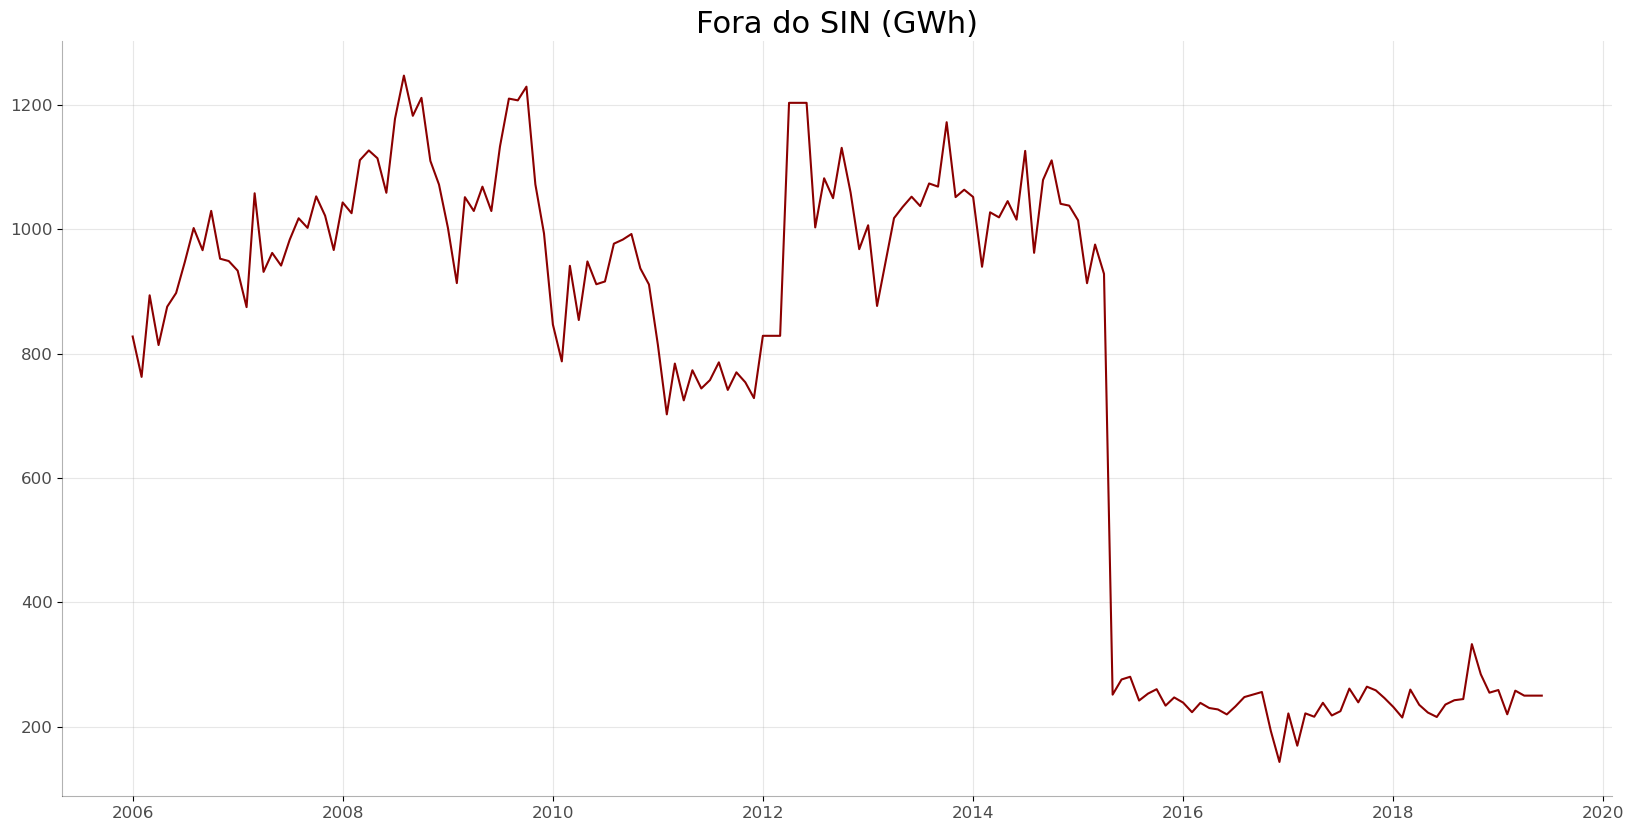

In [100]:
# Lineplot para a Fora do SIN
fora_sin_graficos.lineplot()

O gráfico de linhas indica que essa variável passou a ser computada em 2006, com comportamento relativamente constante entre os anos levando em conta as variações periódicas. Entretanto, há a presença de um valor nulo pouco depois de 2012 e uma queda de patamar não usual um pouco antes de 2016, com uma posterior falta de dados próximos à 2020.

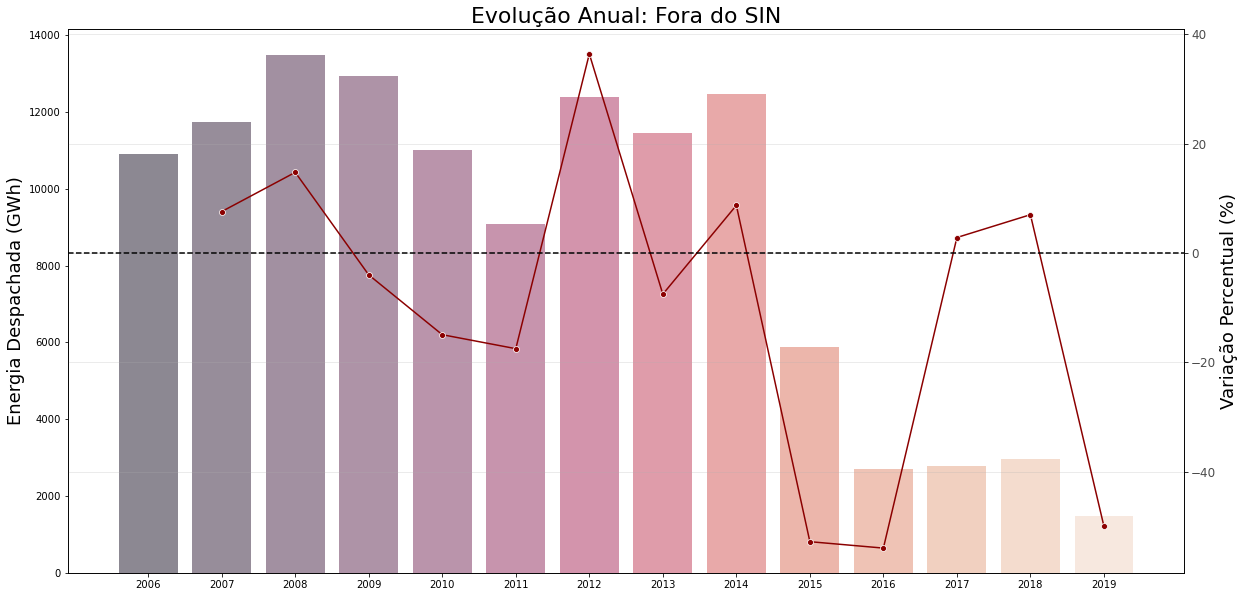

In [101]:
# Gráfico de barras de Produção Energética Anual Solar Fotovoltaica em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
fora_sin_graficos.mixedplot()

Os dados somados anuais indicam uma queda a partir de 2008 até 2011, quando passa a haver um crescimento. Entretanto, há uma quedas de aproximadamente de 50% entre 2014 e 2015 e 2015 e 2016, reduzindo substancialmente o patamar dessa variável. A irregularidade dos dados - tanto no comportamento quanto na inserção - desestimula a inferência de análises a partir desses dados.

#### 4.2.11. Resíduos Industriais

Criação dos objetos da Fonte Resíduos Industriais referentes às classes "Nulos", "Stats" e "Graficos".

In [102]:
# Criação do objeto referente à Classe "Nulos" de "Residuos Industriais"
res_ind_nulos = Nulos('Residuos_Industriais', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Residuos Industriais"
res_ind_stats = Stats('Residuos_Industriais', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Residuos Industriais"
res_ind_graficos = Graficos('Residuos_Industriais', dados_limpos, soma, soma_perc)

In [103]:
# Valores iguais à zero da Fonte Resíduos Industriais
res_ind_nulos.nulos()

date
2000-08-01    0.0
2000-09-01    0.0
2000-10-01    0.0
2000-11-01    0.0
2000-12-01    0.0
             ... 
2006-12-01    0.0
2007-01-01    0.0
2007-02-01    0.0
2007-03-01    0.0
2007-04-01    0.0
Name: Residuos_Industriais, Length: 81, dtype: float64

Há a presença de 81 valores nulos dessa variável no conjunto de dados. Dessa forma, a análise será realizada somente com valores não-nulos.

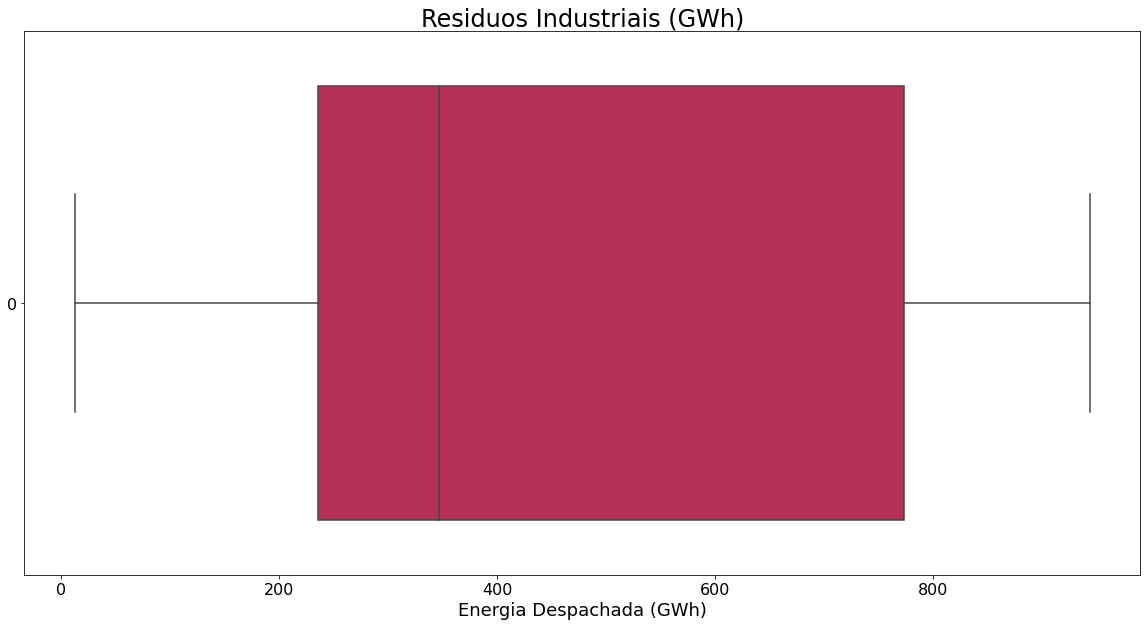

In [104]:
# Boxplot para a Fonte Resíduos Industriais
res_ind_graficos.boxplot()

In [105]:
# Descrição estatística dos dados da Fonte Resíduos Industriais
res_ind_stats.descricao()

Residuos_Industriais
count            158.000000
mean             468.281761
std              279.645399
min               12.874610
25%              235.841138
50%              346.213340
75%              772.582625
max              943.233728

Não há a presença de valores nulos no boxplot, com maior concentração de dados até o valor da mediana (346,21 GWh), totalizando 158 entradas.

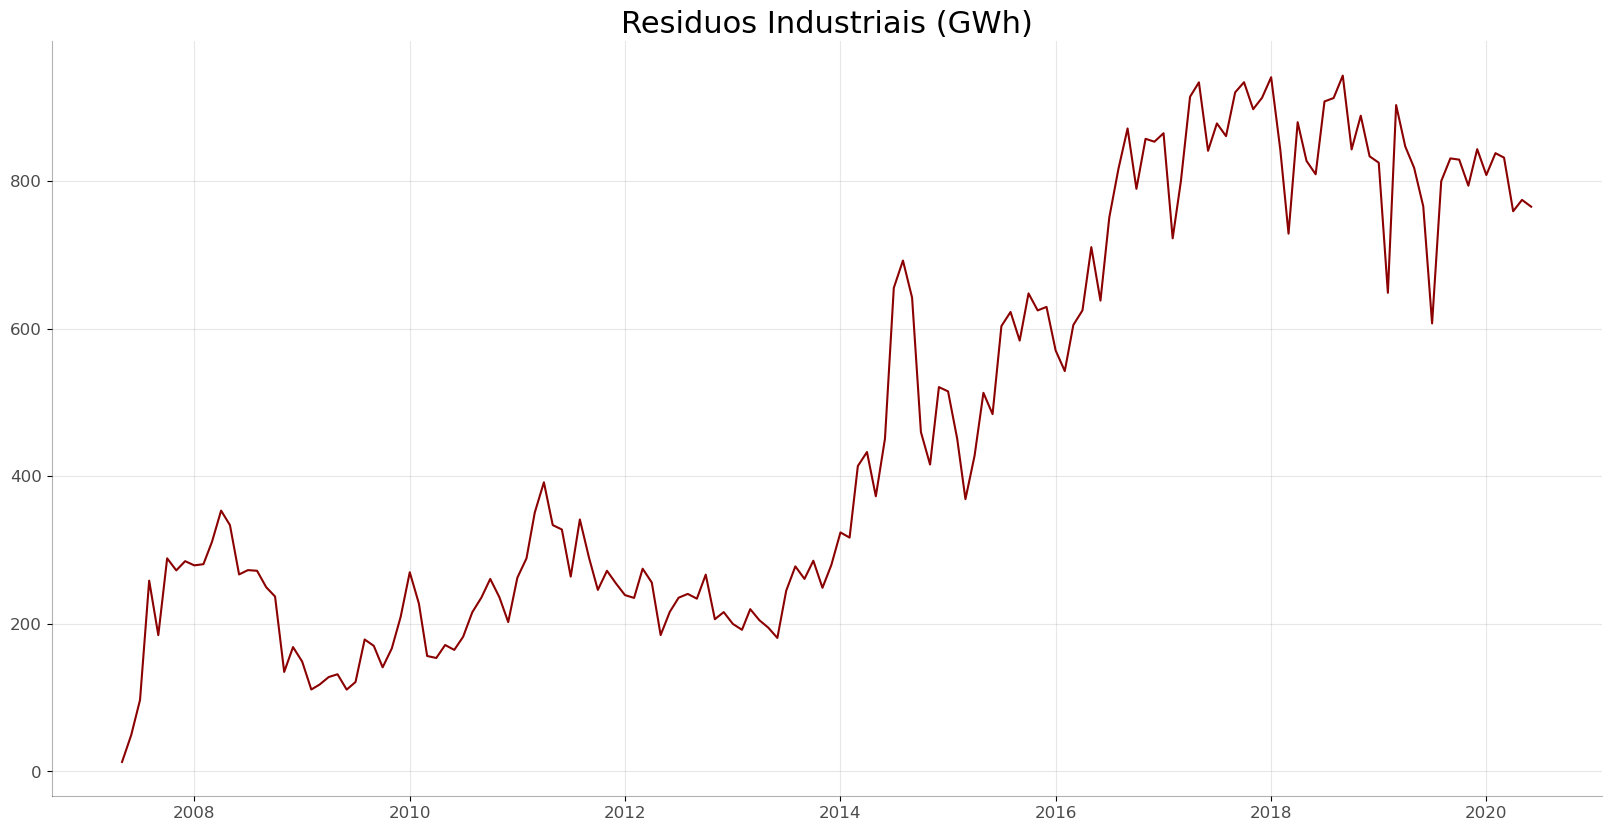

In [106]:
# Lineplot para a Fonte Resíduos Industriais
res_ind_graficos.lineplot()

Nota-se a presença de oscilações periódicas à partir do gráfico de linhas. São notáveis dois períodos de crescimento: a partir de 2014 e 2016, com manutenção de patamar dos valores a partir de 2017 procedida por uma ligeira queda.

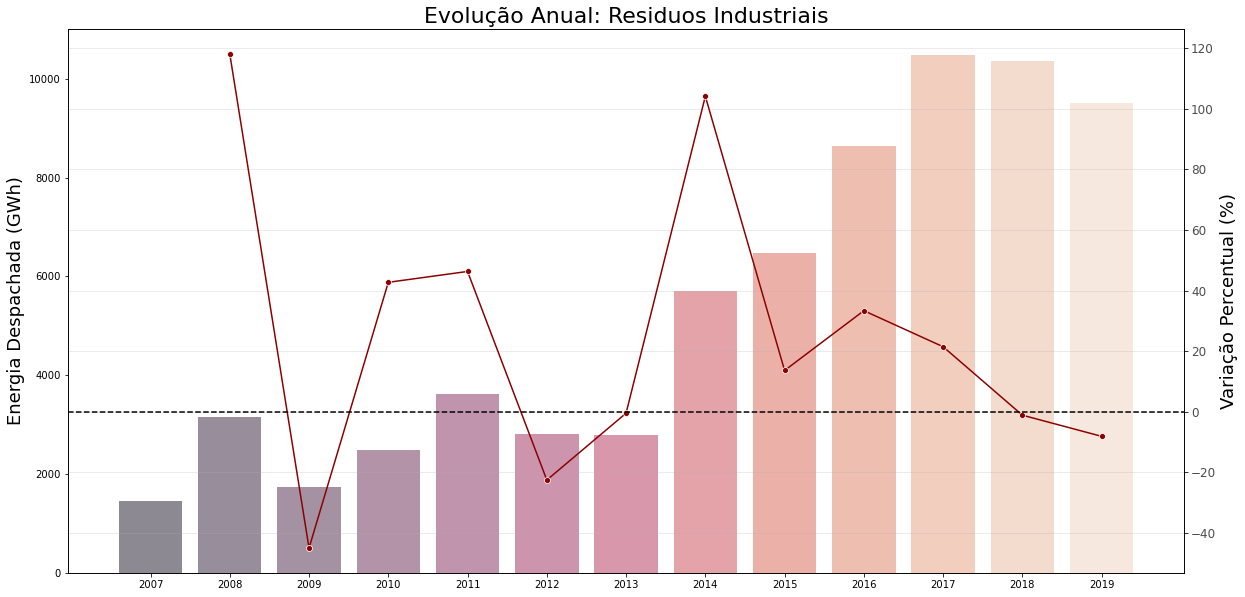

In [107]:
# Gráfico de barras de Produção Energética Anual de Resíduos Industriais em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
res_ind_graficos.mixedplot()

Após uma subida de quase 120% entre 2007 e 2008, houve uma queda no período seguinte, procedida de uma leve subida e manutenção de patamar. Entre 2013 e 2014 é observado um crescimento acima de 100% e manutenção do crescimento até 2017, com uma breve queda nos dois anos seguintes, porém mantendo um patamar de produção semelhante.

### 4.3. Exploração das Variáveis de Agrupamento

Nessa etapa as variáveis criadas para agrupamento serão analisadas separadamente.

#### 4.3.1. Hidrelétricas

Não há valores nulos para essa variável pois ambas as variáveis que formam esse agrupamento não possuem valores nulos.

Criação dos objetos do Agrupamento Hidrelétricas referentes às classes "Stats" e "Graficos", além da seleção das variáveis pertencentes ao agrupamento.

In [108]:
# Criação do objeto referente à Classe "Stats" de "Hidrelétricas"
hidro_stats = Stats('Hidreletricas', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Hidrelétricas"
hidro_graficos = Graficos('Hidreletricas', dados_limpos, soma, soma_perc)

# Seleção das variáveis do agrupamento
hidro_selecao = dados_limpos[['Hidreletricas', 'Hidreletricas_exceto_Itaipu', 'Itaipu']]

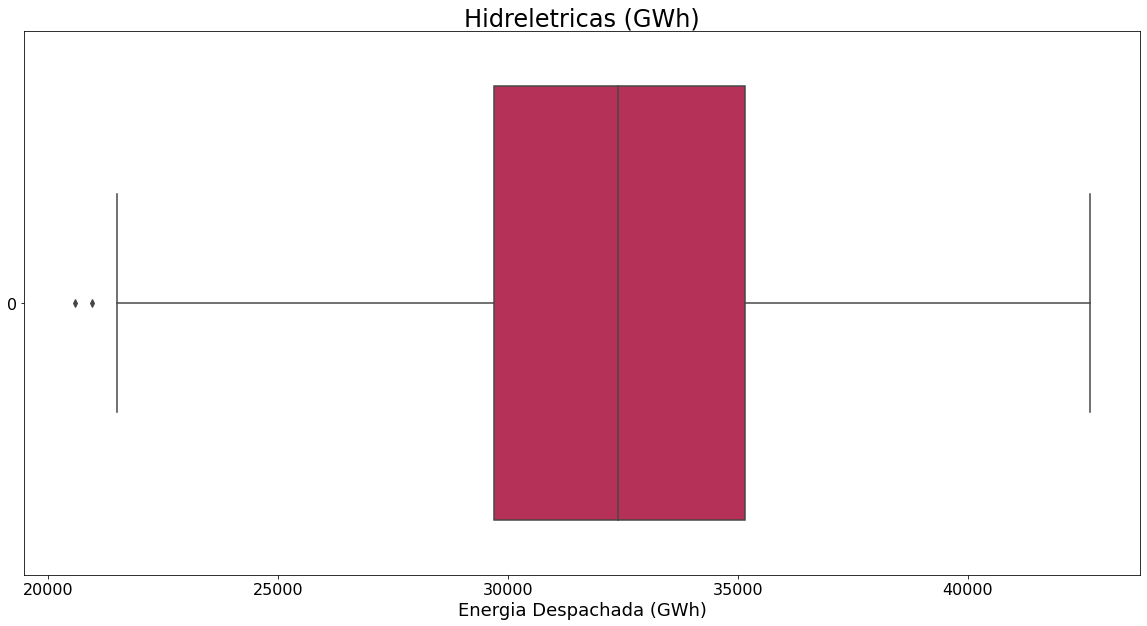

In [109]:
# Boxplot para o Agrupamento Hidrelétricas
hidro_graficos.boxplot()

In [110]:
# Descrição estatística dos dados do Agrupamento Hidrelétricas
hidro_stats.descricao()

Hidreletricas
count     239.000000
mean    32360.765127
std      4085.508034
min     20593.091500
25%     29690.681135
50%     32385.394770
75%     35146.576365
max     42642.000000

In [111]:
# Obtenção dos valores outliers do Agrupamento Hidrelétricas
hidro_stats.get_outliers()

Hidreletricas
date                     
2001-06-01    20971.48592
2001-09-01    20593.09150

Há a presença de dois valores outliers abaixo do limite inferior do boxplot, referentes ao período de crise hídrica de 2001. A média de produção Hidrelétrica é de 32360,77 GWH e o desvio padrão é relativamente baixo, com valor de 4085,51 GWh.

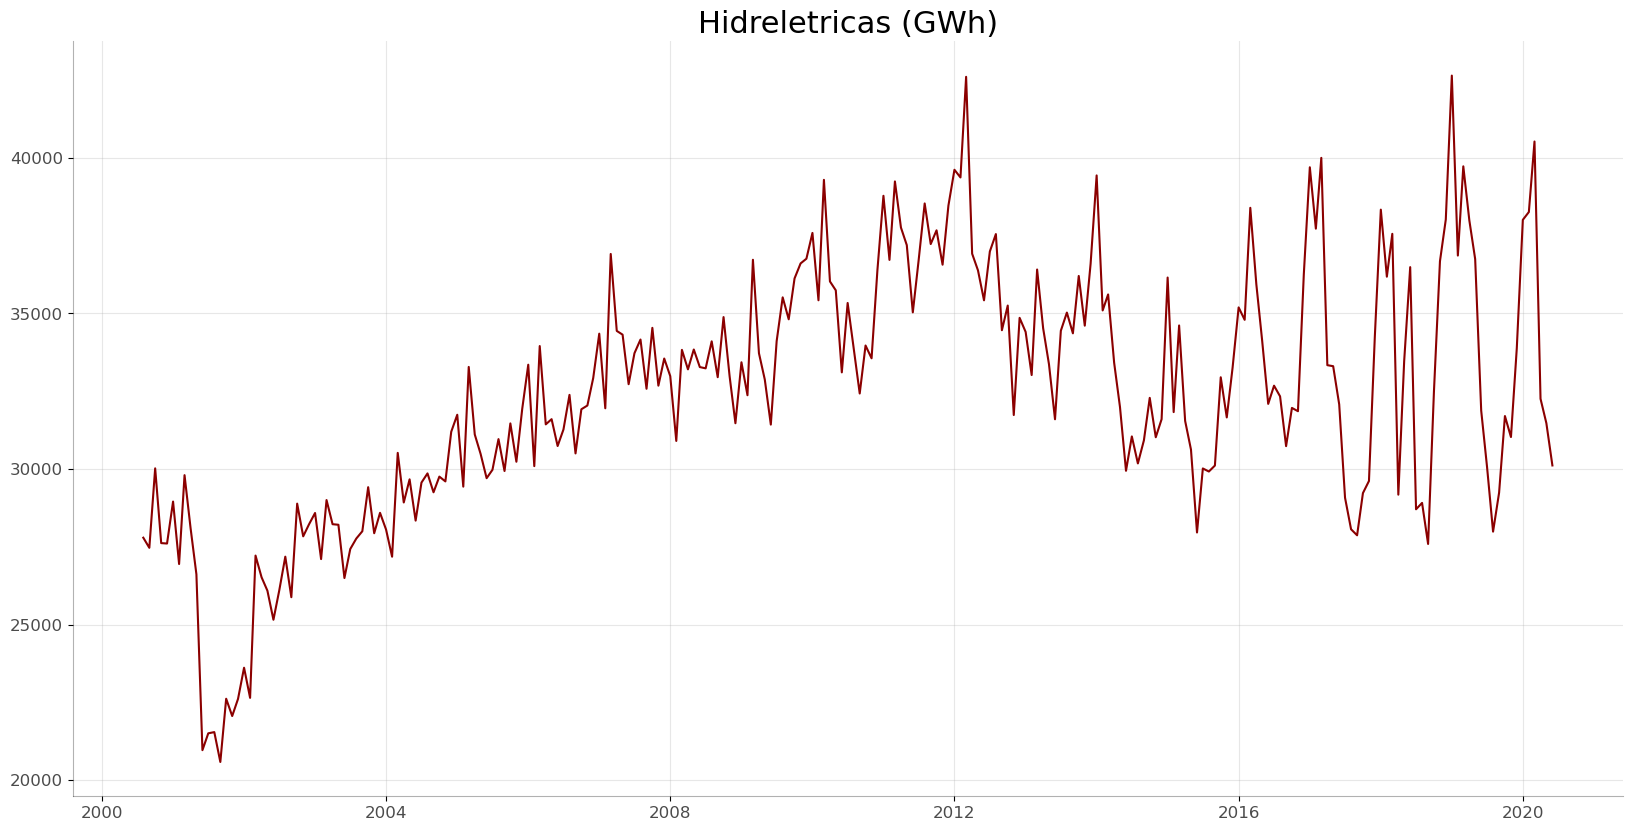

In [112]:
# Lineplot para o Agrupamento Hidrelétricas
hidro_graficos.lineplot()

O gráfico de linhas mostra que a evolução temporal individual da variável Hidrelétricas se assemelha bastante àquela vista referente à variável "Hidrelétricas (exceto Itaipu)", com grande coincidência em seus picos e vales.

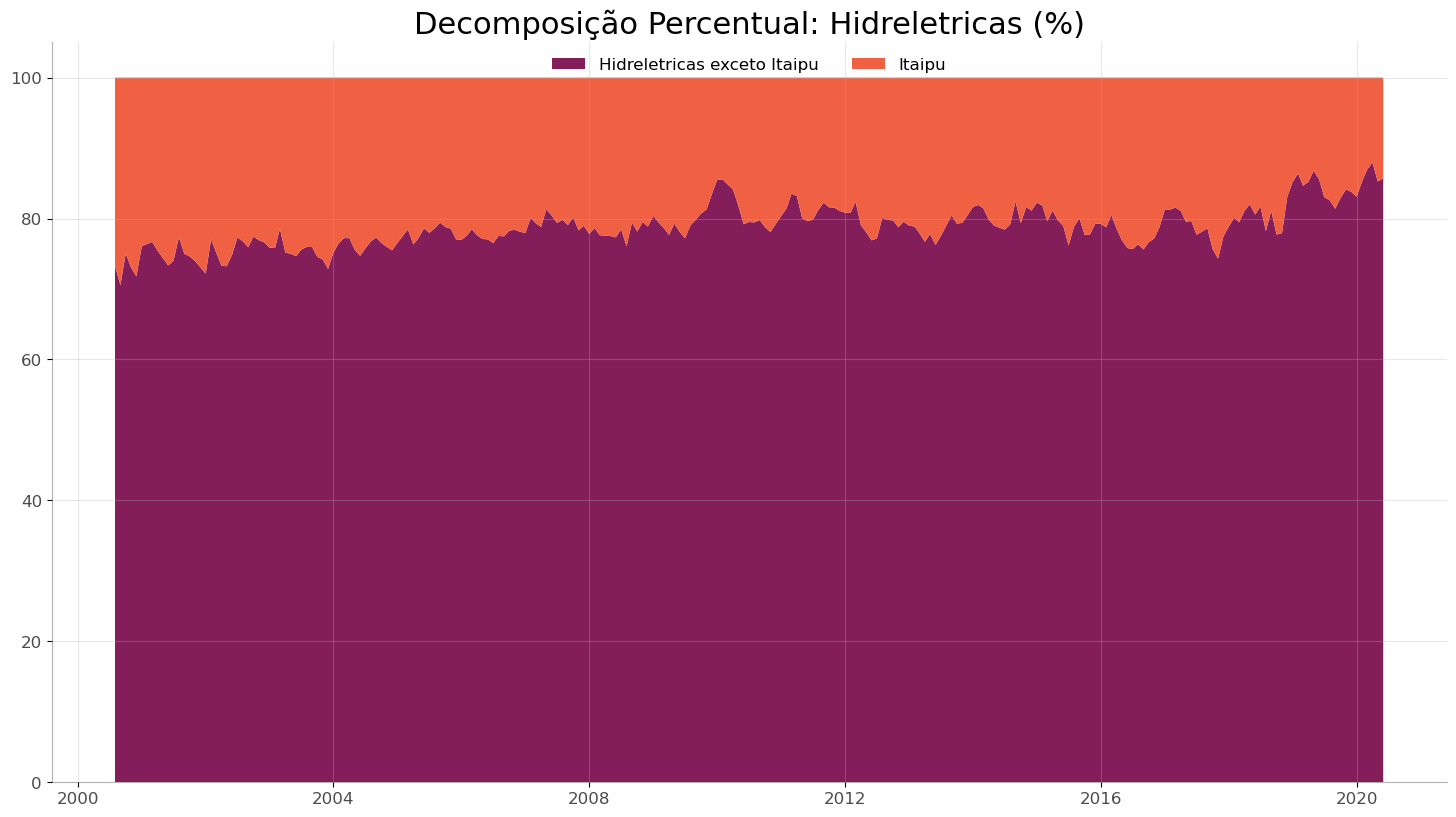

In [113]:
# Gráfico de Área para o Agrupamento "Hidrelétricas"
hidro_graficos.areaplot(hidro_selecao)

O gráfico de área acima compara o percentual de participação de "Hidrelétricas (exceto Itaipu)" e "Itaipu" no Agrupamento "Hidrelétricas". Nota-se que a participação de Itaipu vem se reduzindo fortemente nos últimos anos por causa da crise de abastecimento hídrico que ocorre na Bacia do Rio Paraná, como discutido acima.

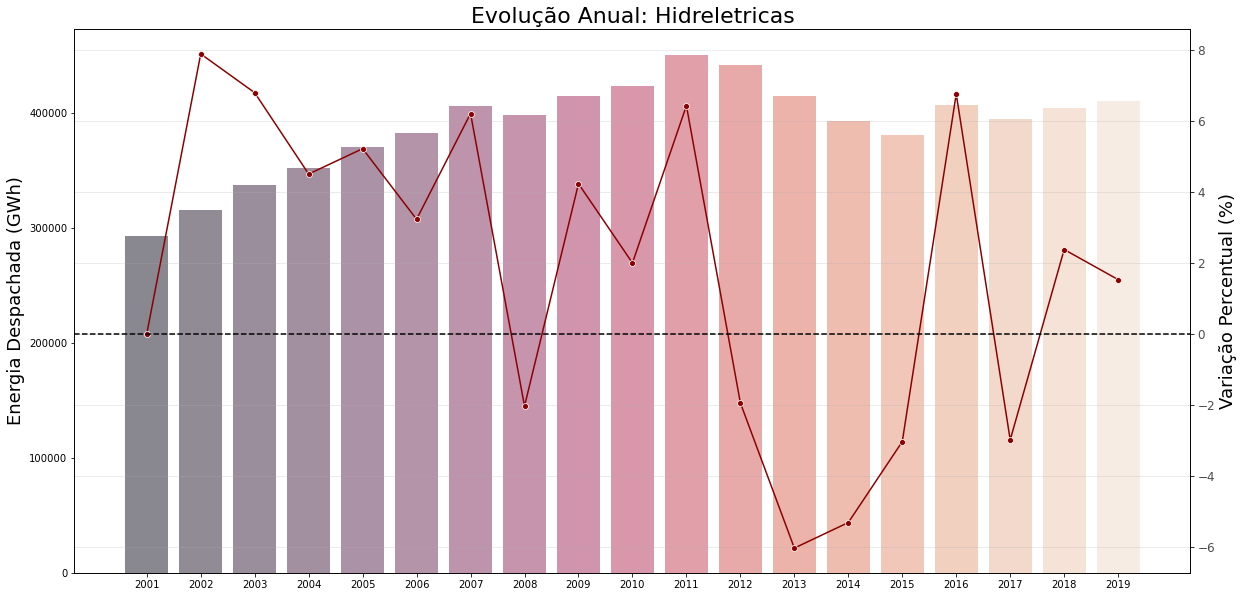

In [114]:
# Gráfico de barras de Produção Energética Anual de Hidrelétricas em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
hidro_graficos.mixedplot()

A produção de Hidrelétricas subiram de forma constante - exceção de 2008, ano de Crise Econômica Internacional - até 2011, quando passaram a cair até 2015, fruto de uma crise hídrica que afetou sua produtividade. Entretanto, em 2016 ela voltou a crescer - ultrapassando 6% em comparação com 2015 - com uma queda de aproximante 3% no ano seguinte. Entretanto, ela passou a ter uma trajetória ascendente tímida - com crescimento na casa de 2% - nos anos seguintes mesmo considerando a queda na produção de Itaipu que diminuiu a magnitude desse crescimento.

#### 4.3.2. Renovável

Não há valores nulos para essa variável pois há variáveis que formam esse agrupamento que não possuem valores nulos.

Criação dos objetos do Agrupamento Renovável referentes às classes "Stats" e "Graficos", além da seleção das variáveis pertencentes ao agrupamento.

In [115]:
# Criação do objeto referente à Classe "Stats" de "Renovável"
renovavel_stats = Stats('Renovavel', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Renovável"
renovavel_graficos = Graficos('Renovavel', dados_limpos, soma, soma_perc)

# Seleção das variáveis do agrupamento
renovavel_selecao = dados_limpos[['Renovavel', 'Hidreletricas_exceto_Itaipu', 'Itaipu', 'Eolicas', 'Biomassas', 'Solar_Fotovoltaica']]

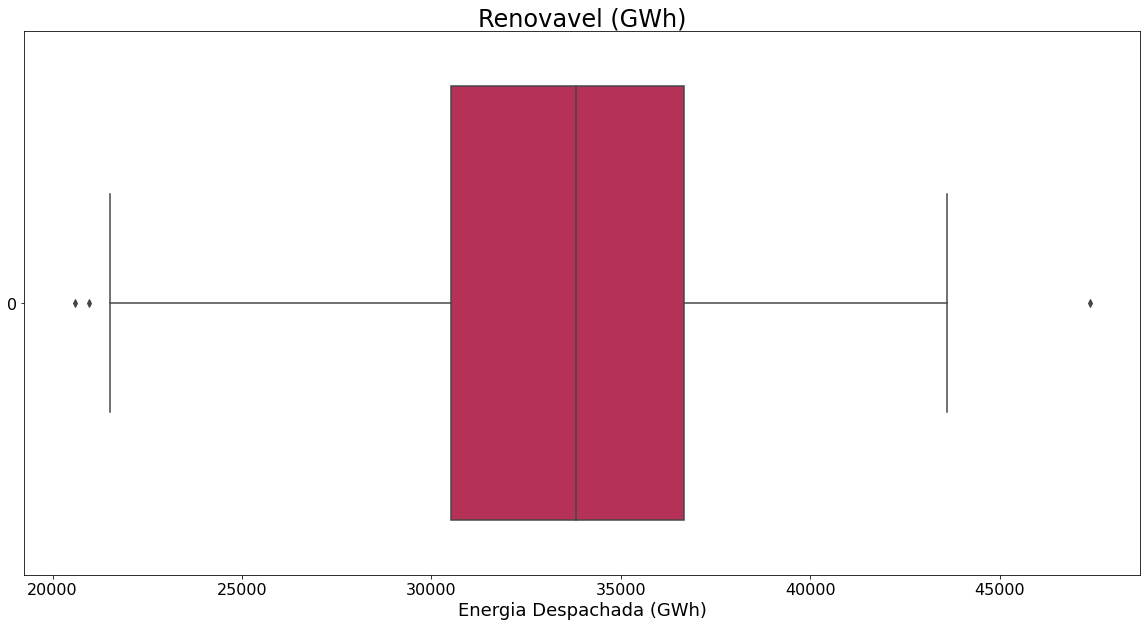

In [116]:
# Boxplot para o Agrupamento Renovável
renovavel_graficos.boxplot()

In [117]:
# Descrição estatística dos dados do Agrupamento Renovável
renovavel_stats.descricao()

Renovavel
count    239.000000
mean   33547.578844
std     4652.543932
min    20593.091500
25%    30523.461690
50%    33824.780580
75%    36664.453920
max    47373.329330

In [118]:
# Obtenção dos valores outliers do Agrupamento Renovável
renovavel_stats.get_outliers()

(              Renovavel
 date                   
 2001-06-01  20971.48592
 2001-09-01  20593.09150,
               Renovavel
 date                   
 2019-01-01  47373.32933)

No Agrupamento Renovável há 3 outliers, sendo 2 abaixos do limite inferior referentes ao período de crise hídrica em 2001 e 1 outlier acima do limite superior, referente à janeiro de 2019, valor máximo do conjunto de dados.

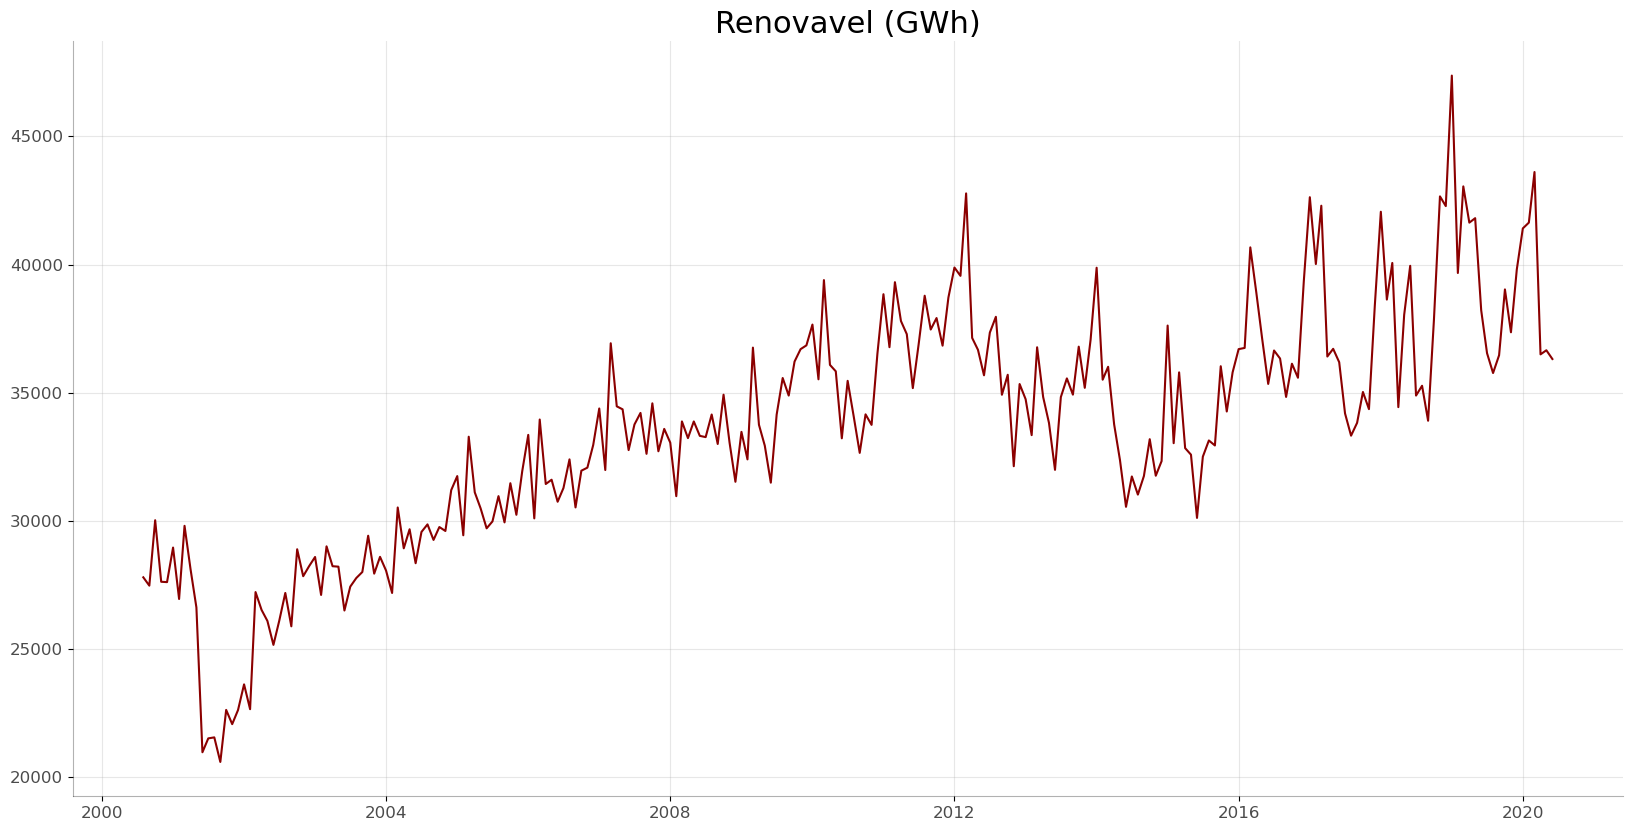

In [119]:
# Lineplot para o Agrupamento Renovável
renovavel_graficos.lineplot()

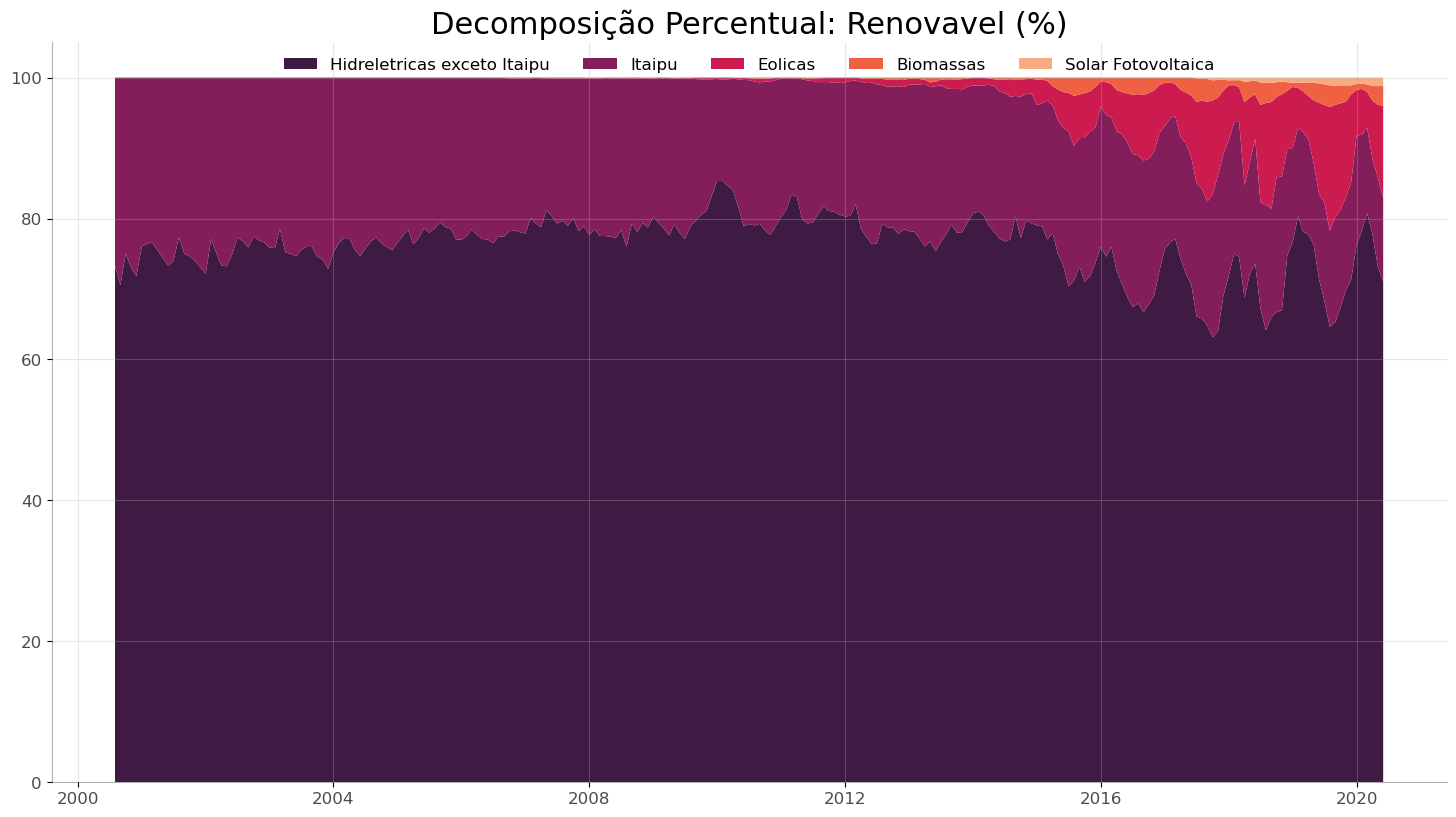

In [120]:
# Gráfico de Área para o Agrupamento "Renovável"
renovavel_graficos.areaplot(renovavel_selecao)

O agrupamento Renovável foi completamente tomado por Fontes Hidrelétricas pela década de 2000, passando a possuir a participação de outras fontes no SIN no começo da década de 2010. No final do período nota-se que a predominância das Hidrelétricas diminui, com destaque para a o crescimento da fonte Eólica. É interessante observar que os pontos de máximo de produção Eólica fazem com que a participação das demais fontes caiam fortemente no agrupamento, de forma que "Hidrelétricas (exceto Itaipu)" chegue a obter participação de apenas pouco mais de 60% dentre as Fontes Renováveis, demonstrando a recente diversificação na Matriz Elétrica.

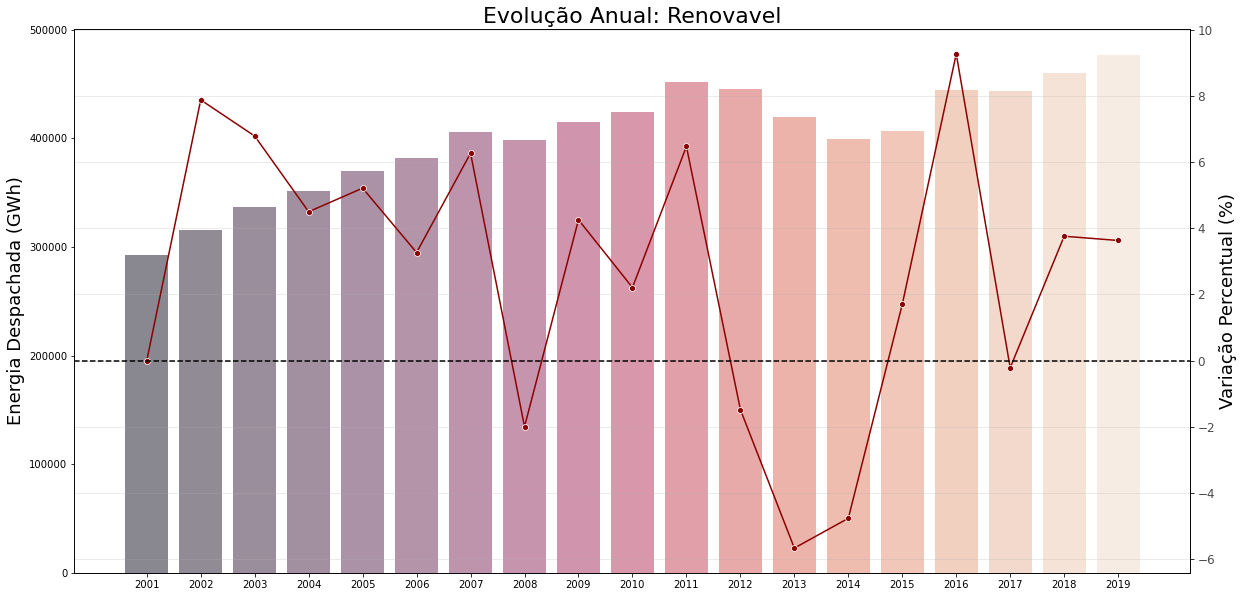

In [121]:
# Gráfico de barras de Produção Energética Anual de "Renovável" em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
renovavel_graficos.mixedplot()

As Fontes Renováveis tiveram crescimento de produção no SIN contíunuo até 2011 - excetuando-se 2008 - pelo forte impacto de Hidrelétricas em seu agrupamento, que passou a sofrer com a crise hídrica. A partir de 2016 ela passou a voltar à ascendente - exceto 2017 em que obteve queda muito pequena - com 2019 sendo seu ano com maior produção de energia, mantendo quase 4% de crescimento anual por 2 anos seguidos.

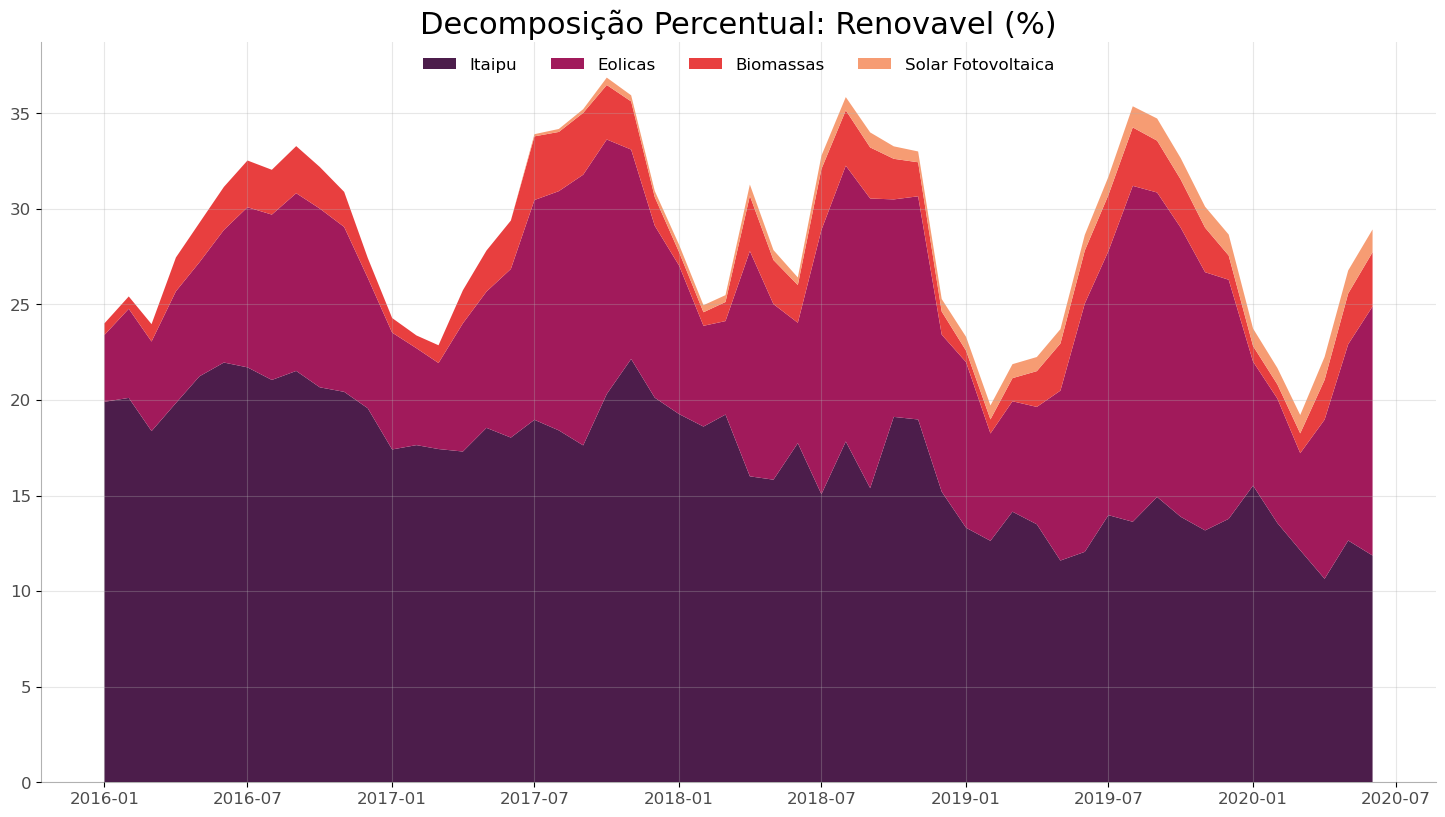

In [122]:
# Criação do objeto referente à Classe "Stats" de "Renovável"
renovavel_graficos = Graficos('Renovavel', dados_limpos.loc['2016':'2020'], soma=None, soma_perc=None)

# Lineplot para variáveis selecionadas do Agrupamento Renovável entre 2016 e 2020
selecao = dados_limpos[['Renovavel', 'Itaipu', 'Eolicas', 'Biomassas', 'Solar_Fotovoltaica']].loc['2016':'2020']
renovavel_graficos.areaplot(selecao)

O gráfico de área acima foi posto com o intuito de comparar o comportamento das fontes Renováveis a partir de 2016, ano em que começa a haver fortes mudanças em sua composição. Para melhor visualização, a variável "Hidrelétricas (exceto Itaipu) foi retirada do gráfico visto que sua forte participação dificulta a visualização das tendências vistas para as outras variáveis do agrupamento.

Nota-se que a produção de Itaipu caiu ao passo que a produção Eólica teve forte crescimento no período. Isso permitiu que, a partir de 2019, a Energia Eólica ultrapasse a produção de Itaipu em seus pontos de máximo. A Fonte Solar Fotovoltaica demonstra grande crescimento porém ainda não possui participação muito significativa enquanto Biomassas não teve alteração relevante. 

#### 4.3.3. Não Renovável

Não há valores nulos para essa variável pois há variáveis que formam esse agrupamento que não possuem valores nulos.

Criação dos objetos do Agrupamento Não Renovável referentes às classes "Stats" e "Graficos", além da seleção das variáveis pertencentes ao agrupamento.

In [123]:
# Criação do objeto referente à Classe "Stats" de "Não Renovável"
nao_renovavel_stats = Stats('Nao_Renovavel', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Não Renovável"
nao_renovavel_graficos = Graficos('Nao_Renovavel', dados_limpos, soma, soma_perc)

# Seleção das variáveis do agrupamento
nao_renovavel_selecao = dados_limpos[['Nao_Renovavel', 'Carvao', 'Gas_Natural', 'Nuclear', 'Oleo']]

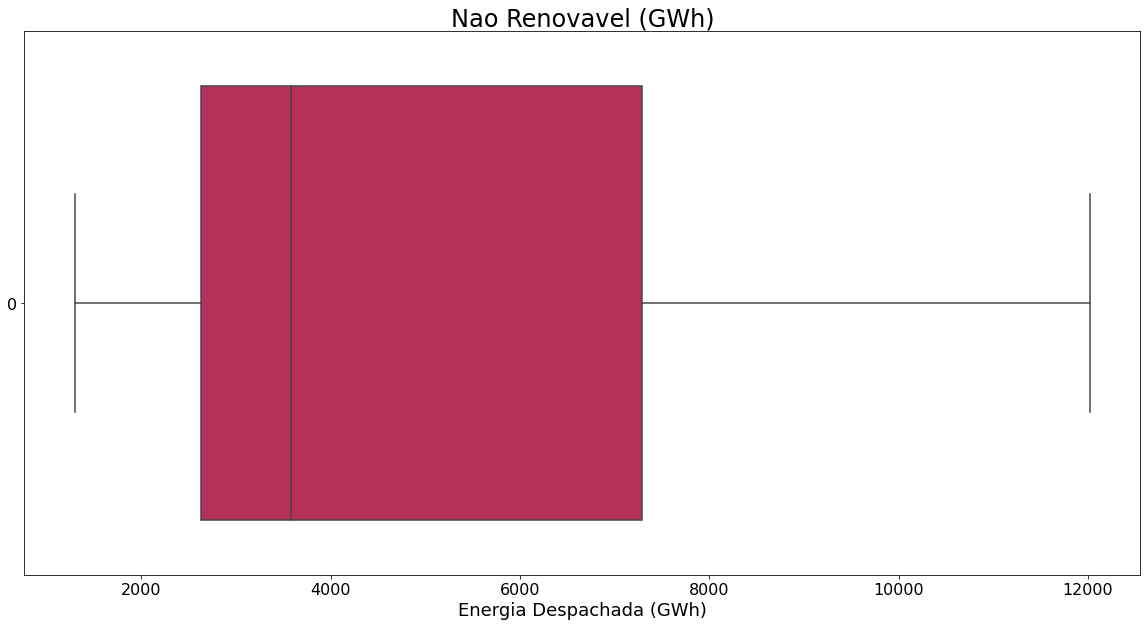

In [124]:
# Boxplot para o Agrupamento "Não Renovável"
nao_renovavel_graficos.boxplot()

In [125]:
# Descrição estatística dos dados do Agrupamento "Não Renovável"
nao_renovavel_stats.descricao()

Nao_Renovavel
count     239.000000
mean     4881.246361
std      2860.740140
min      1298.661450
25%      2629.104830
50%      3581.049620
75%      7292.480524
max     12016.596737

Não há a presença de outliers nesse agrupamento, com uma concentração de dados maior até o valor da mediana (3581,05 GWh). 

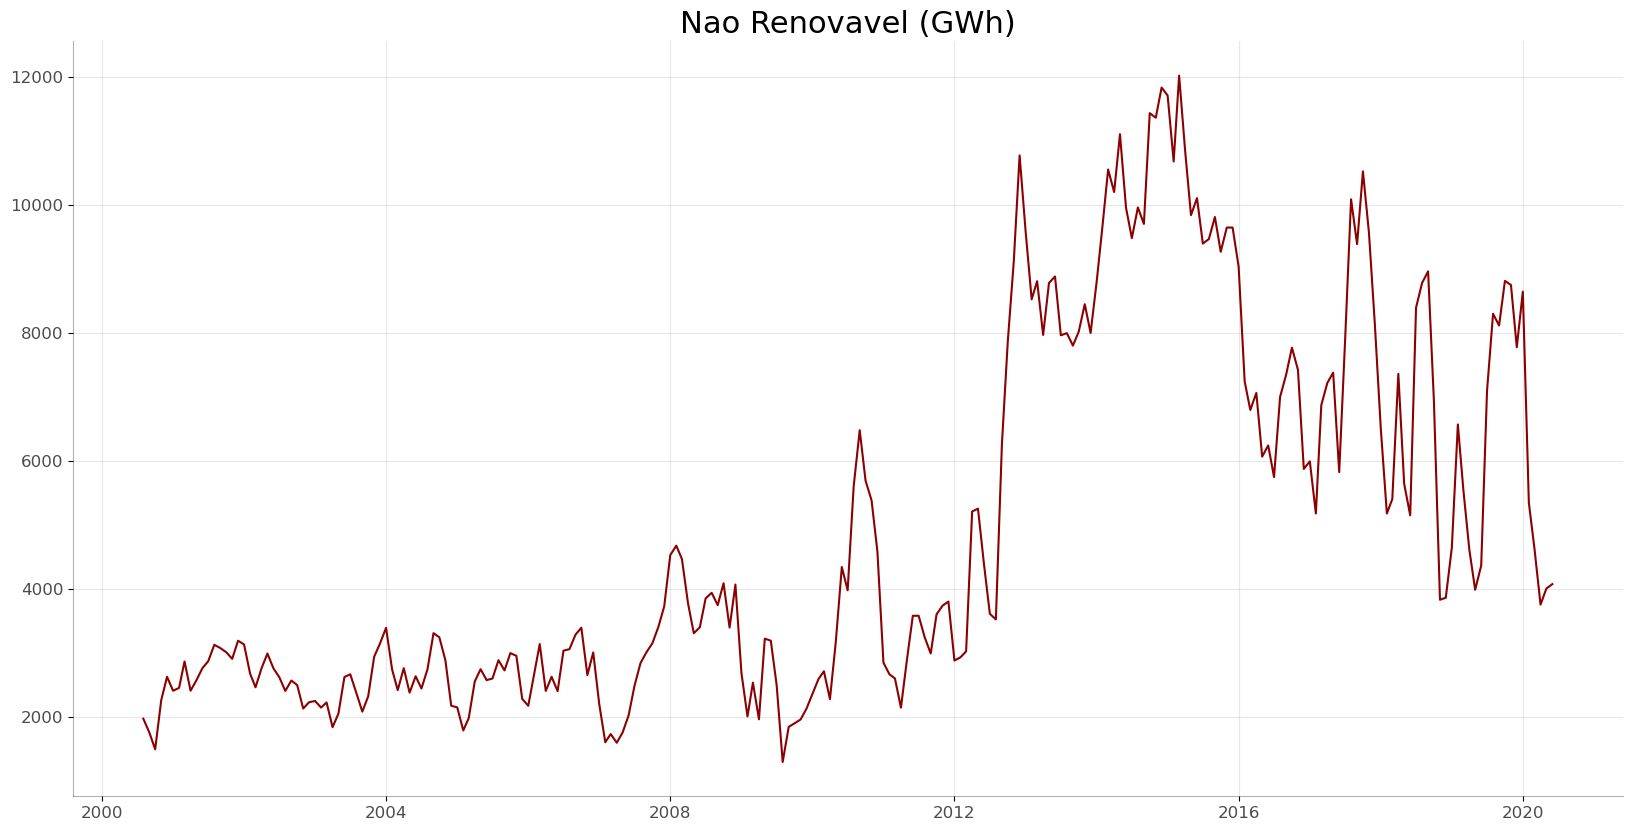

In [126]:
# Lineplot para o Agrupamento "Não Renovável"
nao_renovavel_graficos.lineplot()

O crescimento de produção elétrica por Fontes Não Renováveis cresceu substanciamente no começo da década de 2010, respondendo a queda na produção hídrica do período. Entretanto, nota-se que no final da década há uma queda substancial na sua produção energética. É percebida uma forte presença de variações sazonais na sua produção energética.

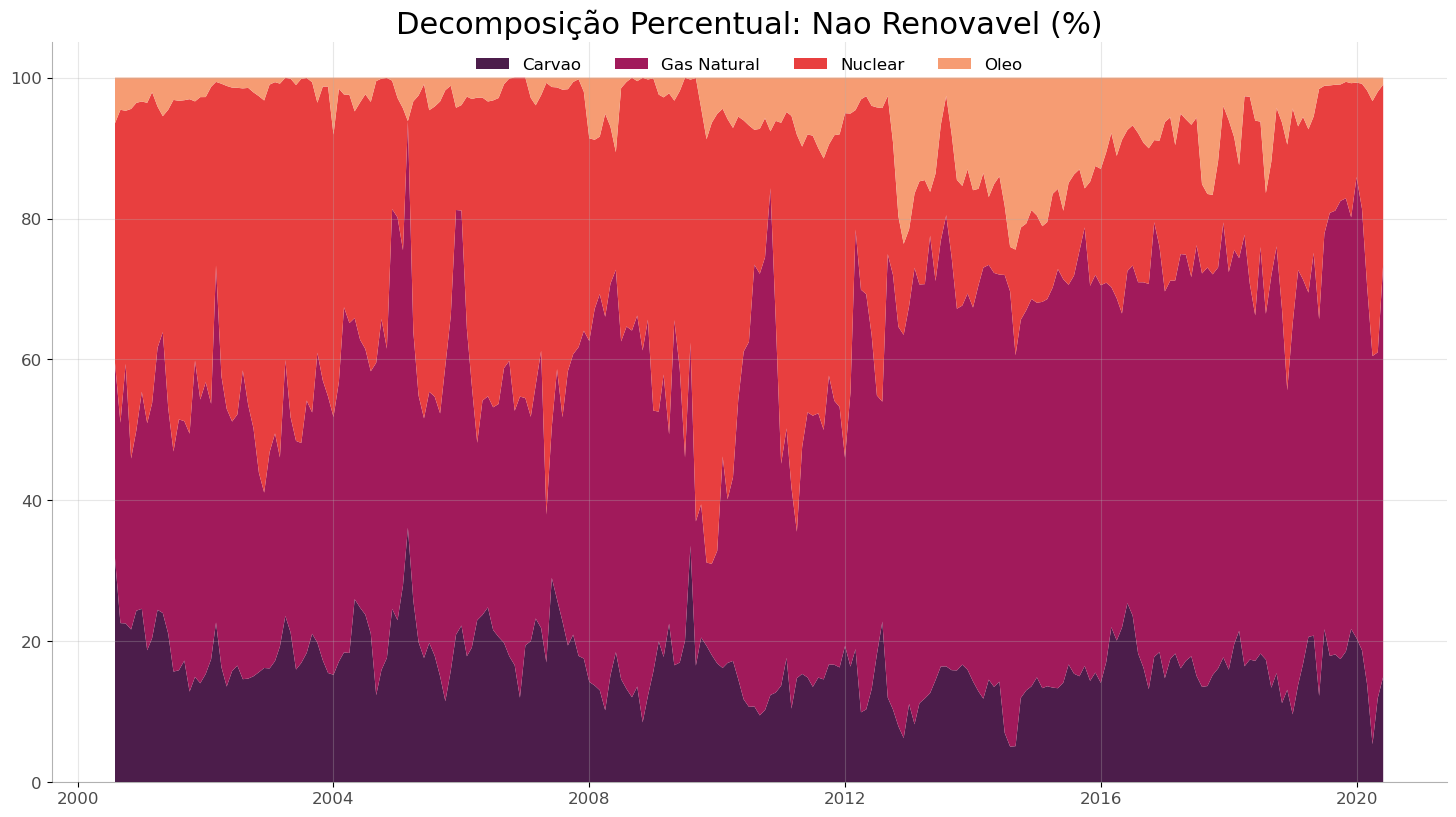

In [127]:
# Gráfico de Área para o Agrupamento "Não Renovável"
nao_renovavel_graficos.areaplot(nao_renovavel_selecao)

Dentre as fontes Não Renováveis, havia um equilíbrio na produção de Carvão e Gàs Natural (ambas superiores às outras) até 2011. Então ambas tiveram grande aumento de produção de energia para compensar a crise hídrica, de forma que Gás Natural passou a ser a fonte predominante nesse agrupamento. Também destaca-se a queda na produção por Carvão e Óleo Diesel/Combustível no final da Série Temporal, sendo a primeira superada até pela Energia Nuclear.

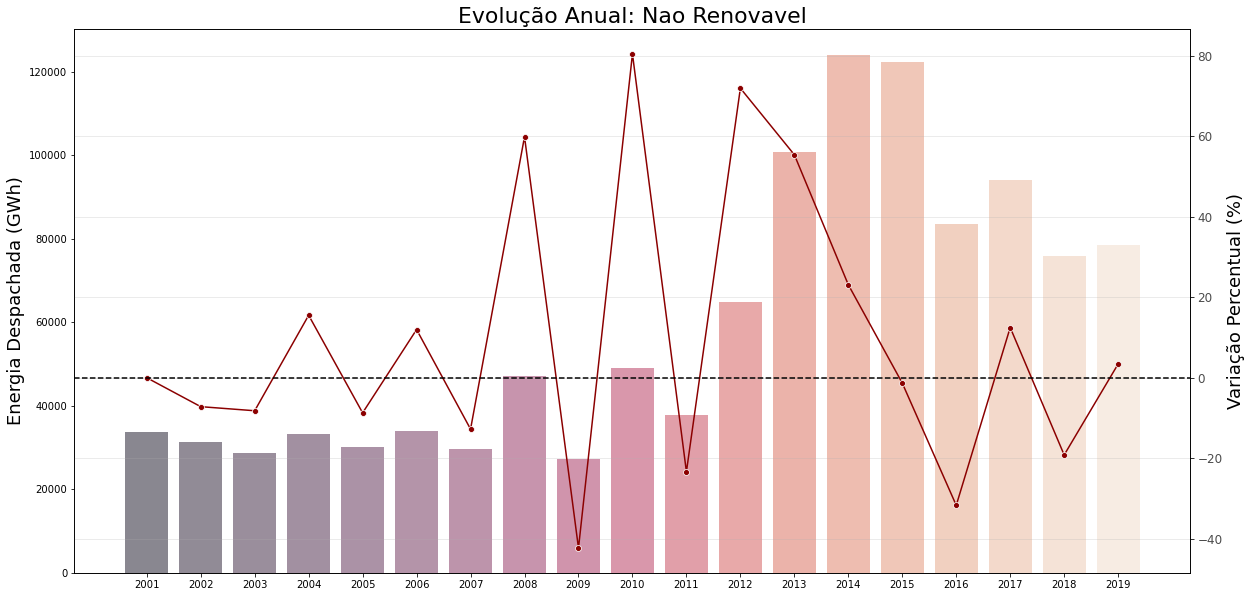

In [128]:
# Gráfico de barras de Produção Energética Anual de Hidrelétricas em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
nao_renovavel_graficos.mixedplot()

A participação de Fontes Não Renováveis na Matriz Elétrica aumentou substancialmente à partir da Crise Hídrica, possuindo ápice em 2014 e 2015. Desde então sua produção se encontra em queda, com estabilidade em um valor relativamente baixo em 2019, ocorrendo pela queda na necessidade do uso de Termelétricas pela recuperação no nível dos reservatórios hídricos até o fim da Série Temporal.

#### 4.3.4. Renováveis (exceto Hidrelétricas)

Criação dos objetos do Agrupamento Renováveis (exceto Hidrelétricas) referentes às classes "Nulos", "Stats" e "Graficos", além da seleção das variáveis pertencentes ao agrupamento.

In [129]:
# Criação do objeto referente à Classe "Nulos" de "Renováveis (exceto Hidrelétricas)"
renovaveis_sem_hidro_nulos = Nulos('Renovaveis_sem_Hidro', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Renováveis (exceto Hidrelétricas)"
renovaveis_sem_hidro_stats = Stats('Renovaveis_sem_Hidro', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Renováveis (exceto Hidrelétricas)"
renovaveis_sem_hidro_graficos = Graficos('Renovaveis_sem_Hidro', dados_limpos, soma.loc['2007':], soma_perc.loc['2007':])

# Seleção das variáveis do agrupamento
renovaveis_sem_hidro_selecao = dados_limpos.query('Renovaveis_sem_Hidro > 0')[['Renovaveis_sem_Hidro', 'Biomassas', 'Eolicas', 'Solar_Fotovoltaica']]

In [130]:
# Valores iguais à zero desse agrupamento
renovaveis_sem_hidro_nulos.nulos()

date
2000-08-01    0.0
2000-09-01    0.0
2000-10-01    0.0
2000-11-01    0.0
2000-12-01    0.0
             ... 
2005-12-01    0.0
2006-01-01    0.0
2006-02-01    0.0
2006-03-01    0.0
2006-04-01    0.0
Name: Renovaveis_sem_Hidro, Length: 61, dtype: float64

Diferentemente dos outros agrupamentos, há a presença de valores nulos para Renováveis sem considerar a Fonte Hidrelétrica, o que demonstra que por um período somente as Hidrelétricas eram presentes na Matriz Elétrica dentre as Fontes Renováveis. Só serão considerados para as análises estatísticas os dados não-nulos.

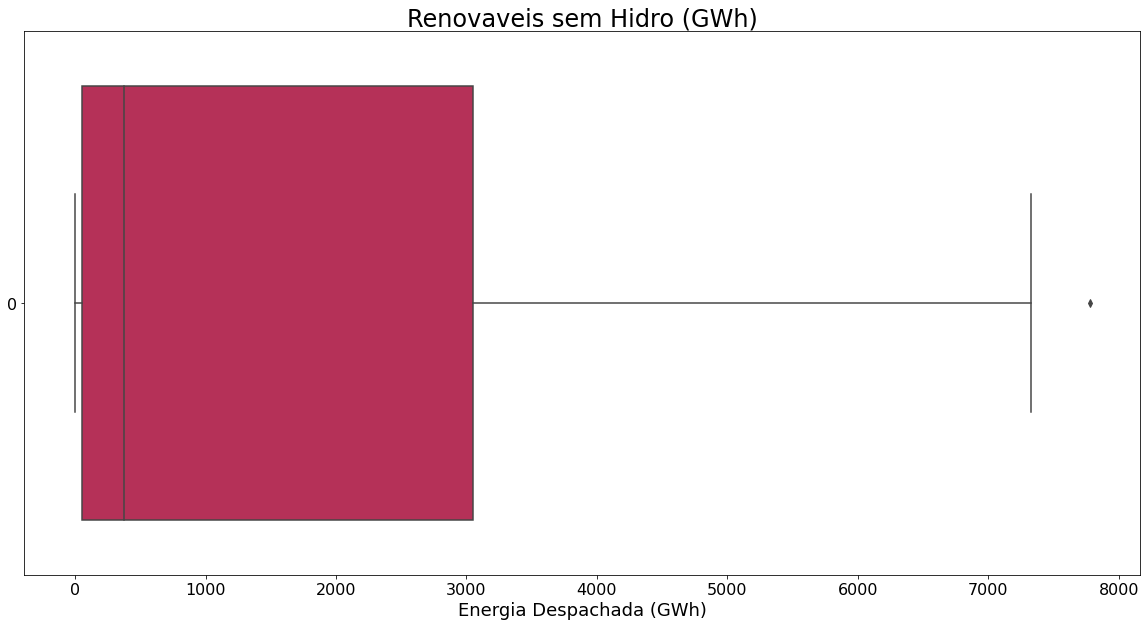

In [131]:
# Boxplot para o Agrupamento "Renováveis (exceto Hidrelétricas)"
renovaveis_sem_hidro_graficos.boxplot()

In [132]:
# Descrição estatística dos dados do Agrupamento Renováveis (exceto Hidrelétricas)
renovaveis_sem_hidro_stats.descricao()

Renovaveis_sem_Hidro
count            178.000000
mean            1593.530778
std             2092.601528
min                0.055470
25%               55.649662
50%              378.635000
75%             3049.791548
max             7776.191280

In [133]:
# Obtenção dos valores outliers do Agrupamento Renováveis (exceto Hidrelétricas)
renovaveis_sem_hidro_stats.get_outliers()

Renovaveis_sem_Hidro
date                            
2019-08-01            7776.19128

O boxplot demonstra a presença de um outlier acima do valor máximo, com valor de 7776,19 GWH. Há uma grande densidade de dados até o valor da mediana (378,63 GWh), que é muito inferior à média do conjunto de dados (1593,53 Gwh).

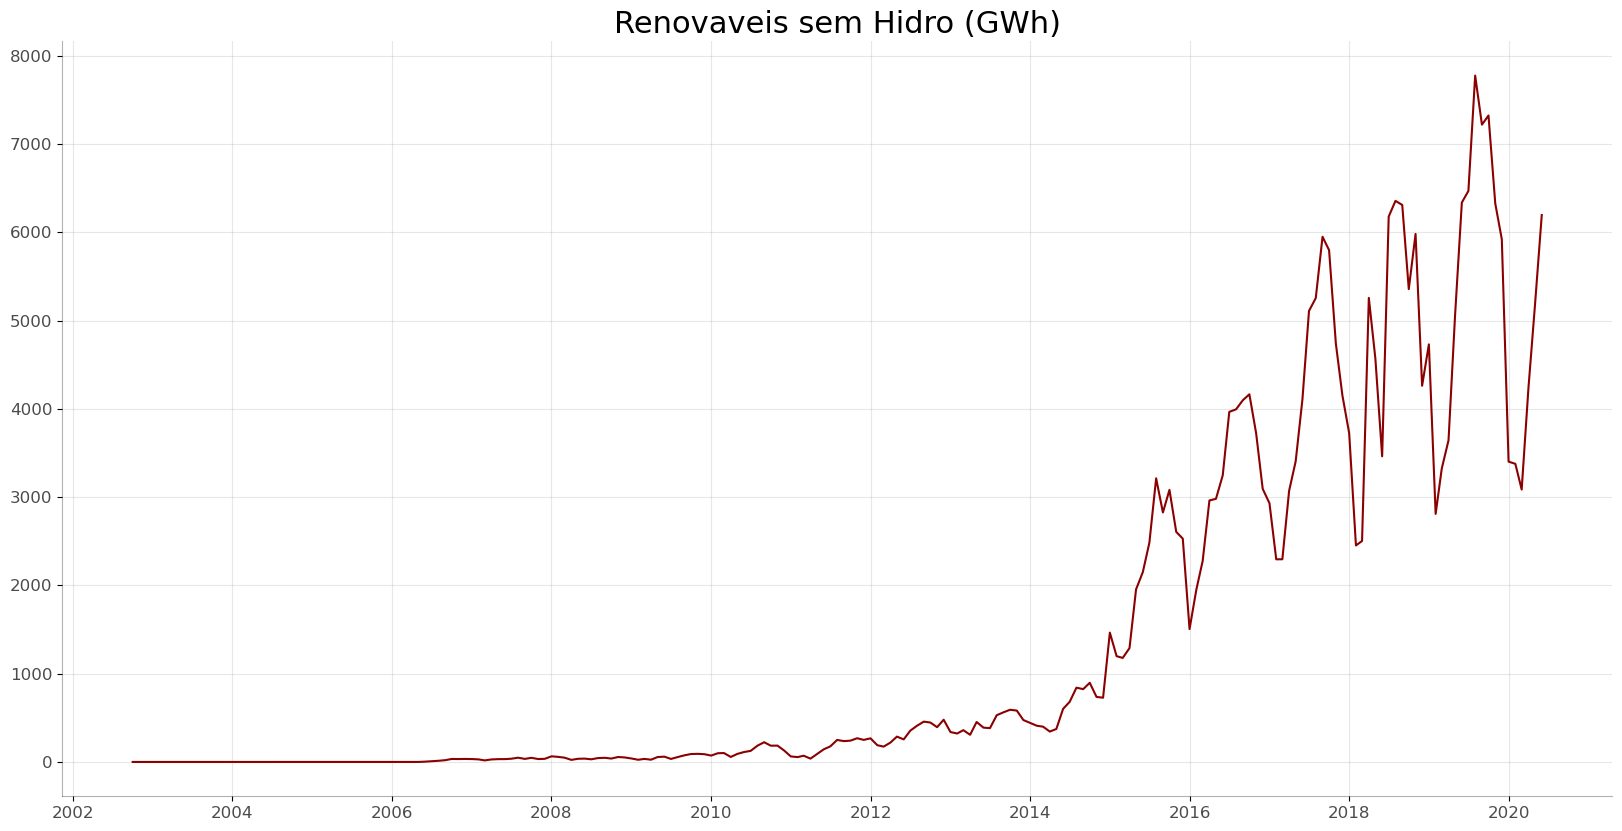

In [134]:
# Lineplot para o Agrupamento "Renováveis (exceto Hidrelétricas)"
renovaveis_sem_hidro_graficos.lineplot()

Esse agrupamento possuía valores pouco significativos, passando a crescer mais fortemente a partir de meados da década de 2010, sendo perceptível uma forte presença de sazonalidade.

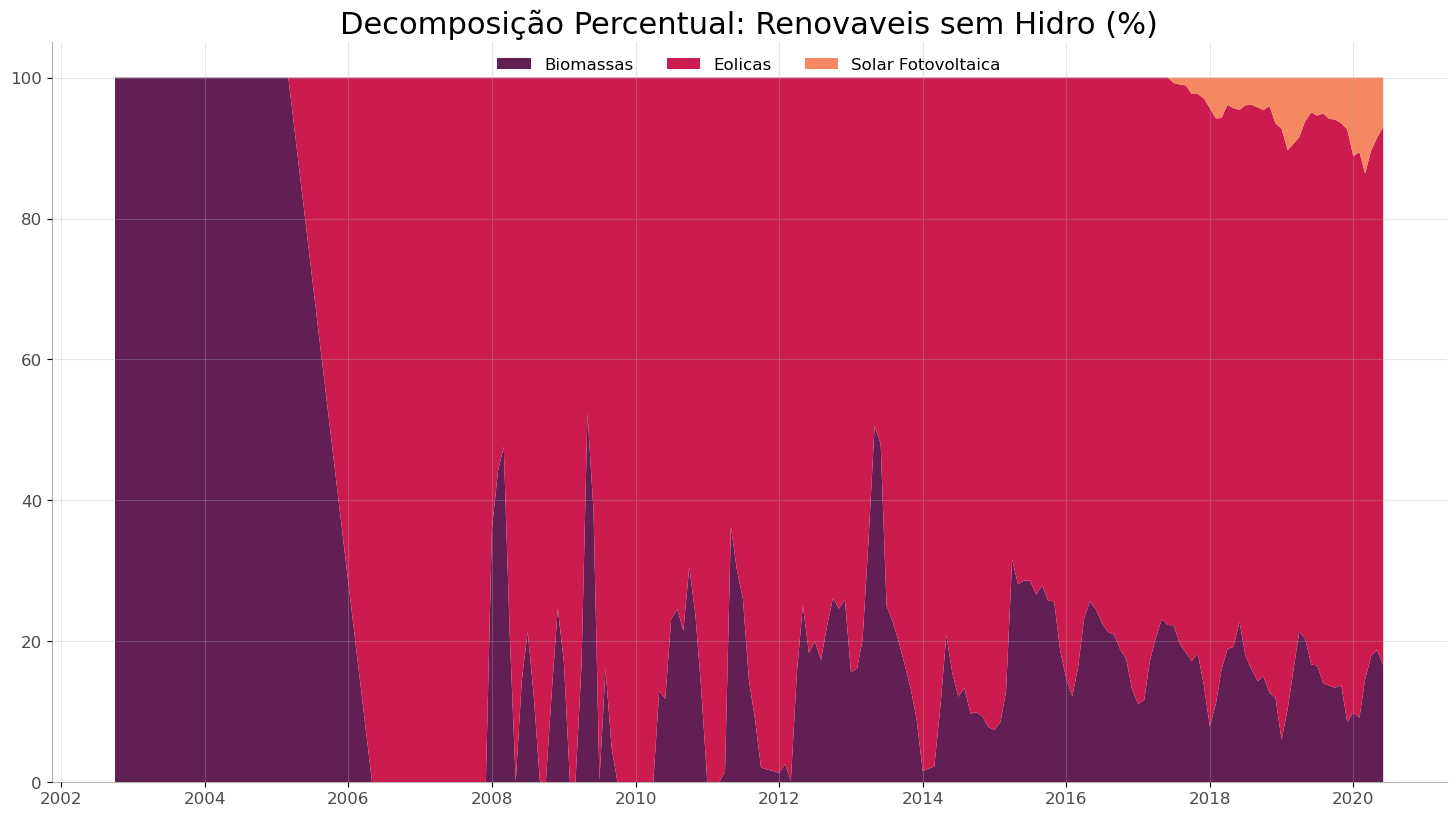

In [135]:
# Gráfico de Área para o Agrupamento "Renováveis (exceto Hidrelétricas)"
renovaveis_sem_hidro_graficos.areaplot(renovaveis_sem_hidro_selecao)

Como os valores até 2010 eram pouco significantes, é normal a variação percentual abrupta notada nos dados iniciais desse gráfico. Percebe-se que a energia Eólica se destaca como sendo a principal contribuidora para os números desse grupo, com Biomassa sem demonstrar grande crescimento no SIN enquanto o crescimento da Solar Fotovoltaica ainda aparenta estar no início.

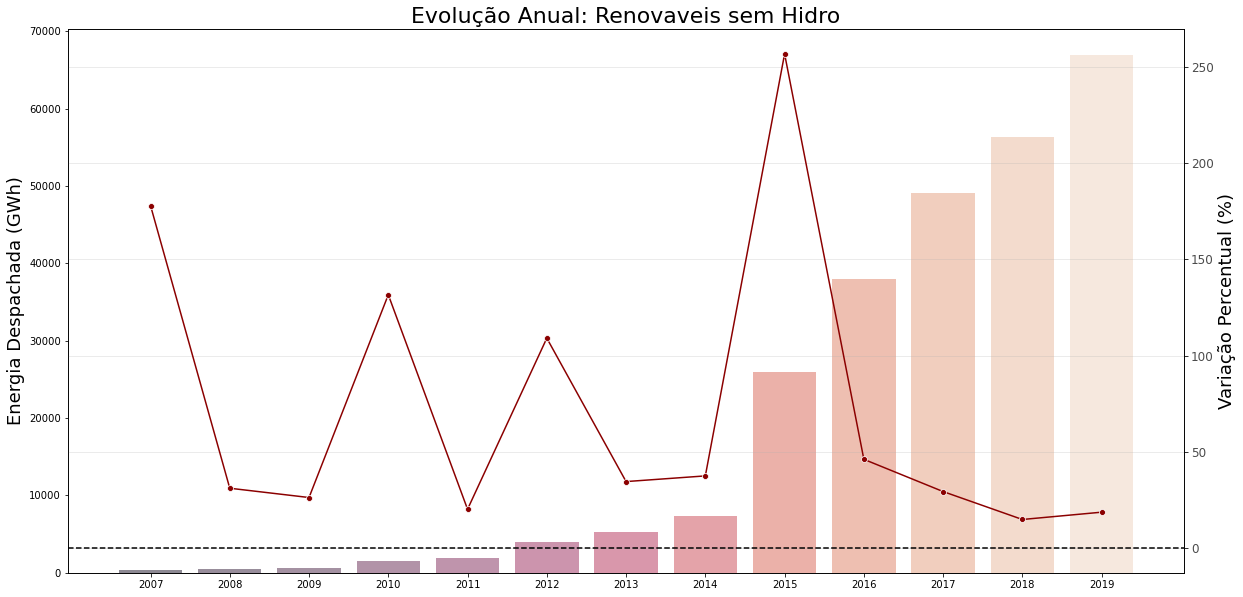

In [136]:
# Gráfico de barras de Produção Energética Anual de Hidrelétricas em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
renovaveis_sem_hidro_graficos.mixedplot()

Os valores de produção elétrica desse agrupamento não possuía grande significância até 2014, com valor inferior à 10000 GWh. De 2014-2015 foi observado um crescimento de mais de 250%, que manteve-se contínuo nos anos seguintes, embora com menor intensidade. 

#### 4.3.5. Total (exceto Hidrelétricas)

Não há valores nulos para essa variável pois há variáveis que formam esse agrupamento que não possuem valores nulos.

Criação dos objetos do Agrupamento Total (exceto Hidrelétricas) referentes às classes "Stats" e "Graficos", além da seleção das variáveis pertencentes ao agrupamento.

In [137]:
# Criação do objeto referente à Classe "Stats" de "Total (exceto Hidrelétricas)"
total_sem_hidro_stats = Stats('Total_sem_Hidro', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Total (exceto Hidrelétricas)"
total_sem_hidro_graficos = Graficos('Total_sem_Hidro', dados_limpos, soma, soma_perc)

# Seleção das variáveis do agrupamento
total_sem_hidro_selecao = dados_limpos[['Total_sem_Hidro', 'Nao_Renovavel', 'Renovaveis_sem_Hidro', 'Residuos_Industriais', 'Fora_do_SIN']]

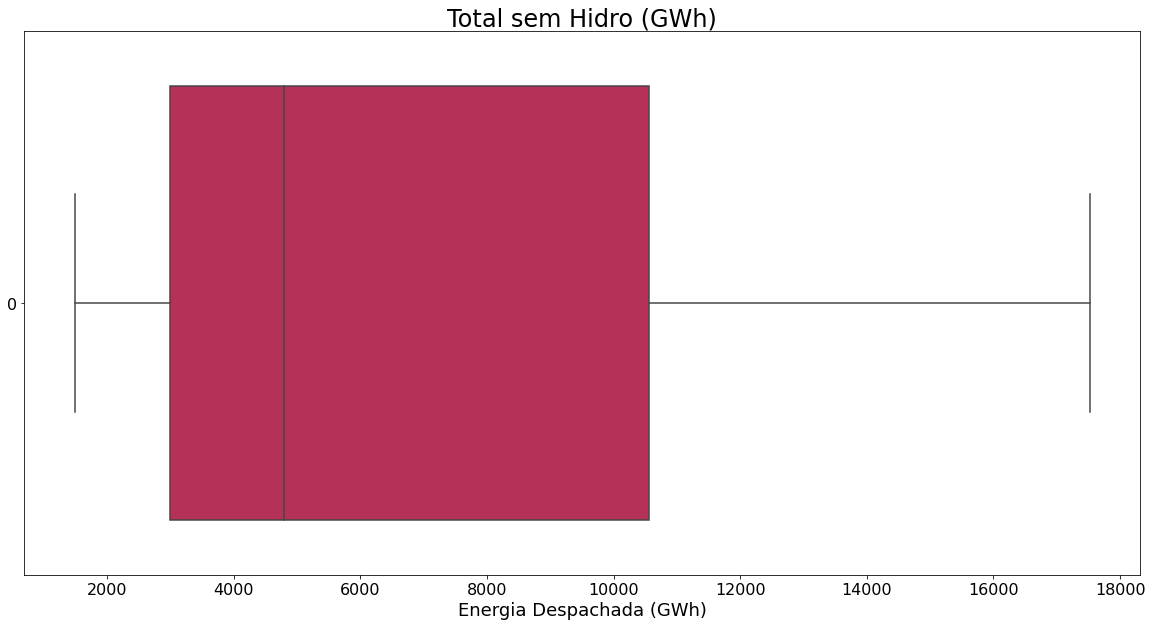

In [138]:
# Boxplot para o Agrupamento "Total (exceto Hidrelétricas)"
total_sem_hidro_graficos.boxplot()

In [139]:
# Descrição estatística dos dados do Agrupamento "Total (exceto Hidrelétricas)"
total_sem_hidro_stats.descricao()

Total_sem_Hidro
count       239.000000
mean       6885.131042
std        4449.865406
min        1496.332511
25%        2994.879568
50%        4796.713896
75%       10556.681972
max       17518.449603

Não há a presença de outliers nesse conjunto de dados, que varia entre 1496,36 GWh e 17518,45 GWh. A maior concentração dos dados ocorre em valores até a mediana (6885,13 GWh) e sua média é de 6885,13 GWh.

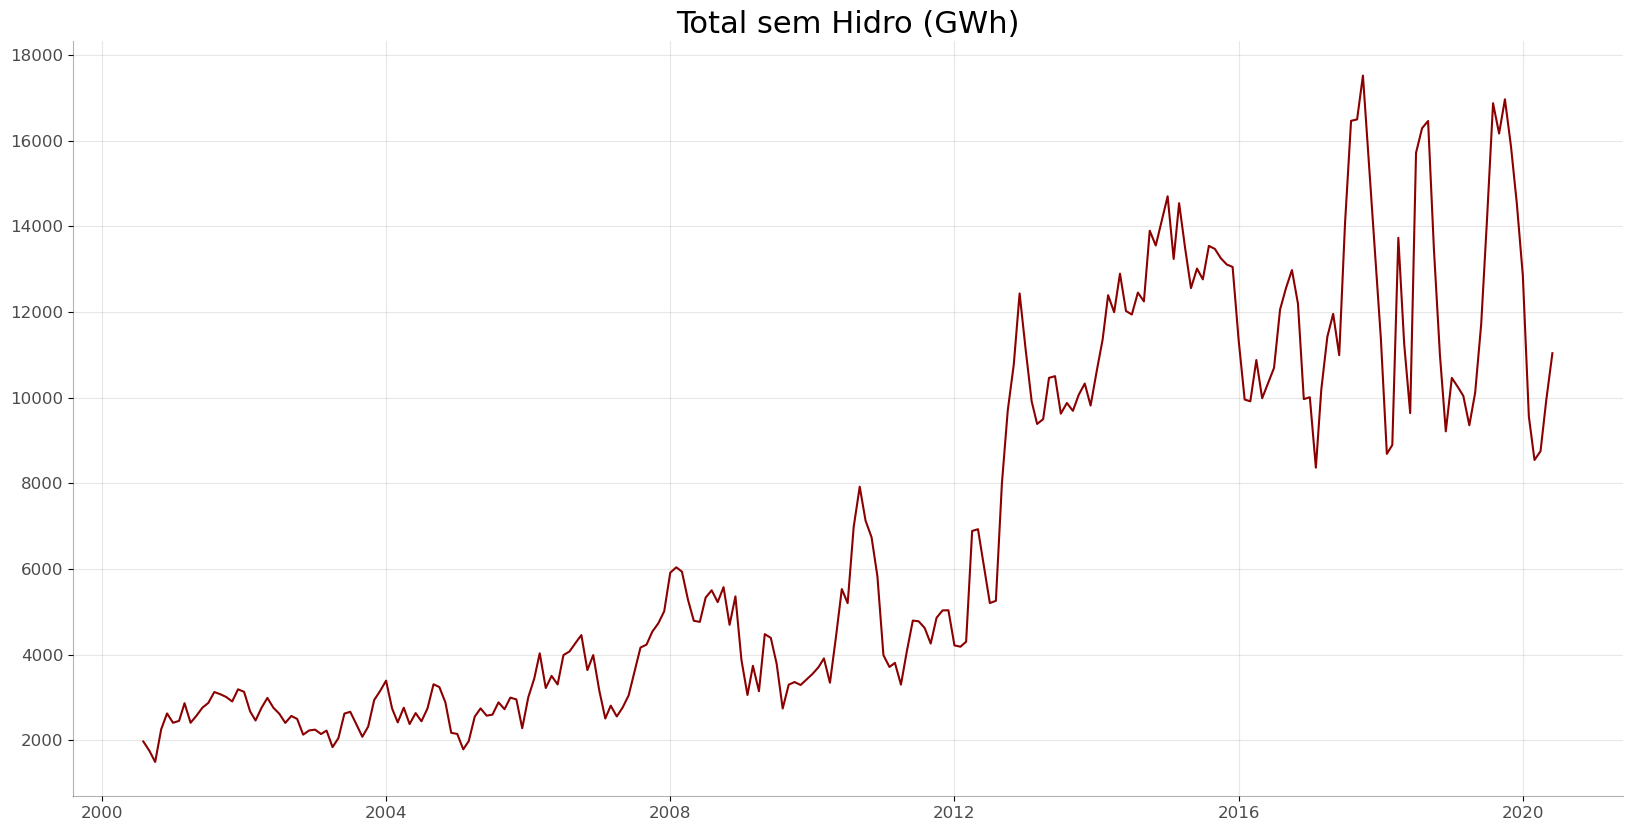

In [140]:
# Lineplot para o Agrupamento "Total (exceto Hidrelétricas)"
total_sem_hidro_graficos.lineplot()

Percebe-se que os valores dessa variável cresceram fortemente a partir de 2012, passando a ser mais influenciada por fatores sazonais à partir de 2016.

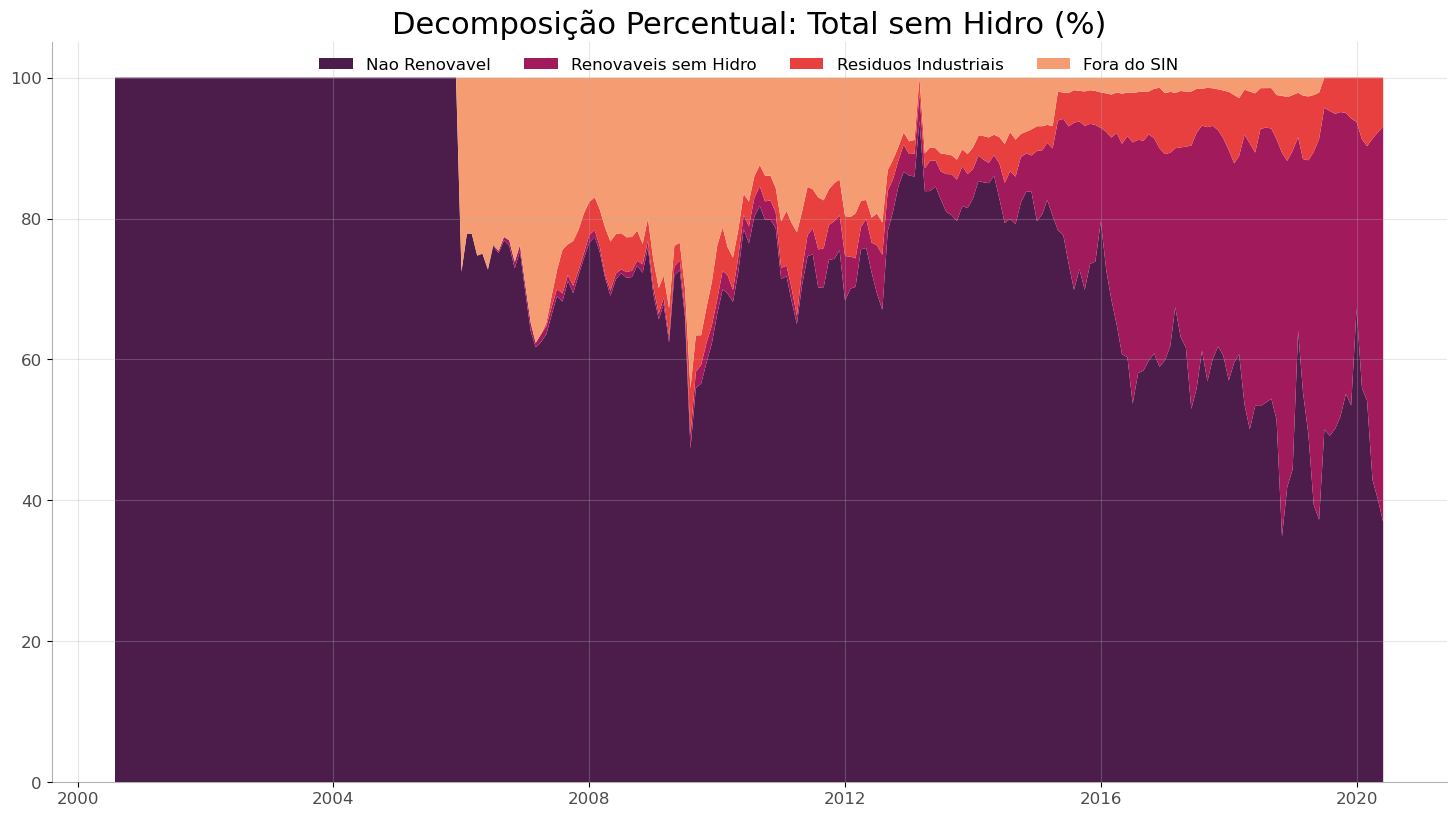

In [141]:
# Gráfico de Área para o Agrupamento "Total (exceto Hidrelétricas)"
total_sem_hidro_graficos.areaplot(total_sem_hidro_selecao)

Percebe-se que na década de 2000 basicamente toda a Energia Elétrica do SIN - fora Hidrelétricas - provinha de fontes Não Renováveis. No começo da década foi feito um alto investimento no uso de Termelétricas para o controle da crise hídrica, o que aumentou ainda mais a prevalência de fontes Não Renováveis na matriz. Entretanto, em meados da década de 2010 começou a haver um crescimento acelerado de outras Fontes Renováveis e uma queda no Uso de Fontes Não Renováveis, o que permitiu que as Fontes Não Renováveis fossem ultrapassadas pelas Fontes Renováveis não-hídricas, indicando uma mudança na forma como a Matriz Elétrica está se diversficando, optando por fontes menos poluentes.

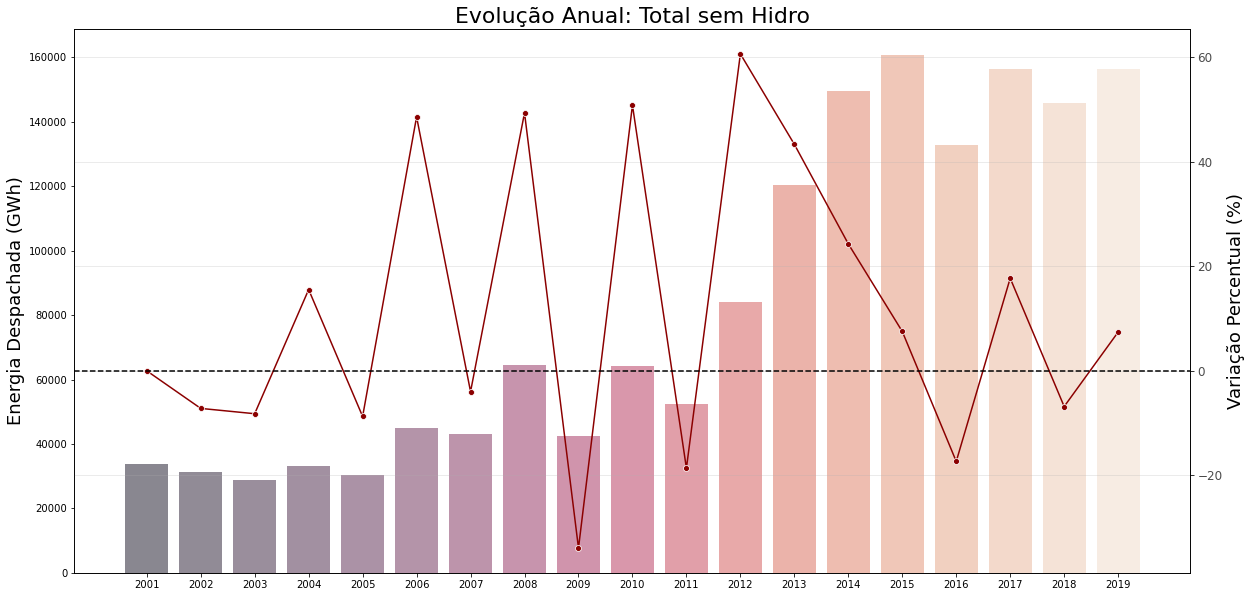

In [142]:
# Gráfico de barras de Produção Energética Anual de "Total (exceto Hidrelétricas)" em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
total_sem_hidro_graficos.mixedplot()

Nota-se uma mudança de patamar na produção elétrica desse agrupamento entre 2011 e 2012, onde houve um acréscimo de 60%. O crescimento foi desacelerando a partir deste ano, ocasionando um descrécimo de produção anual entre 2015 e 2016. Desde então, houve oscilações anuais de crescimento e queda de produção, com a produção de 2019 se aproximando do máximo de 2015.

#### 4.3.6. Total 

Não há valores nulos para essa variável pois há variáveis que formam esse agrupamento que não possuem valores nulos.

Criação dos objetos do Agrupamento Total referentes às classes "Stats" e "Graficos", além da seleção das variáveis pertencentes ao agrupamento.

In [143]:
# Criação do objeto referente à Classe "Nulos" de "Total"
total_nulos = Nulos('Total', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Total"
total_stats = Stats('Total', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Total"
total_graficos = Graficos('Total', dados_limpos, soma, soma_perc)

# Seleção das variáveis do agrupamento
total_selecao = dados_limpos[['Total', 'Renovaveis_sem_Hidro', 'Hidreletricas', 'Nao_Renovavel', 'Residuos_Industriais', 'Fora_do_SIN']]

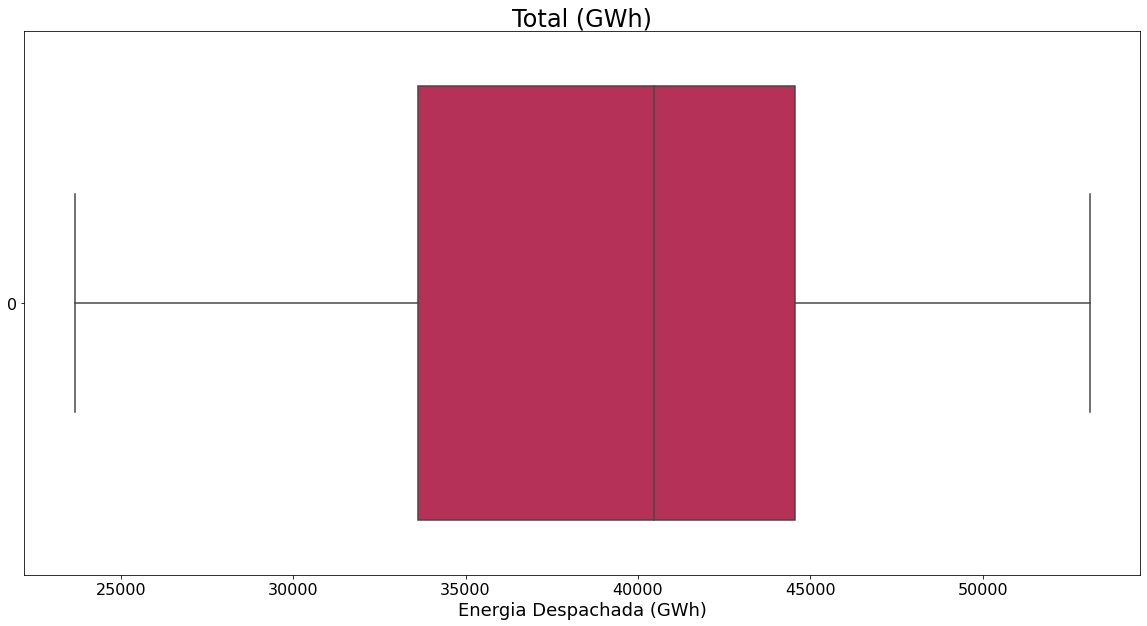

In [144]:
# Boxplot para a Energia Despachada Total
total_graficos.boxplot()

In [145]:
# Descrição estatística para a Energia Despachada Total
total_stats.descricao()

Total
count    239.000000
mean   39245.896169
std     6595.563042
min    23669.928370
25%    33605.637581
50%    40461.274022
75%    44554.007504
max    53103.613862

O boxplot não apresenta outliers, com os dados se concentrando na faixa entre e a mediana e o terceiro quartil (40641,27 GWh e 44554,01 GWh). A média de Energia Total Despachada no conjunto de dados foi de 39245,90 GWh, com 23669,93 GWh como valor mínimo e 53103,61 GWh como valor máximo.

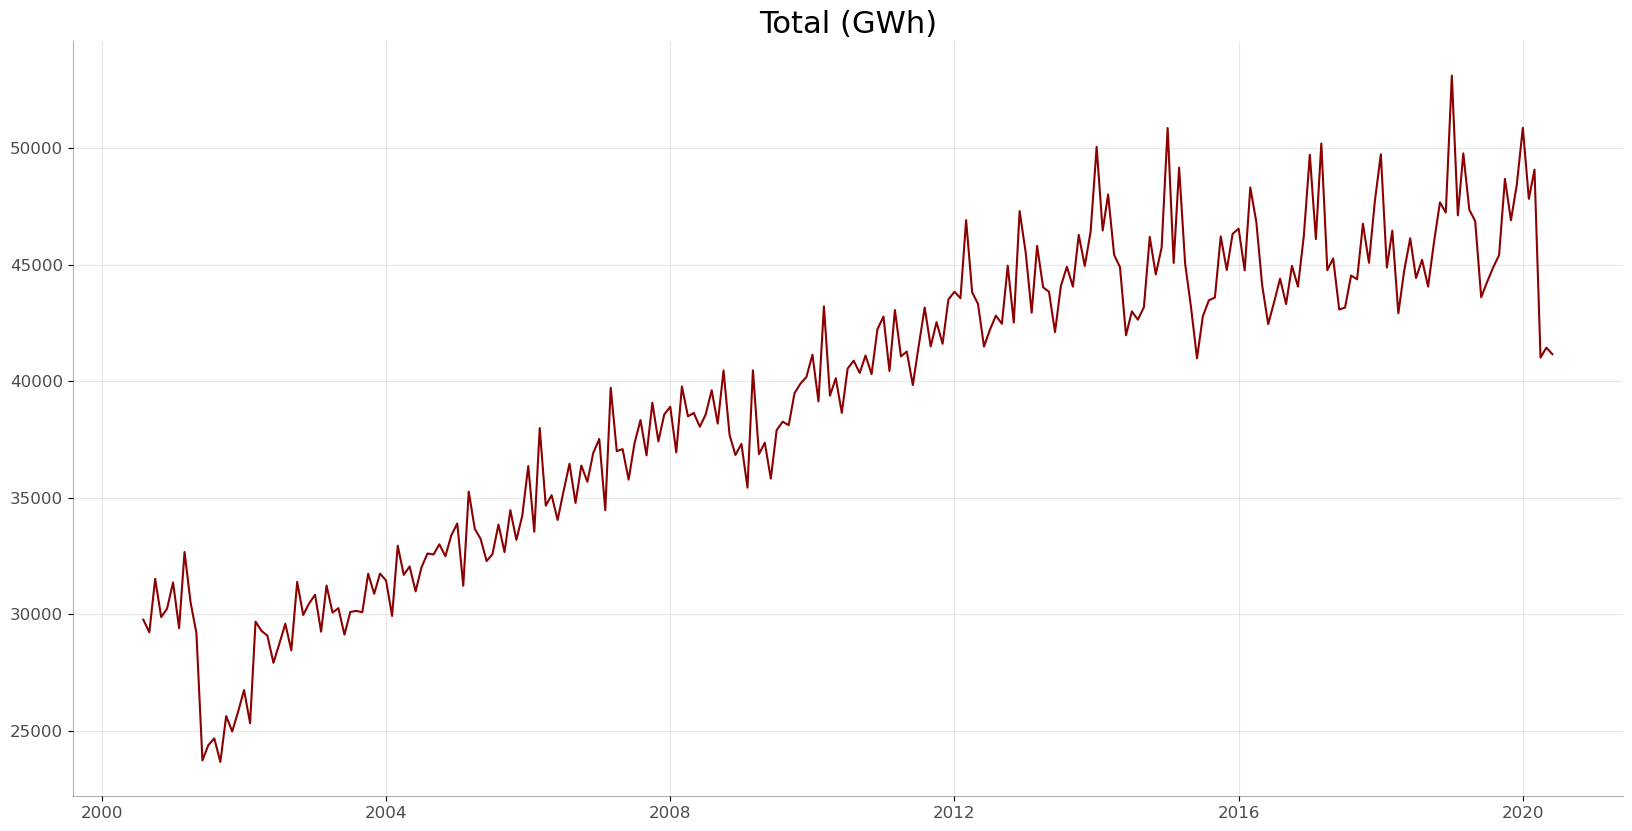

In [146]:
# Lineplot para Energia Despachada Total
total_graficos.lineplot()

Após a análise individual de cada fonte e agrupamento, é possível inferir certas observações ao observar a trajetória da Energia Despachada Total no SIN. A queda em 2001 se deu pela Crise do Apagão e o racionamento energético utilizado na época, a fim de evitar um colapso elétrico. Desde então nota-se um crescimento gradual de Energia Total, onde é evidente a presença cada vez mais forte de fatores sazonais na Matriz Elétrica.

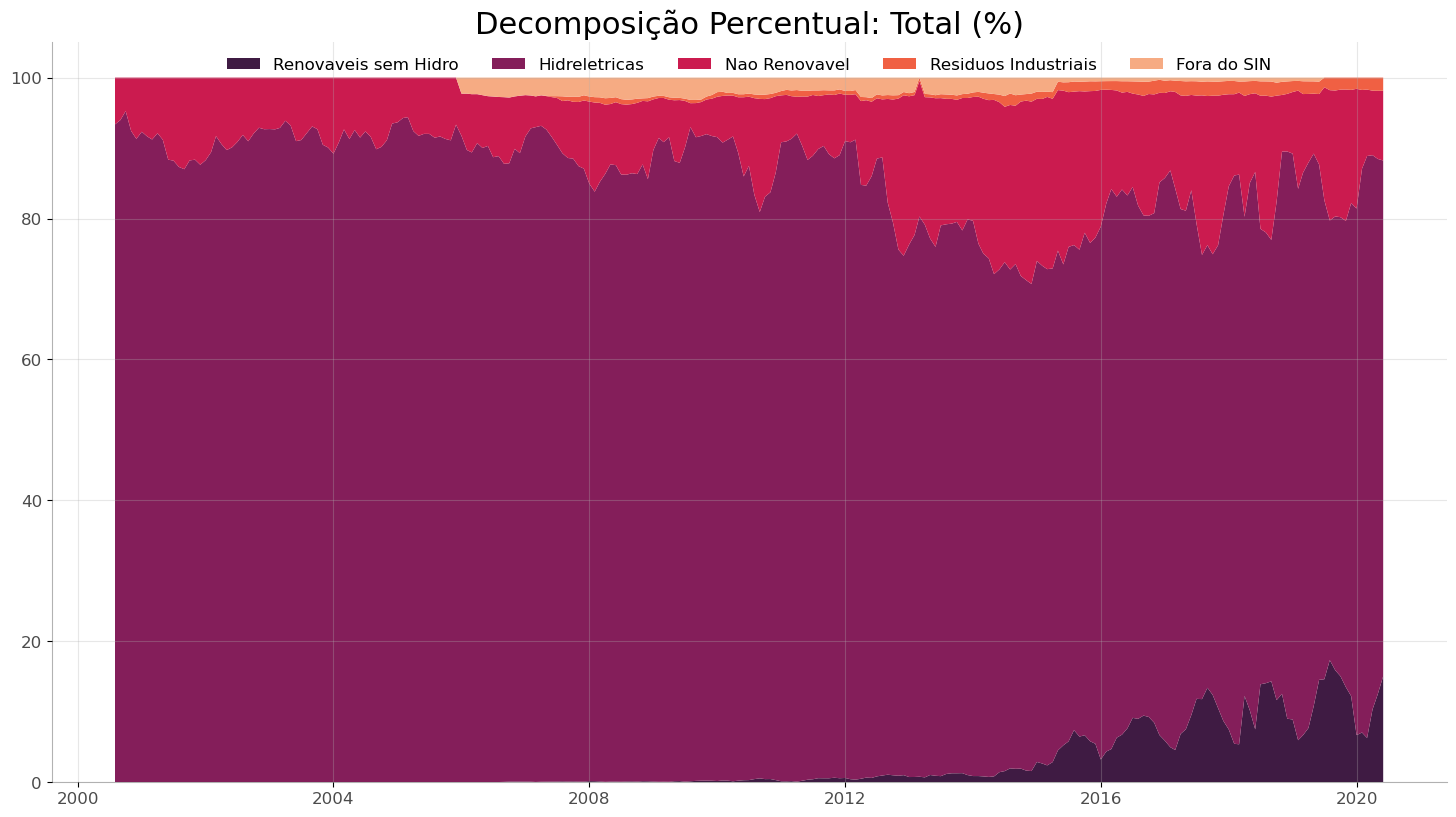

In [147]:
total_graficos.areaplot(total_selecao)

Nota-se que até 2012, a Energia Hidrelétrica predominava fortemente na Matriz Elétrica Brasileira, chegando a representar quase 90% da Energia Total em alguns momentos. A partir deste momento, percebe-se um forte aumento no uso de Fontes Não Renováveis até meados da década, onde percebe-se um aumento proporcional na utilização de Fontes Renováveis (exceto Hidrelétricas), chegando a representar quase 20% da Energia Despachada Total nos picos de produção de energia Eólica (fonte mais representativa desse agrupamento).

##### Renovável x Não Renovável

Como análise complementar, é importante saber o quanto variou a proporção de Energia Renovável despachada no SIN em comparação com a proveniente de Fontes Não Renováveis. Portanto, para comparação direta serão excluídas dessa análise "Fora do SIN" e "Resíduos Industriais", visto que suas participações na matriz não são muito significativas, não é possível identificar facilmente a natureza de suas fontes e, no caso de "Fora do SIN", os dados são demasiados irregulares e distantes da realidade.

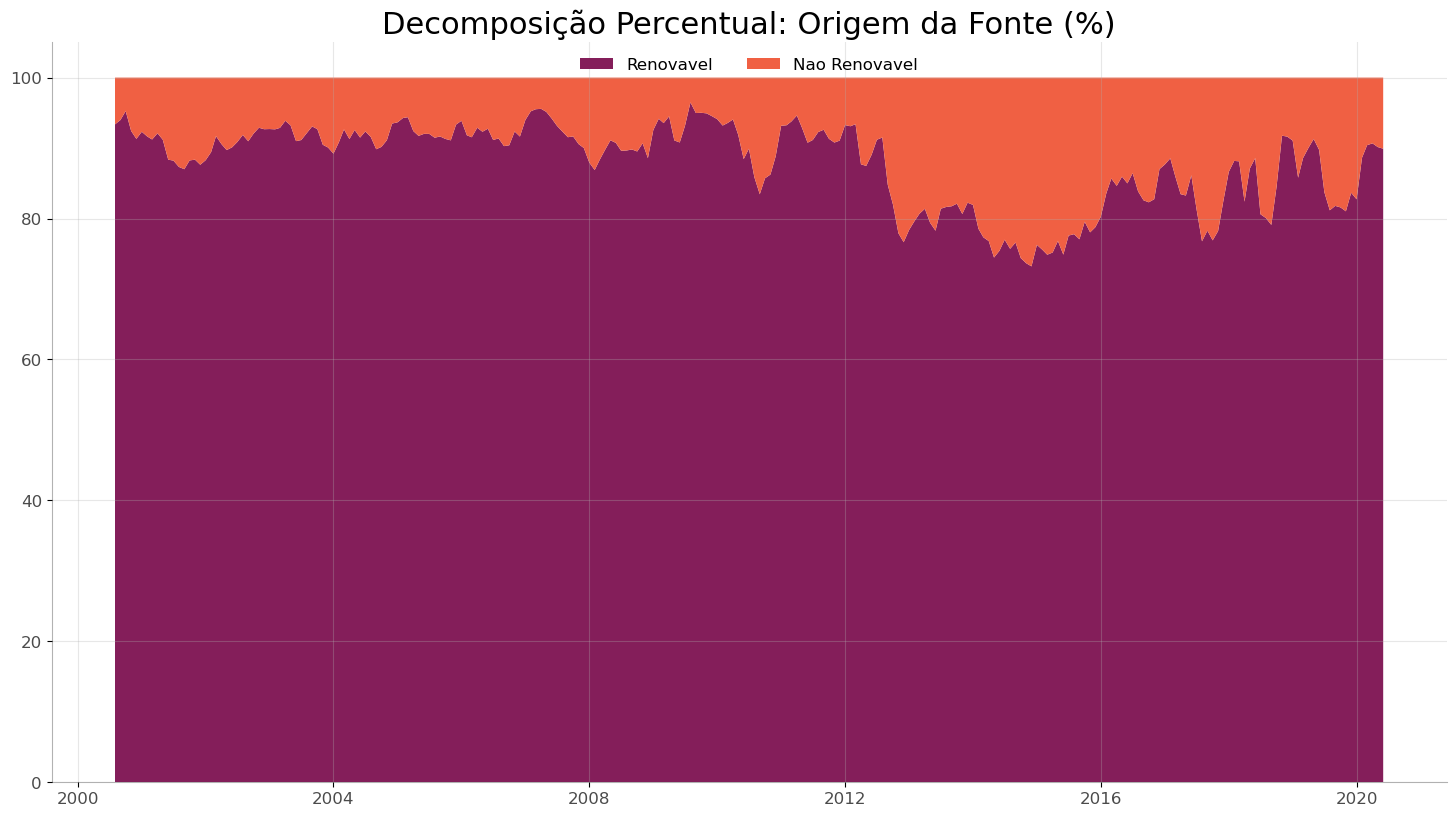

In [148]:
# Criação da variável que soma Energia Renovável e Não Renovável
origem = pd.DataFrame(dados_limpos['Total'] - dados_limpos['Residuos_Industriais'] - dados_limpos['Fora_do_SIN'], columns=['Origem da Fonte'])
selecao = dados_limpos[['Renovavel', 'Nao_Renovavel']]
ren_nao_ren_selecao = pd.concat([origem, selecao], axis=1)

# Criação do objeto referente à Classe "Graficos" de "Carvao"
ren_nao_ren_graficos = Graficos('origem', selecao, soma=None, soma_perc=None)

# Gráfico de Área que compara Energia Renovável com a Não Renovável
ren_nao_ren_graficos.areaplot(ren_nao_ren_selecao)

O Brasil é conhecido internacionalmente pela forte predominância de Fontes Renováveis na sua Matriz Elétrica, com destaque para o forte uso de Hidrelétricas. Entretanto, a forte dependência por essa fonte gerou problemas de garantia de fornecimento elétrico na Crise de 2001, incentivando a construção de Usinas Termelétricas para que essas fossem acionadas em momentos de crise hídrica. Entretanto, o uso de Termelétricas encarece a produção energética e aumenta fortemente os níveis de emissão de gás carbônico (CO2), o que contribui para o aumento do aquecimento global, causando problemas do ponto de vista econômico, social e ambiental. Portanto, a diversificação da Matriz Elétrica Brasileira deve ser feita de forma a maximizar a produção elétrica de forma a garantir a segurança no fornecimento de energia ao passo que minimiza a emissão de gases estufa.

O gráfico acima demonstra que a participação de Fontes Renováveis - que superou os 90% em muitos momentos - caiu para valores abaixo de 80% em meados da década de 2010. Entretanto, desde o final da década de 2010 tem ocorrido um grande aumento no uso de Fontes Renováveis, se aproximando do patamar observado no começo do século em seus pontos de máximo. Contudo, dessa vez a Matriz Elétrica é muito menos dependente das Hidrelétricas, o que garante um aumento da confiabilidade da produção energética nacional.

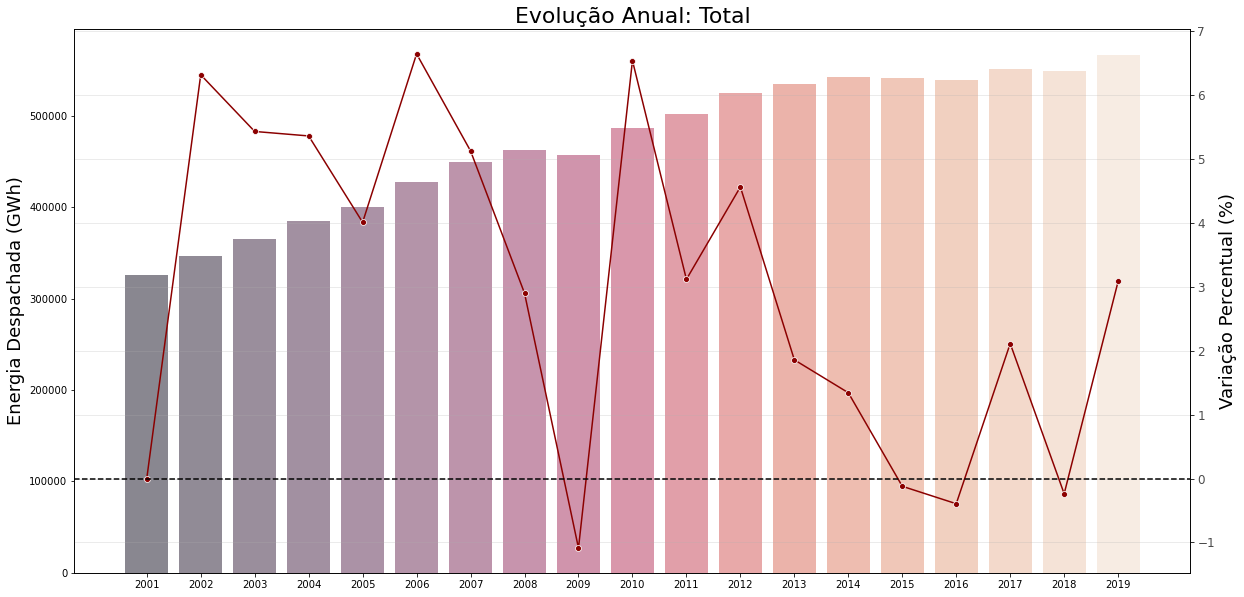

In [149]:
# Gráfico de barras da Energia Despachada Total em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
total_graficos.mixedplot()

A Energia Despachada Total cresceu constantemente desde o começo da Série Histórica até 2014, com 2009 sendo a única exceção, influenciada pela queda econômica gerada pela Crise Mundial. Entretanto, em 2015 e 2016 houveram quedas como resultado de uma Crise Econômica interna, procedida de um crescimento de mais de 2% em 2017 e de mais de 3% em 2019, excetuando-se 2018 que observou uma ligeira queda.

### 4.4. Análise da correlação entre as Fontes de Energia

O objetivo dessa etapa é avaliar as correlações existentes entre cada Fonte de Energia a partir do plot de dois gráficos. O primeiro, chamado "pair grid", é composto de 3 tipos de gráficos: 

- Diagonal: Histograma da variável presente na diagonal (análise da variável individual);
- Inferior à Diagonal: Estimativa de densidade Kernel entre as 2 variáveis ;
- Superior à Diagonal: Dispersão dos dados entre as 2 variáveis.

O segundo é um mapa de calor (heatmap) que irá demonstrar a correlação entre as variáveis.

In [150]:
# Criação do objeto referente às variáveis utilizadas para análises de correlação
selecao = dados_limpos[dados_limpos.columns[0:11]]
corr = Correlacao(selecao)

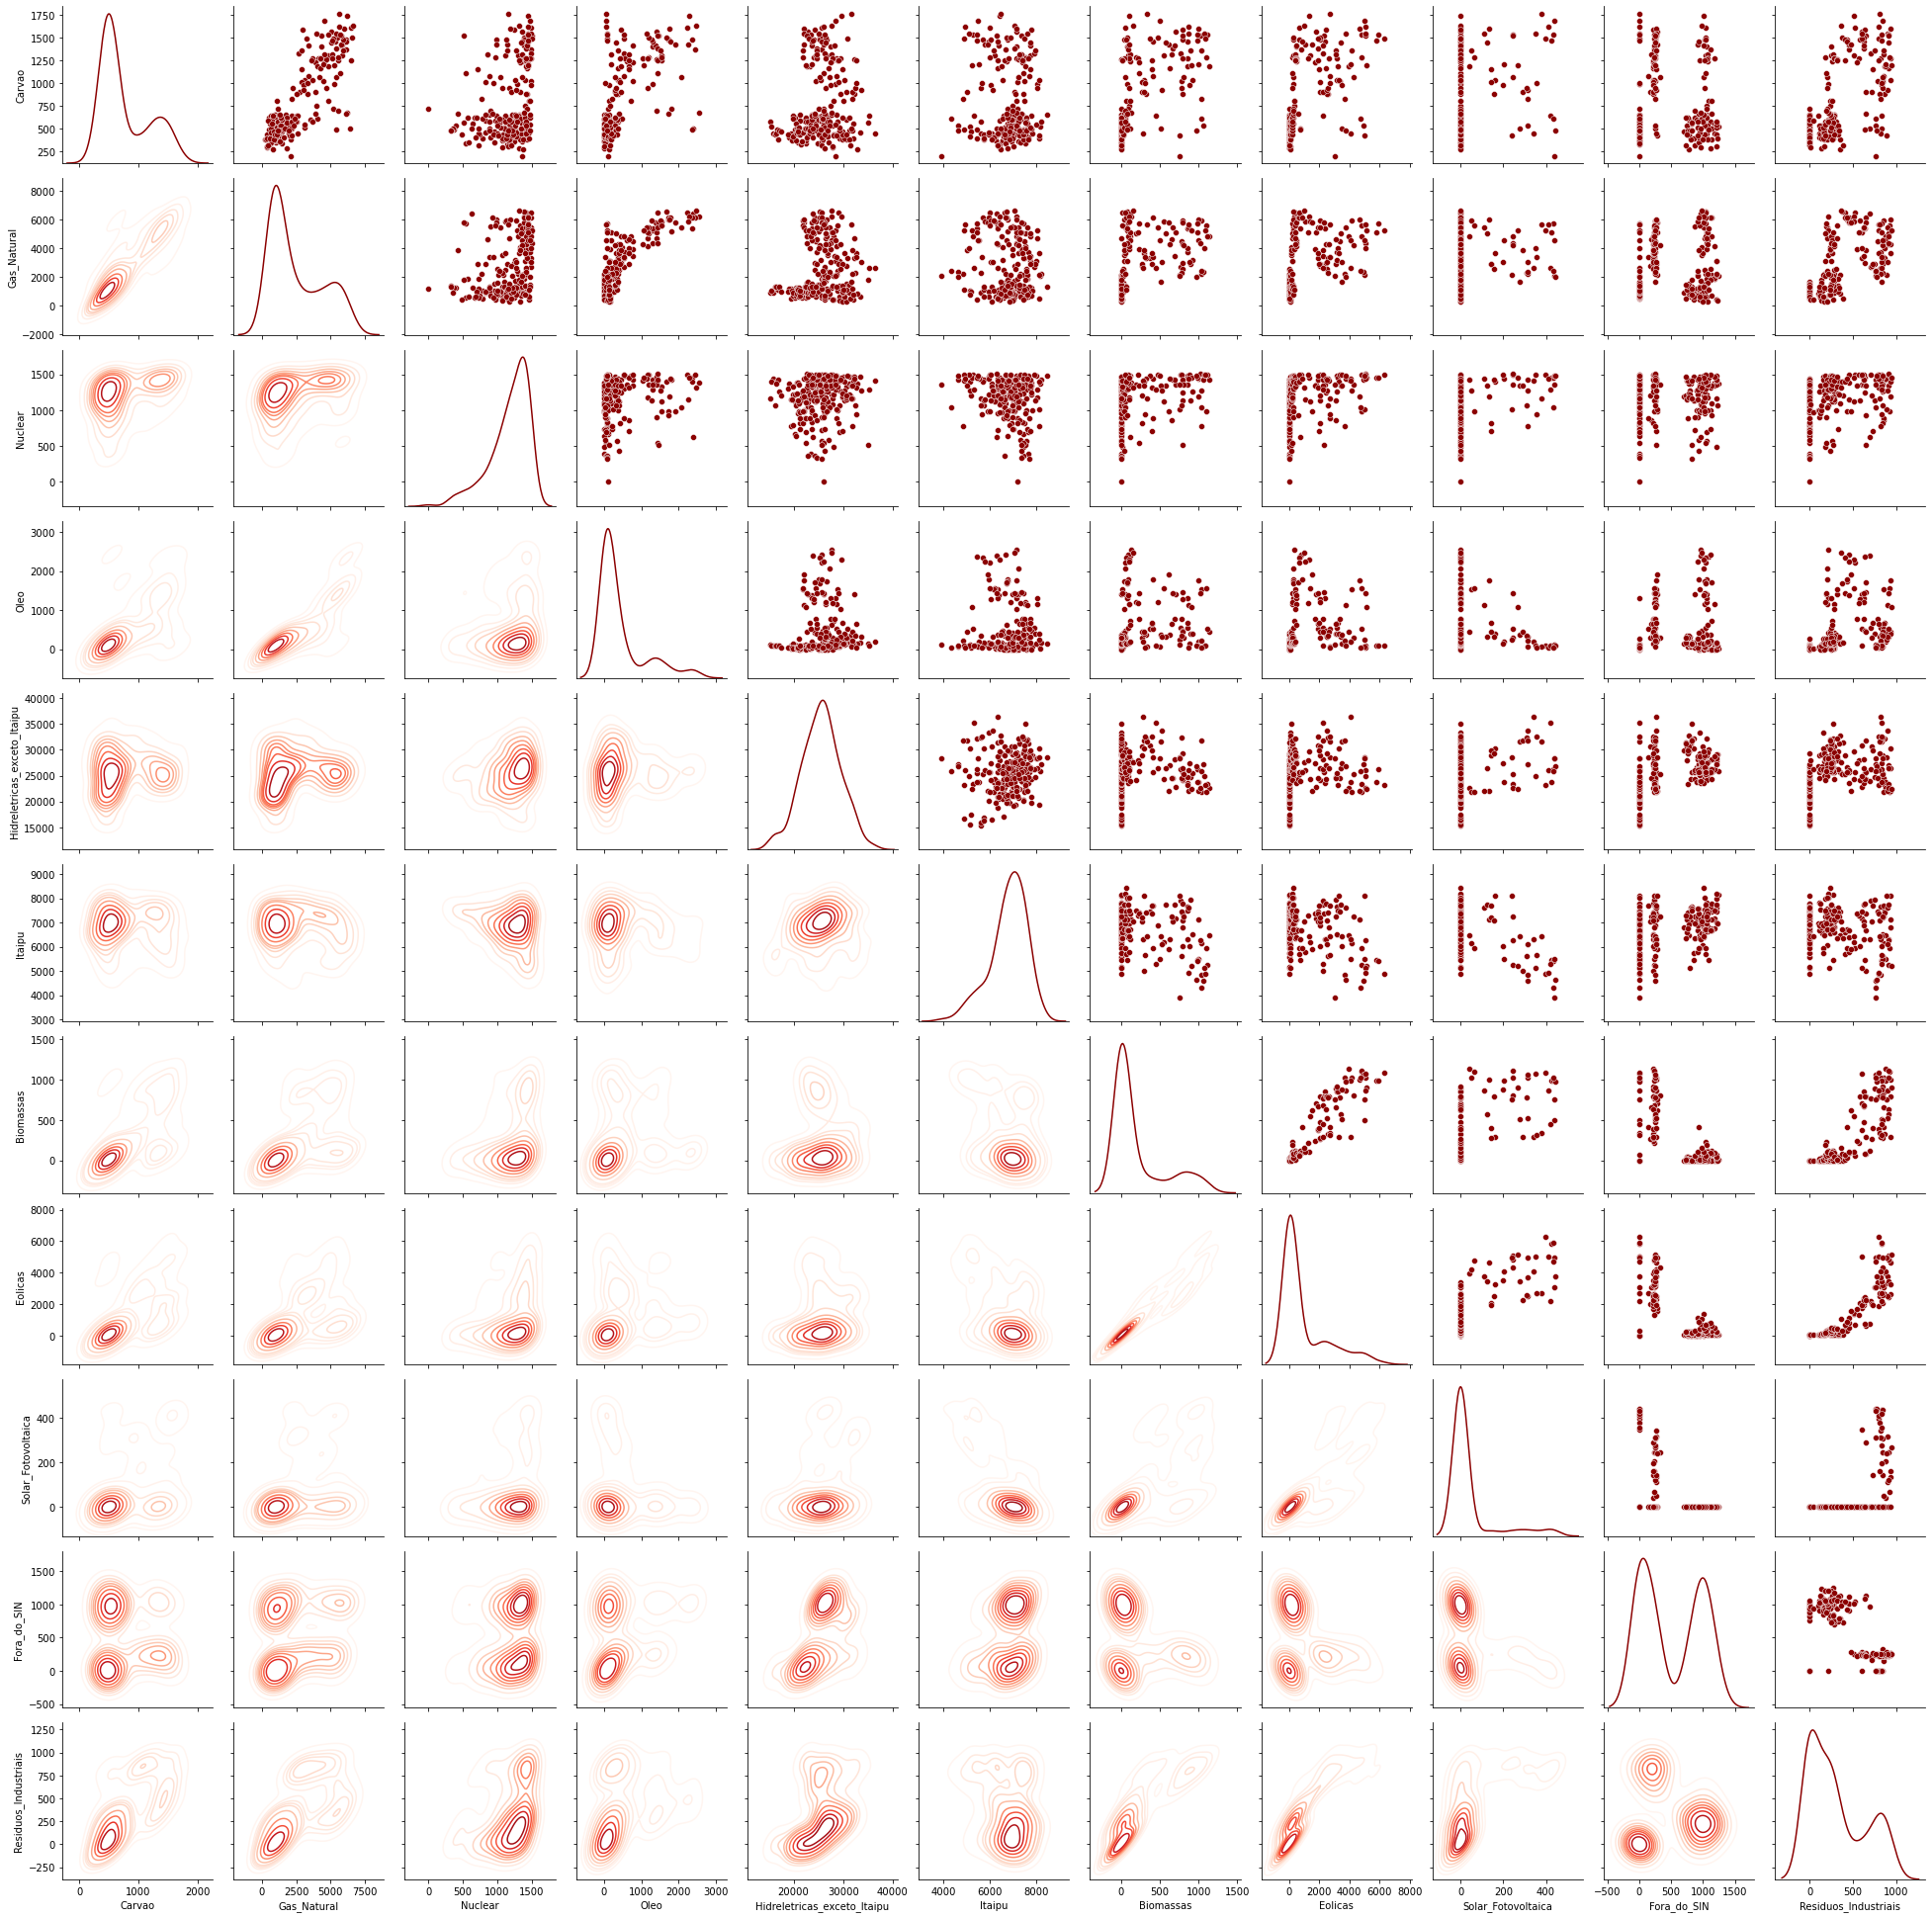

In [151]:
# Pair Grid para as Fontes de Energia
corr.pairgrid()

Os Histogramas de cada variável possuem desvios em relação à normalidade, com exceção da variável "Hidrelétricas (exceto Itaipu)", que possui uma distribuição bem simétrica. Com exceção da Fonte Nuclear - que possui Assimetria Negativa - todas as outras variáveis possuem Assimetria Positiva. Através dos gráficos de dispersão, não se nota uma grande correlação entre a maioria das variáveis.

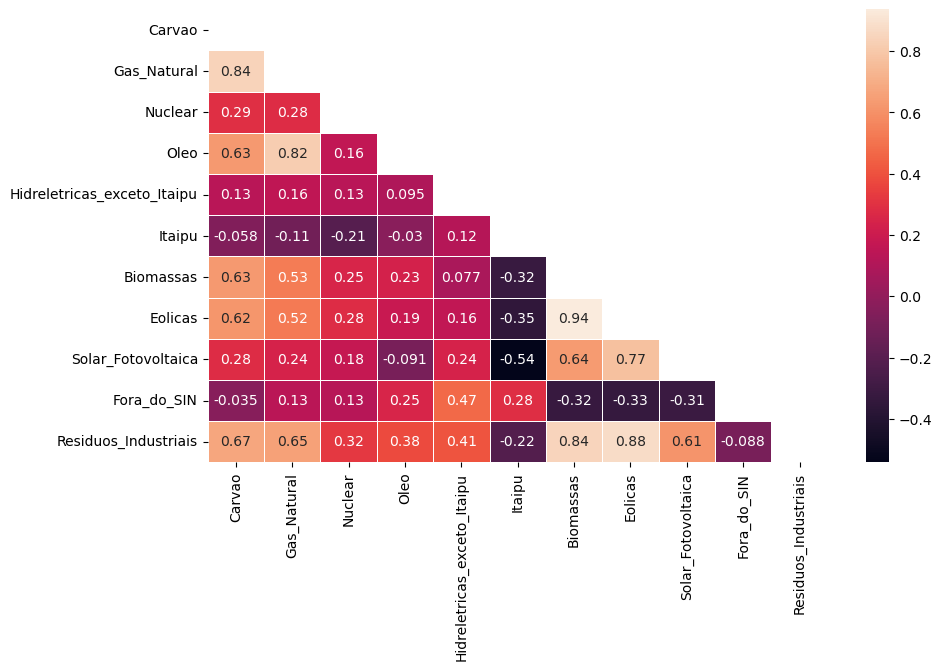

In [152]:
# Correlação entre as Fontes de Energia
corr.heatmap()

O mapa de calor acima mostra que grande parte das fontes não possuem fortes correlações entre si, de forma que apenas 5 variáveis possuem valores de correlação acima de 0.8, explicitadas abaixo:

In [153]:
# Seleção de valores com correlação acima de 0.8
corr.seleciona_corr(0.8, '>')

Variável 1            Variável 2  Correlação
0    Biomassas               Eolicas    0.936269
1      Eolicas  Residuos_Industriais    0.877725
2    Biomassas  Residuos_Industriais    0.844093
3       Carvao           Gas_Natural    0.843714
4  Gas_Natural                  Oleo    0.818324

Percebe-se uma forte correlação entre duas variáveis Não Renováveis ("Gás Natural" com "Carvão" e "Óleo Diesel/Combustível") e a maior correlação é vista entre "Biomassas" e "Eólicas", sendo a única superior à 0,936. Já "Resíduos Industriais", que obteve crescimento recente, correlaciona-se muito bem com Biomassas e Eólicas que tiveram mesma tendência. É possível inferir uma causalidade, visto que, pelas fontes possuírem naturezas semelhantes - Renovável ou Não Renovável - seus crescimentos ocorreram em momentos semelhantes através de políticas governamentais de expansão.

In [154]:
# Seleção de valores com correlação abaixo de -0.3
corr.seleciona_corr(-0.3, '<')

Variável 1          Variável 2  Correlação
0  Solar_Fotovoltaica         Fora_do_SIN   -0.314258
1              Itaipu           Biomassas   -0.321577
2           Biomassas         Fora_do_SIN   -0.323824
3             Eolicas         Fora_do_SIN   -0.329168
4              Itaipu             Eolicas   -0.354621
5              Itaipu  Solar_Fotovoltaica   -0.541790

Já entre os valores com correlações negativas, foram selecionadas as variáveis abaixo de -0.3. Nota-se que "Itaipu" e "Fora do SIN" possuem correlações negativas em comparação com "Biomassas", "Eólicas" e "Solar Fotovoltaica". Como o comportamento de "Fora do SIN" é irregular, o foco ficará na correlação de "Itaipu" com fontes renováveis que tiveram crescimento na Matriz Elétrica recente ao passo que "Itaipu" teve queda na sua produção pela crise na sua Bacia Hidrográfica. Portanto, não dá para inferir causalidade entre as correlações negativas mais fortes vistas no conjunto de dados.

# FINALIZAÇÃO 

Está finalizada a Análise Exploratória da Energia Elétrica Brasileira, com a análise realizada para cada Fonte de Energia e para cada agrupamento criado. O projeto continuará a partir da análise em Séries Temporais de algumas variáveis com o intuito de modelar e prever seus comportamentos para os meses subsequentes. 

Se quiser tirar alguma dúvida, fazer alguma sugestão ou conversar sobre o projeto, entre em contato comigo! Obrigado pela atenção :D 